In [27]:
import os
import json
import re
from collections import Counter
import pandas as pd
BASE_DIR = "youtube_comments_v2"
from pathlib import Path
current_dir = Path.cwd()
#  Move up one level to the project root
project_root = current_dir.parent
# Point to the parallel “video_comments” folder under the root
data_dir = project_root /BASE_DIR

# Fast emoji remover via Unicode range
def clean_text(text):
    emoji_pattern = re.compile(
        "[\U0001F600-\U0001F64F"
        "\U0001F300-\U0001F5FF"
        "\U0001F680-\U0001F6FF"
        "\U0001F1E0-\U0001F1FF"
        "\U00002500-\U00002BEF"
        "\U00002702-\U000027B0"
        "\U000024C2-\U0001F251"
        "\U0001f926-\U0001f937"
        "\U00010000-\U0010ffff"
        "\u2640-\u2642"
        "\u2600-\u2B55"
        "\u200d"
        "\u23cf"
        "\u23e9"
        "\u231a"
        "\ufe0f"
        "\u3030]+", flags=re.UNICODE
    )
    text = emoji_pattern.sub(r'', text)
    text = re.sub(r"&[a-z]+;", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip().lower()

# Count comments per user
comment_counts = {"short": Counter(), "long": Counter()}

for video_type in ["short", "long"]:
    length_dir = os.path.join(data_dir, video_type)
    if not os.path.isdir(length_dir):
        continue
    for category in os.listdir(length_dir):
        category_dir = os.path.join(length_dir, category)
        if not os.path.isdir(category_dir):
            continue
        for filename in os.listdir(category_dir):
            if not filename.endswith(".json"):
                continue
            filepath = os.path.join(category_dir, filename)
            try:
                with open(filepath, "r", encoding="utf-8") as f:
                    data = json.load(f)
                    for comment in data.get("comments", []):
                        author = comment.get("author")
                        comment_counts[video_type][author] += 1
            except Exception as e:
                print(f"Error reading {filepath}: {e}")

# Combine into unified user-level table
all_users = set(comment_counts["short"].keys()) | set(comment_counts["long"].keys())
rows = []
for user in all_users:
    short_count = comment_counts["short"].get(user, 0)
    long_count = comment_counts["long"].get(user, 0)
    total_count = short_count + long_count
    rows.append({
        "user": user,
        "short_comment_count": short_count,
        "long_comment_count": long_count,
        "total_comment_count": total_count
    })
short_user_count = len(comment_counts["short"])
long_user_count = len(comment_counts["long"])
print("Short video user count:", short_user_count)
print("Long video user count:", long_user_count)


Short video user count: 12434257
Long video user count: 1134687


In [28]:
# Find active users in both short and long video types
short_users = set(comment_counts["short"].keys())
long_users = set(comment_counts["long"].keys())
comments_both = short_users & long_users

print(f"Users active in both short and long: {len(comments_both)}")

# Compute average comment counts for these users
short_total = sum(comment_counts["short"][user] for user in comments_both)
long_total = sum(comment_counts["long"][user] for user in comments_both)
combined_total = short_total + long_total
user_count = len(comments_both)

if user_count > 0:
    print(f"Avg comments (short) per commented user: {short_total / user_count:.2f}")
    print(f"Avg comments (long) per commented user: {long_total / user_count:.2f}")
    print(f"Avg total comments per commented user: {combined_total / user_count:.2f}")
else:
    print("No users comments in both video types.")
    

Users active in both short and long: 185570
Avg comments (short) per commented user: 2.40
Avg comments (long) per commented user: 1.32
Avg total comments per commented user: 3.71


In [29]:
import math
import pandas as pd

# Compute how many users correspond to the top 0.5%
counts_for_top = {}
for video_type in ["short", "long"]:
    total_users    = len(comment_counts[video_type])
    top_n          = math.ceil(total_users * 0.0005)   
    # Store the actual top-N dict for later DataFrame construction
    counts_for_top[video_type] = dict(
        comment_counts[video_type].most_common(top_n)
    )
    print(
        f"{video_type.capitalize()} video: Total users = {total_users}, "
        f"Top 0.05% = {top_n} users"
    )

# Build DataFrame for the SHORT-video top users
#    Use the dict of user→count, not the integer top_n
top_short_dict = counts_for_top["short"]

df_top_short = pd.DataFrame(
    list(top_short_dict.items()),
    columns=["user", "short_comment_count"]
)

# Remove any rows where 'user' is empty or falsy
df_top_short = df_top_short[df_top_short["user"].astype(bool)]

# Sort by short_comment_count descending and reset the index
df_top_short = (
    df_top_short
    .sort_values(by="short_comment_count", ascending=False)
    .reset_index(drop=True)
)

# Display the top 5 users
print("Top 5 users with most SHORT video comments:")
display(df_top_short.head(5))


Short video: Total users = 12434257, Top 0.05% = 6218 users
Long video: Total users = 1134687, Top 0.05% = 568 users
Top 5 users with most SHORT video comments:


,user,short_comment_count
0,@TuĝbaSelek-y2t,1142
1,@jenistiuca492,873
2,@adanilsoncapel,766
3,@beaandsabrinafans7770,519
4,@Akhilesh_singh_offical,512


In [30]:
sampled1000_short =df_top_short.sample(n=1000, random_state=32)
sampled1000_short.to_json("sampled_short_users.json", orient="records", lines=True, force_ascii=False)

In [32]:
import os
import json
from collections import defaultdict

# Base directory where the YouTube comment data is stored
BASE_DIR = "youtube_comments_v2"

# Load user IDs for short-video-preference and long-video-preference users
short_user_ids = set(sampled1000_short["user"])
# Initialize storage for all comments from each user group
user_comments = {
    "short": defaultdict(list),
    "medium": defaultdict(list),
    "long": defaultdict(list)
}

# Traverse all videos directories to collect all comments
for video_type_dir in ["short","medium","long"]:
    video_dir = os.path.join(data_dir, video_type_dir)
    for category in os.listdir(video_dir):
        category_dir = os.path.join(video_dir, category)
        if not os.path.isdir(category_dir):
            continue
        for filename in os.listdir(category_dir):
            if not filename.endswith(".json"):
                continue
            filepath = os.path.join(category_dir, filename)
            try:
                with open(filepath, "r", encoding="utf-8") as f:
                    data = json.load(f)
                    for comment in data.get("comments", []):
                        author = comment.get("author")
                        if author in short_user_ids:
                            user_comments["short"][author].append(comment)
            except Exception as e:
                print(f"Error reading {filepath}: {e}")

# Save collected comments to JSON files for each user group
output_path = f"sampled1000_short_comments.json"
with open(output_path, "w", encoding="utf-8") as f:
        json.dump(user_comments["short"], f, indent=2, ensure_ascii=False)

print("Saved all comments for sampled 1000 short  preference users.")

Saved all comments for sampled 1000 short  preference users.


In [ ]:
import re
import json
import os
from openai import OpenAI
from tqdm import tqdm
import math

# --- Configuration ---
API_KEY = "sk-..."  # Replace with your actual OpenAI API key
MODEL = "gpt-4.1-mini"
SAMPLE_SIZE = 1000  
NUM_COMMENTS = 20

RAW_COMPONENTS = [
    "salience",
    "tolerance",
    "mood_modification",
    "withdrawal",
    "conflict",
    "relapse"
]
QUESTIONS = [
    "Have you spent a lot of time thinking about social media or planning how to use it?",
    "Have you felt an urge to use social media more and more?",
    "Have you used social media in order to forget about personal problems?",
    "Have you become restless or troubled if you have been prohibited from using social media?",
    "Have you used social media so much that it has had a negative impact on your job/studies?",
    "Have you tried to cut down on the use of social media without success?"
]

# --- Initialize OpenAI client ---
client = OpenAI(api_key=API_KEY)

# --- Text cleaning utilities ---
def clean_text(text: str) -> str:
    """
    Remove BOM, null bytes, zero-width characters, and trim whitespace.
    """
    text = text.lstrip('\ufeff').lstrip('\x00')
    text = re.sub(r'[\u200B-\u200D\uFEFF]', '', text)
    return text.strip()

def parse_json_response(raw: str) -> str:
    """
    Extract the first {...} block from the raw text.
    If none is found, return the original raw text.
    """
    match = re.search(r'\{.*\}', raw, flags=re.DOTALL)
    return match.group(0) if match else raw

# --- Wrapped chat completion ---
def chat_completion(messages):
    """
    Call OpenAI chat completion, then clean the returned text.
    """
    resp = client.chat.completions.create(
        model=MODEL,
        messages=messages,
        temperature=0.1,
    ).choices[0].message.content
    return clean_text(resp)

# --- Main processing ---
def main():
    print("\n========== PROCESSING SHORT VIDEOS ==========")
    # Load all comments for short users
    with open("sampled1000_short_users_all_comments.json", "r", encoding="utf-8") as f:
        all_comments = json.load(f)

    results_path = "short1000_user_eval.json"
    if os.path.exists(results_path):
        with open(results_path, "r", encoding="utf-8") as f:
            results = json.load(f)
        print(f"Loaded {len(results)} existing results.")
    else:
        results = {}

    for author, comments in tqdm(all_comments.items(), desc="Processing short users"):
        if len(results) >= SAMPLE_SIZE:
            print(f"Reached {SAMPLE_SIZE} authors, stopping.")
            break
        if author in results:
            print(f"Already processed: {author}")
            continue

        print(f"\nEvaluating user: {author} | {len(comments)} comments")

        # Build prompts
        user_prompt = (
            f"You are now roleplaying as a social media user named {author}. "
            "Your personality, opinions, behaviors, and communication style should be derived exclusively from these comments.\n\n"
            "Here are the comments you have made:\n" +
            "\n".join(c["text"] for c in comments)
        )
        psychologist_prompt = (
            "Please answer the following six questions about your social media usage. "
            "Each question: respond with a number from 1-5 and a brief explanation.\n\n" +
            "\n".join(QUESTIONS)
        )

        # Get user response
        messages = [
            {"role": "system", "content": user_prompt},
            {"role": "user", "content": psychologist_prompt}
        ]
        user_response = chat_completion(messages)

        # Format response into simple JSON with only scores
        format_prompt = (
            "You are a data formatter that processes social media users' responses to the Facebook Addiction Scale questions. "
            "Convert their answers into structured JSON without any extra text. "
            "Only return a dictionary where each key is one of the six components, and the value is the integer rating (1 to 5). "
            "Do not include any explanations or comments.\n\n"
            "Output format:\n"
            "{\n"
            '  "salience": int,\n'
            '  "tolerance": int,\n'
            '  "mood_modification": int,\n'
            '  "withdrawal": int,\n'
            '  "conflict": int,\n'
            '  "relapse": int\n'
            "}"
        )
        format_messages = [
            {"role": "system", "content": format_prompt},
            {"role": "user", "content": user_response}
        ]
        format_response = chat_completion(format_messages)
        json_str = parse_json_response(format_response)
        user_result = json.loads(json_str)

        # Save in-memory and to disk
        results[author] = user_result
        with open(results_path, "w", encoding="utf-8") as f:
            json.dump(results, f, indent=2)
        print(f"Saved progress after user: {author}")
    print("\nAll users processed or sample size reached.")
if __name__ == "__main__":
    main()
    print("Processing complete. Results saved to 'short1000_user_eval.json'.")



========== PROCESSING SHORT VIDEOS ==========


Processing short users:   0%|          | 0/1000 [00:00<?, ?it/s]


Evaluating user: @MaskHysteria | 22 comments


Processing short users:   0%|          | 1/1000 [00:05<1:34:57,  5.70s/it]

Saved progress after user: @MaskHysteria

Evaluating user: @Apoc_Bone_Daddy | 38 comments


Processing short users:   0%|          | 2/1000 [00:11<1:35:13,  5.73s/it]

Saved progress after user: @Apoc_Bone_Daddy

Evaluating user: @cosmealcantar9396 | 18 comments


Processing short users:   0%|          | 3/1000 [00:16<1:27:21,  5.26s/it]

Saved progress after user: @cosmealcantar9396

Evaluating user: @Daf__XL | 23 comments


Processing short users:   0%|          | 4/1000 [00:20<1:23:41,  5.04s/it]

Saved progress after user: @Daf__XL

Evaluating user: @classmst89 | 19 comments


Processing short users:   0%|          | 5/1000 [00:25<1:21:36,  4.92s/it]

Saved progress after user: @classmst89

Evaluating user: @Jesusesfanboy | 22 comments


Processing short users:   1%|          | 6/1000 [00:30<1:19:11,  4.78s/it]

Saved progress after user: @Jesusesfanboy

Evaluating user: @thesorrowsofmotherlovejoy9894 | 24 comments


Processing short users:   1%|          | 7/1000 [00:34<1:17:37,  4.69s/it]

Saved progress after user: @thesorrowsofmotherlovejoy9894

Evaluating user: @RandomYT05_01 | 18 comments


Processing short users:   1%|          | 8/1000 [00:38<1:13:20,  4.44s/it]

Saved progress after user: @RandomYT05_01

Evaluating user: @misterpoopnose6547 | 35 comments


Processing short users:   1%|          | 9/1000 [00:46<1:29:29,  5.42s/it]

Saved progress after user: @misterpoopnose6547

Evaluating user: @ShotzFired88 | 22 comments


Processing short users:   1%|          | 10/1000 [00:50<1:23:11,  5.04s/it]

Saved progress after user: @ShotzFired88

Evaluating user: @exelierxe.e | 27 comments


Processing short users:   1%|          | 11/1000 [00:58<1:37:58,  5.94s/it]

Saved progress after user: @exelierxe.e

Evaluating user: @BeADad2447 | 17 comments


Processing short users:   1%|          | 12/1000 [01:01<1:26:03,  5.23s/it]

Saved progress after user: @BeADad2447

Evaluating user: @Goddessonly | 18 comments


Processing short users:   1%|▏         | 13/1000 [01:07<1:26:00,  5.23s/it]

Saved progress after user: @Goddessonly

Evaluating user: @XParabolic | 18 comments


Processing short users:   1%|▏         | 14/1000 [01:11<1:20:45,  4.91s/it]

Saved progress after user: @XParabolic

Evaluating user: @ii_MnBCT | 21 comments


Processing short users:   2%|▏         | 15/1000 [01:16<1:21:02,  4.94s/it]

Saved progress after user: @ii_MnBCT

Evaluating user: @Atomic-toons00 | 24 comments


Processing short users:   2%|▏         | 16/1000 [01:21<1:24:03,  5.13s/it]

Saved progress after user: @Atomic-toons00

Evaluating user: @james-ob9rz | 18 comments


Processing short users:   2%|▏         | 17/1000 [01:25<1:18:20,  4.78s/it]

Saved progress after user: @james-ob9rz

Evaluating user: @TheBlueGrinchofSurgery | 28 comments


Processing short users:   2%|▏         | 18/1000 [01:29<1:15:24,  4.61s/it]

Saved progress after user: @TheBlueGrinchofSurgery

Evaluating user: @The_nobody2.0 | 18 comments


Processing short users:   2%|▏         | 19/1000 [01:43<1:57:31,  7.19s/it]

Saved progress after user: @The_nobody2.0

Evaluating user: @Optim40 | 19 comments


Processing short users:   2%|▏         | 20/1000 [01:47<1:42:02,  6.25s/it]

Saved progress after user: @Optim40

Evaluating user: @Three_Rivers_Adventure | 20 comments


Processing short users:   2%|▏         | 21/1000 [01:54<1:44:51,  6.43s/it]

Saved progress after user: @Three_Rivers_Adventure

Evaluating user: @agaba5500 | 23 comments


Processing short users:   2%|▏         | 22/1000 [01:58<1:36:25,  5.92s/it]

Saved progress after user: @agaba5500

Evaluating user: @GeneralG1810 | 31 comments


Processing short users:   2%|▏         | 23/1000 [02:02<1:27:38,  5.38s/it]

Saved progress after user: @GeneralG1810

Evaluating user: @WhiteBloggerBlackSpecs | 30 comments


Processing short users:   2%|▏         | 24/1000 [02:08<1:30:49,  5.58s/it]

Saved progress after user: @WhiteBloggerBlackSpecs

Evaluating user: @skeleton_craftGaming | 19 comments


Processing short users:   2%|▎         | 25/1000 [02:12<1:21:28,  5.01s/it]

Saved progress after user: @skeleton_craftGaming

Evaluating user: @Dev-qs2yb | 21 comments


Processing short users:   3%|▎         | 26/1000 [02:16<1:16:55,  4.74s/it]

Saved progress after user: @Dev-qs2yb

Evaluating user: @BearerOfLightSonOfGod | 23 comments


Processing short users:   3%|▎         | 27/1000 [02:21<1:15:42,  4.67s/it]

Saved progress after user: @BearerOfLightSonOfGod

Evaluating user: @jessecockrum5273 | 18 comments


Processing short users:   3%|▎         | 28/1000 [02:25<1:12:21,  4.47s/it]

Saved progress after user: @jessecockrum5273

Evaluating user: @Rydonattelo | 23 comments


Processing short users:   3%|▎         | 29/1000 [02:30<1:17:56,  4.82s/it]

Saved progress after user: @Rydonattelo

Evaluating user: @daboys1215 | 21 comments


Processing short users:   3%|▎         | 30/1000 [02:34<1:11:21,  4.41s/it]

Saved progress after user: @daboys1215

Evaluating user: @Fandar | 24 comments


Processing short users:   3%|▎         | 31/1000 [02:39<1:13:44,  4.57s/it]

Saved progress after user: @Fandar

Evaluating user: @viperdemonz-jenkins | 34 comments


Processing short users:   3%|▎         | 32/1000 [02:43<1:11:57,  4.46s/it]

Saved progress after user: @viperdemonz-jenkins

Evaluating user: @violettracey | 37 comments


Processing short users:   3%|▎         | 33/1000 [02:46<1:06:05,  4.10s/it]

Saved progress after user: @violettracey

Evaluating user: @onetomeplz5825 | 33 comments


Processing short users:   3%|▎         | 34/1000 [02:50<1:05:29,  4.07s/it]

Saved progress after user: @onetomeplz5825

Evaluating user: @giovannigiorgio2262 | 25 comments


Processing short users:   4%|▎         | 35/1000 [02:54<1:05:19,  4.06s/it]

Saved progress after user: @giovannigiorgio2262

Evaluating user: @Hotdogcookie20 | 23 comments


Processing short users:   4%|▎         | 36/1000 [03:01<1:16:31,  4.76s/it]

Saved progress after user: @Hotdogcookie20

Evaluating user: @Wertyber | 42 comments


Processing short users:   4%|▎         | 37/1000 [03:05<1:12:14,  4.50s/it]

Saved progress after user: @Wertyber

Evaluating user: @FRISHR | 28 comments


Processing short users:   4%|▍         | 38/1000 [03:11<1:21:03,  5.06s/it]

Saved progress after user: @FRISHR

Evaluating user: @CătălinaMaria1896 | 31 comments


Processing short users:   4%|▍         | 39/1000 [03:15<1:18:20,  4.89s/it]

Saved progress after user: @CătălinaMaria1896

Evaluating user: @pandamilkshake | 52 comments


Processing short users:   4%|▍         | 40/1000 [03:19<1:13:27,  4.59s/it]

Saved progress after user: @pandamilkshake

Evaluating user: @cinemaflixtrailers8636 | 22 comments


Processing short users:   4%|▍         | 41/1000 [03:23<1:09:32,  4.35s/it]

Saved progress after user: @cinemaflixtrailers8636

Evaluating user: @danielanthony8373 | 22 comments


Processing short users:   4%|▍         | 42/1000 [03:27<1:06:13,  4.15s/it]

Saved progress after user: @danielanthony8373

Evaluating user: @anandmohansingh1972 | 19 comments


Processing short users:   4%|▍         | 43/1000 [03:33<1:15:07,  4.71s/it]

Saved progress after user: @anandmohansingh1972

Evaluating user: @lolo0302 | 34 comments


Processing short users:   4%|▍         | 44/1000 [03:37<1:11:46,  4.50s/it]

Saved progress after user: @lolo0302

Evaluating user: @knuckle-sandwichmma681 | 23 comments


Processing short users:   4%|▍         | 45/1000 [03:40<1:07:13,  4.22s/it]

Saved progress after user: @knuckle-sandwichmma681

Evaluating user: @ShrekThaOGEE | 26 comments


Processing short users:   5%|▍         | 46/1000 [03:45<1:10:31,  4.44s/it]

Saved progress after user: @ShrekThaOGEE

Evaluating user: @FACTS.not.FEELINGS.vet. | 23 comments


Processing short users:   5%|▍         | 47/1000 [03:50<1:10:33,  4.44s/it]

Saved progress after user: @FACTS.not.FEELINGS.vet.

Evaluating user: @glenharrison1410 | 20 comments


Processing short users:   5%|▍         | 48/1000 [03:59<1:33:26,  5.89s/it]

Saved progress after user: @glenharrison1410

Evaluating user: @SyzithYT | 19 comments


Processing short users:   5%|▍         | 49/1000 [04:04<1:26:45,  5.47s/it]

Saved progress after user: @SyzithYT

Evaluating user: @LBCB94025 | 21 comments


Processing short users:   5%|▌         | 50/1000 [04:10<1:29:23,  5.65s/it]

Saved progress after user: @LBCB94025

Evaluating user: @ethanrocha8803 | 20 comments


Processing short users:   5%|▌         | 51/1000 [04:13<1:19:43,  5.04s/it]

Saved progress after user: @ethanrocha8803

Evaluating user: @100.9 | 31 comments


Processing short users:   5%|▌         | 52/1000 [04:18<1:18:48,  4.99s/it]

Saved progress after user: @100.9

Evaluating user: @A87-p1l | 31 comments


Processing short users:   5%|▌         | 53/1000 [04:23<1:17:53,  4.93s/it]

Saved progress after user: @A87-p1l

Evaluating user: @JustAPersonWhoComments | 56 comments


Processing short users:   5%|▌         | 54/1000 [04:28<1:19:04,  5.02s/it]

Saved progress after user: @JustAPersonWhoComments

Evaluating user: @ILiterallyFeltThat | 28 comments


Processing short users:   6%|▌         | 55/1000 [04:33<1:16:12,  4.84s/it]

Saved progress after user: @ILiterallyFeltThat

Evaluating user: @skarletshadow4481 | 27 comments


Processing short users:   6%|▌         | 56/1000 [04:37<1:13:34,  4.68s/it]

Saved progress after user: @skarletshadow4481

Evaluating user: @Dragonlord826 | 27 comments


Processing short users:   6%|▌         | 57/1000 [04:41<1:12:01,  4.58s/it]

Saved progress after user: @Dragonlord826

Evaluating user: @imamangoo8632 | 22 comments


Processing short users:   6%|▌         | 58/1000 [04:45<1:09:51,  4.45s/it]

Saved progress after user: @imamangoo8632

Evaluating user: @memerified | 20 comments


Processing short users:   6%|▌         | 59/1000 [04:49<1:07:08,  4.28s/it]

Saved progress after user: @memerified

Evaluating user: @CertifiedCat1 | 18 comments


Processing short users:   6%|▌         | 60/1000 [04:53<1:04:16,  4.10s/it]

Saved progress after user: @CertifiedCat1

Evaluating user: @Thorninjag | 36 comments


Processing short users:   6%|▌         | 61/1000 [04:57<1:06:05,  4.22s/it]

Saved progress after user: @Thorninjag

Evaluating user: @DonnieToys | 219 comments


Processing short users:   6%|▌         | 62/1000 [05:03<1:13:06,  4.68s/it]

Saved progress after user: @DonnieToys

Evaluating user: @CalebHigginbotham | 38 comments


Processing short users:   6%|▋         | 63/1000 [05:09<1:18:29,  5.03s/it]

Saved progress after user: @CalebHigginbotham

Evaluating user: @lnr12241 | 19 comments


Processing short users:   6%|▋         | 64/1000 [05:14<1:16:26,  4.90s/it]

Saved progress after user: @lnr12241

Evaluating user: @clarkkent3730 | 24 comments


Processing short users:   6%|▋         | 65/1000 [05:18<1:14:31,  4.78s/it]

Saved progress after user: @clarkkent3730

Evaluating user: @idiomasentusiasticos7954 | 37 comments


Processing short users:   7%|▋         | 66/1000 [05:22<1:11:14,  4.58s/it]

Saved progress after user: @idiomasentusiasticos7954

Evaluating user: @FreshlyWILD | 20 comments


Processing short users:   7%|▋         | 67/1000 [05:26<1:07:57,  4.37s/it]

Saved progress after user: @FreshlyWILD

Evaluating user: @mrbigg151 | 21 comments


Processing short users:   7%|▋         | 68/1000 [05:30<1:05:10,  4.20s/it]

Saved progress after user: @mrbigg151

Evaluating user: @firestonegraywolf | 20 comments


Processing short users:   7%|▋         | 69/1000 [05:34<1:04:56,  4.18s/it]

Saved progress after user: @firestonegraywolf

Evaluating user: @tiromandal6399 | 19 comments


Processing short users:   7%|▋         | 70/1000 [05:39<1:08:35,  4.43s/it]

Saved progress after user: @tiromandal6399

Evaluating user: @Phoenixspin | 19 comments


Processing short users:   7%|▋         | 71/1000 [05:44<1:11:32,  4.62s/it]

Saved progress after user: @Phoenixspin

Evaluating user: @henry605 | 22 comments


Processing short users:   7%|▋         | 72/1000 [05:50<1:18:47,  5.09s/it]

Saved progress after user: @henry605

Evaluating user: @k7l3rworkman97 | 19 comments


Processing short users:   7%|▋         | 73/1000 [05:55<1:18:48,  5.10s/it]

Saved progress after user: @k7l3rworkman97

Evaluating user: @gyromurphy | 20 comments


Processing short users:   7%|▋         | 74/1000 [05:59<1:12:47,  4.72s/it]

Saved progress after user: @gyromurphy

Evaluating user: @2PIXELS24 | 31 comments


Processing short users:   8%|▊         | 75/1000 [06:05<1:16:36,  4.97s/it]

Saved progress after user: @2PIXELS24

Evaluating user: @Werdnasemajjamesandrew | 28 comments


Processing short users:   8%|▊         | 76/1000 [06:12<1:24:59,  5.52s/it]

Saved progress after user: @Werdnasemajjamesandrew

Evaluating user: @mattsheezy5469 | 22 comments


Processing short users:   8%|▊         | 77/1000 [06:16<1:19:33,  5.17s/it]

Saved progress after user: @mattsheezy5469

Evaluating user: @exposingproxystalkingorgan4164 | 29 comments


Processing short users:   8%|▊         | 78/1000 [06:21<1:16:52,  5.00s/it]

Saved progress after user: @exposingproxystalkingorgan4164

Evaluating user: @joshuaperales3408 | 19 comments


Processing short users:   8%|▊         | 79/1000 [06:25<1:13:33,  4.79s/it]

Saved progress after user: @joshuaperales3408

Evaluating user: @hrdgms27 | 19 comments


Processing short users:   8%|▊         | 80/1000 [06:29<1:09:31,  4.53s/it]

Saved progress after user: @hrdgms27

Evaluating user: @VygoUwU | 26 comments


Processing short users:   8%|▊         | 81/1000 [06:34<1:11:00,  4.64s/it]

Saved progress after user: @VygoUwU

Evaluating user: @FoodNerds | 19 comments


Processing short users:   8%|▊         | 82/1000 [06:39<1:12:40,  4.75s/it]

Saved progress after user: @FoodNerds

Evaluating user: @giosy0072 | 19 comments


Processing short users:   8%|▊         | 83/1000 [06:44<1:15:42,  4.95s/it]

Saved progress after user: @giosy0072

Evaluating user: @jessies16 | 28 comments


Processing short users:   8%|▊         | 84/1000 [06:50<1:17:49,  5.10s/it]

Saved progress after user: @jessies16

Evaluating user: @Bald1_Bas1cs | 30 comments


Processing short users:   8%|▊         | 85/1000 [06:57<1:27:10,  5.72s/it]

Saved progress after user: @Bald1_Bas1cs

Evaluating user: @l_Ronan_l | 29 comments


Processing short users:   9%|▊         | 86/1000 [07:01<1:22:34,  5.42s/it]

Saved progress after user: @l_Ronan_l

Evaluating user: @HFIAPY | 54 comments


Processing short users:   9%|▊         | 87/1000 [07:06<1:18:24,  5.15s/it]

Saved progress after user: @HFIAPY

Evaluating user: @Son-Goku1227 | 19 comments


Processing short users:   9%|▉         | 88/1000 [07:11<1:16:05,  5.01s/it]

Saved progress after user: @Son-Goku1227

Evaluating user: @krtc4102 | 34 comments


Processing short users:   9%|▉         | 89/1000 [07:15<1:11:34,  4.71s/it]

Saved progress after user: @krtc4102

Evaluating user: @LoganBakerBL | 18 comments


Processing short users:   9%|▉         | 90/1000 [07:20<1:13:05,  4.82s/it]

Saved progress after user: @LoganBakerBL

Evaluating user: @durplepurpleee | 18 comments


Processing short users:   9%|▉         | 91/1000 [07:23<1:07:57,  4.49s/it]

Saved progress after user: @durplepurpleee

Evaluating user: @JamTSAA | 20 comments


Processing short users:   9%|▉         | 92/1000 [07:28<1:08:11,  4.51s/it]

Saved progress after user: @JamTSAA

Evaluating user: @kafkasja | 21 comments


Processing short users:   9%|▉         | 93/1000 [07:37<1:30:00,  5.95s/it]

Saved progress after user: @kafkasja

Evaluating user: @neongurl1999 | 25 comments


Processing short users:   9%|▉         | 94/1000 [07:43<1:27:26,  5.79s/it]

Saved progress after user: @neongurl1999

Evaluating user: @HoliGallistur1023 | 66 comments


Processing short users:  10%|▉         | 95/1000 [07:47<1:20:24,  5.33s/it]

Saved progress after user: @HoliGallistur1023

Evaluating user: @marciarobinson8200 | 45 comments


Processing short users:  10%|▉         | 96/1000 [07:51<1:15:17,  5.00s/it]

Saved progress after user: @marciarobinson8200

Evaluating user: @2near_death | 18 comments


Processing short users:  10%|▉         | 97/1000 [07:58<1:22:34,  5.49s/it]

Saved progress after user: @2near_death

Evaluating user: @purwaaninataplaya | 23 comments


Processing short users:  10%|▉         | 98/1000 [08:02<1:14:51,  4.98s/it]

Saved progress after user: @purwaaninataplaya

Evaluating user: @daengchannel789 | 68 comments


Processing short users:  10%|▉         | 99/1000 [08:05<1:06:37,  4.44s/it]

Saved progress after user: @daengchannel789

Evaluating user: @krisynwave9644 | 22 comments


Processing short users:  10%|█         | 100/1000 [08:10<1:07:47,  4.52s/it]

Saved progress after user: @krisynwave9644

Evaluating user: @smilemaask | 24 comments


Processing short users:  10%|█         | 101/1000 [08:14<1:08:34,  4.58s/it]

Saved progress after user: @smilemaask

Evaluating user: @psychedeli_ | 28 comments


Processing short users:  10%|█         | 102/1000 [08:18<1:06:20,  4.43s/it]

Saved progress after user: @psychedeli_

Evaluating user: @jwzc | 26 comments


Processing short users:  10%|█         | 103/1000 [08:24<1:12:34,  4.85s/it]

Saved progress after user: @jwzc

Evaluating user: @certified_l0ser | 34 comments


Processing short users:  10%|█         | 104/1000 [08:29<1:13:33,  4.93s/it]

Saved progress after user: @certified_l0ser

Evaluating user: @TNTboyz1997 | 25 comments


Processing short users:  10%|█         | 105/1000 [08:34<1:10:46,  4.74s/it]

Saved progress after user: @TNTboyz1997

Evaluating user: @Star17Platinum17 | 25 comments


Processing short users:  11%|█         | 106/1000 [08:38<1:07:48,  4.55s/it]

Saved progress after user: @Star17Platinum17

Evaluating user: @ChrisTian-sd5yq | 25 comments


Processing short users:  11%|█         | 107/1000 [08:42<1:06:36,  4.48s/it]

Saved progress after user: @ChrisTian-sd5yq

Evaluating user: @PRINCEofRAMPAGEGHDGahAGEGEHMMM | 25 comments


Processing short users:  11%|█         | 108/1000 [08:48<1:11:05,  4.78s/it]

Saved progress after user: @PRINCEofRAMPAGEGHDGahAGEGEHMMM

Evaluating user: @arfriedman4577 | 60 comments


Processing short users:  11%|█         | 109/1000 [08:51<1:05:04,  4.38s/it]

Saved progress after user: @arfriedman4577

Evaluating user: @mihaela7118 | 26 comments


Processing short users:  11%|█         | 110/1000 [08:55<1:05:23,  4.41s/it]

Saved progress after user: @mihaela7118

Evaluating user: @BochenZhang-i4p | 26 comments


Processing short users:  11%|█         | 111/1000 [09:01<1:12:07,  4.87s/it]

Saved progress after user: @BochenZhang-i4p

Evaluating user: @catherinmus9364 | 19 comments


Processing short users:  11%|█         | 112/1000 [09:06<1:10:26,  4.76s/it]

Saved progress after user: @catherinmus9364

Evaluating user: @vanessaking292 | 41 comments


Processing short users:  11%|█▏        | 113/1000 [09:10<1:06:58,  4.53s/it]

Saved progress after user: @vanessaking292

Evaluating user: @THE_REAL_VELIKAN | 33 comments


Processing short users:  11%|█▏        | 114/1000 [09:15<1:08:07,  4.61s/it]

Saved progress after user: @THE_REAL_VELIKAN

Evaluating user: @DannySettle-yi2ef | 22 comments


Processing short users:  12%|█▏        | 115/1000 [09:20<1:11:11,  4.83s/it]

Saved progress after user: @DannySettle-yi2ef

Evaluating user: @dan260100 | 25 comments


Processing short users:  12%|█▏        | 116/1000 [09:25<1:10:36,  4.79s/it]

Saved progress after user: @dan260100

Evaluating user: @Respectless20 | 19 comments


Processing short users:  12%|█▏        | 117/1000 [09:29<1:07:54,  4.61s/it]

Saved progress after user: @Respectless20

Evaluating user: @crewlolthevyonder9542 | 20 comments


Processing short users:  12%|█▏        | 118/1000 [09:33<1:06:53,  4.55s/it]

Saved progress after user: @crewlolthevyonder9542

Evaluating user: @senshiendo | 20 comments


Processing short users:  12%|█▏        | 119/1000 [09:38<1:07:00,  4.56s/it]

Saved progress after user: @senshiendo

Evaluating user: @Lisa.IlikefnafOk. | 26 comments


Processing short users:  12%|█▏        | 120/1000 [09:44<1:14:51,  5.10s/it]

Saved progress after user: @Lisa.IlikefnafOk.

Evaluating user: @tonymonxana992 | 20 comments


Processing short users:  12%|█▏        | 121/1000 [09:49<1:12:22,  4.94s/it]

Saved progress after user: @tonymonxana992

Evaluating user: @Nenekitchen82 | 21 comments


Processing short users:  12%|█▏        | 122/1000 [09:53<1:08:37,  4.69s/it]

Saved progress after user: @Nenekitchen82

Evaluating user: @Alastors_biggest_fan | 22 comments


Processing short users:  12%|█▏        | 123/1000 [09:59<1:12:51,  4.98s/it]

Saved progress after user: @Alastors_biggest_fan

Evaluating user: @SwedePotato314 | 23 comments


Processing short users:  12%|█▏        | 124/1000 [10:03<1:08:04,  4.66s/it]

Saved progress after user: @SwedePotato314

Evaluating user: @社群指南 | 21 comments


Processing short users:  12%|█▎        | 125/1000 [10:07<1:06:19,  4.55s/it]

Saved progress after user: @社群指南

Evaluating user: @ger_weet | 27 comments


Processing short users:  13%|█▎        | 126/1000 [10:12<1:08:17,  4.69s/it]

Saved progress after user: @ger_weet

Evaluating user: @xenon10-w7h | 18 comments


Processing short users:  13%|█▎        | 127/1000 [10:16<1:06:58,  4.60s/it]

Saved progress after user: @xenon10-w7h

Evaluating user: @fishcake6151 | 27 comments


Processing short users:  13%|█▎        | 128/1000 [10:22<1:12:30,  4.99s/it]

Saved progress after user: @fishcake6151

Evaluating user: @mr.austin8007 | 29 comments


Processing short users:  13%|█▎        | 129/1000 [10:28<1:15:10,  5.18s/it]

Saved progress after user: @mr.austin8007

Evaluating user: @stoopid.ideeit | 24 comments


Processing short users:  13%|█▎        | 130/1000 [10:33<1:13:45,  5.09s/it]

Saved progress after user: @stoopid.ideeit

Evaluating user: @meguelbarcenas5491 | 18 comments


Processing short users:  13%|█▎        | 131/1000 [10:37<1:12:03,  4.97s/it]

Saved progress after user: @meguelbarcenas5491

Evaluating user: @Su5hanth | 21 comments


Processing short users:  13%|█▎        | 132/1000 [10:41<1:06:21,  4.59s/it]

Saved progress after user: @Su5hanth

Evaluating user: @spin-brickz7557 | 18 comments


Processing short users:  13%|█▎        | 133/1000 [10:46<1:08:35,  4.75s/it]

Saved progress after user: @spin-brickz7557

Evaluating user: @SimonIsVeryHandsome | 20 comments


Processing short users:  13%|█▎        | 134/1000 [10:51<1:08:48,  4.77s/it]

Saved progress after user: @SimonIsVeryHandsome

Evaluating user: @lioniplays5137 | 24 comments


Processing short users:  14%|█▎        | 135/1000 [10:55<1:06:43,  4.63s/it]

Saved progress after user: @lioniplays5137

Evaluating user: @warrenmccormackjnr4813 | 63 comments


Processing short users:  14%|█▎        | 136/1000 [11:01<1:13:10,  5.08s/it]

Saved progress after user: @warrenmccormackjnr4813

Evaluating user: @lisazhao3227 | 27 comments


Processing short users:  14%|█▎        | 137/1000 [11:07<1:14:08,  5.15s/it]

Saved progress after user: @lisazhao3227

Evaluating user: @cromagnonidiot | 34 comments


Processing short users:  14%|█▍        | 138/1000 [11:10<1:04:38,  4.50s/it]

Saved progress after user: @cromagnonidiot

Evaluating user: @mr.miyagi881 | 22 comments


Processing short users:  14%|█▍        | 139/1000 [11:15<1:06:47,  4.65s/it]

Saved progress after user: @mr.miyagi881

Evaluating user: @Kanna_Kizuchi | 20 comments


Processing short users:  14%|█▍        | 140/1000 [11:20<1:09:35,  4.86s/it]

Saved progress after user: @Kanna_Kizuchi

Evaluating user: @burntbeansoup | 29 comments


Processing short users:  14%|█▍        | 141/1000 [11:24<1:05:22,  4.57s/it]

Saved progress after user: @burntbeansoup

Evaluating user: @iich.bin.sway. | 19 comments


Processing short users:  14%|█▍        | 142/1000 [11:30<1:12:30,  5.07s/it]

Saved progress after user: @iich.bin.sway.

Evaluating user: @NovikNikolovic | 18 comments


Processing short users:  14%|█▍        | 143/1000 [11:36<1:13:56,  5.18s/it]

Saved progress after user: @NovikNikolovic

Evaluating user: @møon.m3rm4id | 26 comments


Processing short users:  14%|█▍        | 144/1000 [11:39<1:07:30,  4.73s/it]

Saved progress after user: @møon.m3rm4id

Evaluating user: @tiger_moon001 | 23 comments


Processing short users:  14%|█▍        | 145/1000 [11:44<1:07:19,  4.72s/it]

Saved progress after user: @tiger_moon001

Evaluating user: @michaeldmingo1525 | 19 comments


Processing short users:  15%|█▍        | 146/1000 [11:49<1:10:29,  4.95s/it]

Saved progress after user: @michaeldmingo1525

Evaluating user: @timhensley3695 | 36 comments


Processing short users:  15%|█▍        | 147/1000 [11:54<1:08:41,  4.83s/it]

Saved progress after user: @timhensley3695

Evaluating user: @angrytedtalks | 40 comments


Processing short users:  15%|█▍        | 148/1000 [11:58<1:07:00,  4.72s/it]

Saved progress after user: @angrytedtalks

Evaluating user: @BiggleVonDoofsnortIV | 23 comments


Processing short users:  15%|█▍        | 149/1000 [12:07<1:22:21,  5.81s/it]

Saved progress after user: @BiggleVonDoofsnortIV

Evaluating user: @KINGhotaru11 | 23 comments


Processing short users:  15%|█▌        | 150/1000 [12:12<1:21:30,  5.75s/it]

Saved progress after user: @KINGhotaru11

Evaluating user: @zstrode.8953 | 18 comments


Processing short users:  15%|█▌        | 151/1000 [12:18<1:20:27,  5.69s/it]

Saved progress after user: @zstrode.8953

Evaluating user: @muirick9924 | 35 comments


Processing short users:  15%|█▌        | 152/1000 [12:23<1:17:58,  5.52s/it]

Saved progress after user: @muirick9924

Evaluating user: @RedOnCod | 20 comments


Processing short users:  15%|█▌        | 153/1000 [12:26<1:07:57,  4.81s/it]

Saved progress after user: @RedOnCod

Evaluating user: @reiryghts639 | 23 comments


Processing short users:  15%|█▌        | 154/1000 [12:30<1:01:55,  4.39s/it]

Saved progress after user: @reiryghts639

Evaluating user: @saillak | 33 comments


Processing short users:  16%|█▌        | 155/1000 [12:33<57:19,  4.07s/it]  

Saved progress after user: @saillak

Evaluating user: @endofthelineOFFICIAL_ALT | 19 comments


Processing short users:  16%|█▌        | 156/1000 [12:38<59:39,  4.24s/it]

Saved progress after user: @endofthelineOFFICIAL_ALT

Evaluating user: @SUSMAN312 | 31 comments


Processing short users:  16%|█▌        | 157/1000 [12:42<59:23,  4.23s/it]

Saved progress after user: @SUSMAN312

Evaluating user: @ClodsireBcuzYes | 23 comments


Processing short users:  16%|█▌        | 158/1000 [12:46<57:29,  4.10s/it]

Saved progress after user: @ClodsireBcuzYes

Evaluating user: @1_Trollhunter | 20 comments


Processing short users:  16%|█▌        | 159/1000 [12:51<1:02:20,  4.45s/it]

Saved progress after user: @1_Trollhunter

Evaluating user: @pro-bacon134 | 22 comments


Processing short users:  16%|█▌        | 160/1000 [12:56<1:04:07,  4.58s/it]

Saved progress after user: @pro-bacon134

Evaluating user: @SeniorCrude15 | 18 comments


Processing short users:  16%|█▌        | 161/1000 [13:01<1:06:57,  4.79s/it]

Saved progress after user: @SeniorCrude15

Evaluating user: @viperdio69420 | 29 comments


Processing short users:  16%|█▌        | 162/1000 [13:05<1:04:58,  4.65s/it]

Saved progress after user: @viperdio69420

Evaluating user: @Solestial_dusk | 30 comments


Processing short users:  16%|█▋        | 163/1000 [13:12<1:12:26,  5.19s/it]

Saved progress after user: @Solestial_dusk

Evaluating user: @ace_king3602 | 19 comments


Processing short users:  16%|█▋        | 164/1000 [13:17<1:12:28,  5.20s/it]

Saved progress after user: @ace_king3602

Evaluating user: @hs43a | 26 comments


Processing short users:  16%|█▋        | 165/1000 [13:22<1:09:53,  5.02s/it]

Saved progress after user: @hs43a

Evaluating user: @Xxblade17 | 91 comments


Processing short users:  17%|█▋        | 166/1000 [13:26<1:07:40,  4.87s/it]

Saved progress after user: @Xxblade17

Evaluating user: @DipperMabel-2025 | 19 comments


Processing short users:  17%|█▋        | 167/1000 [13:30<1:05:13,  4.70s/it]

Saved progress after user: @DipperMabel-2025

Evaluating user: @NoThing-ec9km | 24 comments


Processing short users:  17%|█▋        | 168/1000 [13:36<1:09:01,  4.98s/it]

Saved progress after user: @NoThing-ec9km

Evaluating user: @hirenahir76200 | 21 comments


Processing short users:  17%|█▋        | 169/1000 [13:40<1:04:51,  4.68s/it]

Saved progress after user: @hirenahir76200

Evaluating user: @TackWithNoLack | 23 comments


Processing short users:  17%|█▋        | 170/1000 [13:45<1:05:18,  4.72s/it]

Saved progress after user: @TackWithNoLack

Evaluating user: @TEXAS2459 | 30 comments


Processing short users:  17%|█▋        | 171/1000 [13:49<1:03:04,  4.57s/it]

Saved progress after user: @TEXAS2459

Evaluating user: @ConfusedBoardGames-qe8xt | 100 comments


Processing short users:  17%|█▋        | 172/1000 [13:54<1:02:44,  4.55s/it]

Saved progress after user: @ConfusedBoardGames-qe8xt

Evaluating user: @AidanHufton | 137 comments


Processing short users:  17%|█▋        | 173/1000 [13:58<1:00:48,  4.41s/it]

Saved progress after user: @AidanHufton

Evaluating user: @Jackson-q3p5f | 54 comments


Processing short users:  17%|█▋        | 174/1000 [14:03<1:02:48,  4.56s/it]

Saved progress after user: @Jackson-q3p5f

Evaluating user: @diamondplayz2145 | 46 comments


Processing short users:  18%|█▊        | 175/1000 [14:07<1:02:30,  4.55s/it]

Saved progress after user: @diamondplayz2145

Evaluating user: @RonaldinoBoavida | 36 comments


Processing short users:  18%|█▊        | 176/1000 [14:11<59:44,  4.35s/it]  

Saved progress after user: @RonaldinoBoavida

Evaluating user: @JoonaTuhkanen-z7i | 18 comments


Processing short users:  18%|█▊        | 177/1000 [14:16<1:01:59,  4.52s/it]

Saved progress after user: @JoonaTuhkanen-z7i

Evaluating user: @Mahdiking2007 | 19 comments


Processing short users:  18%|█▊        | 178/1000 [14:22<1:09:25,  5.07s/it]

Saved progress after user: @Mahdiking2007

Evaluating user: @chrisdaven4775 | 20 comments


Processing short users:  18%|█▊        | 179/1000 [14:27<1:07:52,  4.96s/it]

Saved progress after user: @chrisdaven4775

Evaluating user: @еленасапожникова-х8р | 20 comments


Processing short users:  18%|█▊        | 180/1000 [14:31<1:05:05,  4.76s/it]

Saved progress after user: @еленасапожникова-х8р

Evaluating user: @anthonycourteaux8165 | 33 comments


Processing short users:  18%|█▊        | 181/1000 [14:37<1:07:18,  4.93s/it]

Saved progress after user: @anthonycourteaux8165

Evaluating user: @thenashmin | 24 comments


Processing short users:  18%|█▊        | 182/1000 [14:42<1:08:00,  4.99s/it]

Saved progress after user: @thenashmin

Evaluating user: @jiss5428 | 61 comments


Processing short users:  18%|█▊        | 183/1000 [14:46<1:06:22,  4.87s/it]

Saved progress after user: @jiss5428

Evaluating user: @geronomi_youzyo | 84 comments


Processing short users:  18%|█▊        | 184/1000 [14:50<1:02:41,  4.61s/it]

Saved progress after user: @geronomi_youzyo

Evaluating user: @duckbufflehead6294 | 211 comments


Processing short users:  18%|█▊        | 185/1000 [14:55<1:03:26,  4.67s/it]

Saved progress after user: @duckbufflehead6294

Evaluating user: @brandon-nguyen | 77 comments


Processing short users:  19%|█▊        | 186/1000 [15:00<1:04:46,  4.77s/it]

Saved progress after user: @brandon-nguyen

Evaluating user: @LebronBPFIM | 24 comments


Processing short users:  19%|█▊        | 187/1000 [15:04<59:02,  4.36s/it]  

Saved progress after user: @LebronBPFIM

Evaluating user: @shunliu4661 | 24 comments


Processing short users:  19%|█▉        | 188/1000 [15:08<57:54,  4.28s/it]

Saved progress after user: @shunliu4661

Evaluating user: @irem-rl9qm | 51 comments


Processing short users:  19%|█▉        | 189/1000 [15:12<56:41,  4.19s/it]

Saved progress after user: @irem-rl9qm

Evaluating user: @yellowofficial1198 | 55 comments


Processing short users:  19%|█▉        | 190/1000 [15:17<59:30,  4.41s/it]

Saved progress after user: @yellowofficial1198

Evaluating user: @PintuBomaby | 29 comments


Processing short users:  19%|█▉        | 191/1000 [15:22<1:03:34,  4.71s/it]

Saved progress after user: @PintuBomaby

Evaluating user: @rosiearerosie-u5s | 48 comments


Processing short users:  19%|█▉        | 192/1000 [15:26<1:01:48,  4.59s/it]

Saved progress after user: @rosiearerosie-u5s

Evaluating user: @TristanCarlLeano | 83 comments


Processing short users:  19%|█▉        | 193/1000 [15:31<1:00:58,  4.53s/it]

Saved progress after user: @TristanCarlLeano

Evaluating user: @oohsura | 23 comments


Processing short users:  19%|█▉        | 194/1000 [15:34<57:54,  4.31s/it]  

Saved progress after user: @oohsura

Evaluating user: @user-dp4gy9vr1c | 40 comments


Processing short users:  20%|█▉        | 195/1000 [15:41<1:08:31,  5.11s/it]

Saved progress after user: @user-dp4gy9vr1c

Evaluating user: @roses_are_rosie-fan | 24 comments


Processing short users:  20%|█▉        | 196/1000 [15:46<1:05:35,  4.90s/it]

Saved progress after user: @roses_are_rosie-fan

Evaluating user: @dschung11 | 90 comments


Processing short users:  20%|█▉        | 197/1000 [15:50<1:03:31,  4.75s/it]

Saved progress after user: @dschung11

Evaluating user: @R41ph3a7b6 | 56 comments


Processing short users:  20%|█▉        | 198/1000 [15:55<1:03:18,  4.74s/it]

Saved progress after user: @R41ph3a7b6

Evaluating user: @leorguz1905 | 20 comments


Processing short users:  20%|█▉        | 199/1000 [15:59<1:02:18,  4.67s/it]

Saved progress after user: @leorguz1905

Evaluating user: @mightyobserver12 | 21 comments


Processing short users:  20%|██        | 200/1000 [16:05<1:04:35,  4.84s/it]

Saved progress after user: @mightyobserver12

Evaluating user: @JoseCarbajal-g3r | 30 comments


Processing short users:  20%|██        | 201/1000 [16:10<1:04:14,  4.82s/it]

Saved progress after user: @JoseCarbajal-g3r

Evaluating user: @Burty_YT | 30 comments


Processing short users:  20%|██        | 202/1000 [16:14<1:02:54,  4.73s/it]

Saved progress after user: @Burty_YT

Evaluating user: @alexlloyd2154 | 39 comments


Processing short users:  20%|██        | 203/1000 [16:17<57:48,  4.35s/it]  

Saved progress after user: @alexlloyd2154

Evaluating user: @danieltempleton2887 | 25 comments


Processing short users:  20%|██        | 204/1000 [16:22<59:11,  4.46s/it]

Saved progress after user: @danieltempleton2887

Evaluating user: @angelareich2856 | 23 comments


Processing short users:  20%|██        | 205/1000 [16:26<56:39,  4.28s/it]

Saved progress after user: @angelareich2856

Evaluating user: @ariffhamid | 91 comments


Processing short users:  21%|██        | 206/1000 [16:32<1:01:45,  4.67s/it]

Saved progress after user: @ariffhamid

Evaluating user: @KatyPerrysmanJamesArnold666 | 66 comments


Processing short users:  21%|██        | 207/1000 [16:42<1:22:57,  6.28s/it]

Saved progress after user: @KatyPerrysmanJamesArnold666

Evaluating user: @marioalberto4972 | 132 comments


Processing short users:  21%|██        | 208/1000 [16:46<1:17:02,  5.84s/it]

Saved progress after user: @marioalberto4972

Evaluating user: @KatyperrysmanJamesAndrewArnold | 30 comments


Processing short users:  21%|██        | 209/1000 [16:51<1:12:54,  5.53s/it]

Saved progress after user: @KatyperrysmanJamesAndrewArnold

Evaluating user: @matheusoliveiraferreira6775 | 20 comments


Processing short users:  21%|██        | 210/1000 [16:56<1:10:23,  5.35s/it]

Saved progress after user: @matheusoliveiraferreira6775

Evaluating user: @AdailsonCampos-d3q | 40 comments


Processing short users:  21%|██        | 211/1000 [17:01<1:06:10,  5.03s/it]

Saved progress after user: @AdailsonCampos-d3q

Evaluating user: @leonsantoiemma4204 | 19 comments


Processing short users:  21%|██        | 212/1000 [17:04<1:00:47,  4.63s/it]

Saved progress after user: @leonsantoiemma4204

Evaluating user: @OscarChávez-x9c | 18 comments


Processing short users:  21%|██▏       | 213/1000 [17:09<1:02:12,  4.74s/it]

Saved progress after user: @OscarChávez-x9c

Evaluating user: @MucusYTsubcribe | 18 comments


Processing short users:  21%|██▏       | 214/1000 [17:14<1:03:38,  4.86s/it]

Saved progress after user: @MucusYTsubcribe

Evaluating user: @roldanarabe867 | 33 comments


Processing short users:  22%|██▏       | 215/1000 [17:18<58:46,  4.49s/it]  

Saved progress after user: @roldanarabe867

Evaluating user: @bouazghiahmed1144 | 42 comments


Processing short users:  22%|██▏       | 216/1000 [17:21<54:07,  4.14s/it]

Saved progress after user: @bouazghiahmed1144

Evaluating user: @ThatShitGood | 21 comments


Processing short users:  22%|██▏       | 217/1000 [17:27<59:54,  4.59s/it]

Saved progress after user: @ThatShitGood

Evaluating user: @aleeben7201 | 24 comments


Processing short users:  22%|██▏       | 218/1000 [17:32<1:02:49,  4.82s/it]

Saved progress after user: @aleeben7201

Evaluating user: @TheLordIsMyShepherd-1 | 20 comments


Processing short users:  22%|██▏       | 219/1000 [17:36<59:33,  4.57s/it]  

Saved progress after user: @TheLordIsMyShepherd-1

Evaluating user: @Cosmicmorales | 20 comments


Processing short users:  22%|██▏       | 220/1000 [17:49<1:30:57,  7.00s/it]

Saved progress after user: @Cosmicmorales

Evaluating user: @BanditHeeler559 | 20 comments


Processing short users:  22%|██▏       | 221/1000 [17:53<1:17:58,  6.01s/it]

Saved progress after user: @BanditHeeler559

Evaluating user: @mughalmehwish7183 | 36 comments


Processing short users:  22%|██▏       | 222/1000 [17:56<1:08:08,  5.25s/it]

Saved progress after user: @mughalmehwish7183

Evaluating user: @LGDUDE | 20 comments


Processing short users:  22%|██▏       | 223/1000 [18:00<1:02:42,  4.84s/it]

Saved progress after user: @LGDUDE

Evaluating user: @NoCluYT | 27 comments


Processing short users:  22%|██▏       | 224/1000 [18:04<57:43,  4.46s/it]  

Saved progress after user: @NoCluYT

Evaluating user: @hera7884 | 19 comments


Processing short users:  22%|██▎       | 225/1000 [18:09<59:48,  4.63s/it]

Saved progress after user: @hera7884

Evaluating user: @Estherajeigbe-b1p | 21 comments


Processing short users:  23%|██▎       | 226/1000 [18:13<59:13,  4.59s/it]

Saved progress after user: @Estherajeigbe-b1p

Evaluating user: @lifeisactuallyveryboring.7771 | 34 comments


Processing short users:  23%|██▎       | 227/1000 [18:18<1:00:25,  4.69s/it]

Saved progress after user: @lifeisactuallyveryboring.7771

Evaluating user: @HylensonBerald | 52 comments


Processing short users:  23%|██▎       | 228/1000 [18:22<56:28,  4.39s/it]  

Saved progress after user: @HylensonBerald

Evaluating user: @Itsnoahscott | 19 comments


Processing short users:  23%|██▎       | 229/1000 [18:26<57:15,  4.46s/it]

Saved progress after user: @Itsnoahscott

Evaluating user: @blanelittlewhirlwind5634 | 36 comments


Processing short users:  23%|██▎       | 230/1000 [18:31<58:32,  4.56s/it]

Saved progress after user: @blanelittlewhirlwind5634

Evaluating user: @am.8576 | 37 comments


Processing short users:  23%|██▎       | 231/1000 [18:36<1:00:37,  4.73s/it]

Saved progress after user: @am.8576

Evaluating user: @Emilythematerialgurl | 30 comments


Processing short users:  23%|██▎       | 232/1000 [18:40<57:42,  4.51s/it]  

Saved progress after user: @Emilythematerialgurl

Evaluating user: @luana5528 | 22 comments


Processing short users:  23%|██▎       | 233/1000 [18:45<58:33,  4.58s/it]

Saved progress after user: @luana5528

Evaluating user: @Chin12-u1e | 20 comments


Processing short users:  23%|██▎       | 234/1000 [18:49<56:28,  4.42s/it]

Saved progress after user: @Chin12-u1e

Evaluating user: @annabellepartnerincrime5348 | 23 comments


Processing short users:  24%|██▎       | 235/1000 [18:54<59:19,  4.65s/it]

Saved progress after user: @annabellepartnerincrime5348

Evaluating user: @Gracebloxxx | 30 comments


Processing short users:  24%|██▎       | 236/1000 [18:59<57:58,  4.55s/it]

Saved progress after user: @Gracebloxxx

Evaluating user: @anamariacanda-eh9ux | 93 comments


Processing short users:  24%|██▎       | 237/1000 [19:04<59:44,  4.70s/it]

Saved progress after user: @anamariacanda-eh9ux

Evaluating user: @viveroevangelho | 29 comments


Processing short users:  24%|██▍       | 238/1000 [19:08<57:22,  4.52s/it]

Saved progress after user: @viveroevangelho

Evaluating user: @azizamineaa | 37 comments


Processing short users:  24%|██▍       | 239/1000 [19:13<1:00:44,  4.79s/it]

Saved progress after user: @azizamineaa

Evaluating user: @nickphaux | 21 comments


Processing short users:  24%|██▍       | 240/1000 [19:18<59:35,  4.70s/it]  

Saved progress after user: @nickphaux

Evaluating user: @BeruBeruIce | 26 comments


Processing short users:  24%|██▍       | 241/1000 [19:22<59:32,  4.71s/it]

Saved progress after user: @BeruBeruIce

Evaluating user: @emmanuelrajah9688 | 19 comments


Processing short users:  24%|██▍       | 242/1000 [19:27<57:38,  4.56s/it]

Saved progress after user: @emmanuelrajah9688

Evaluating user: @ElidaOchoa-v5t | 19 comments


Processing short users:  24%|██▍       | 243/1000 [19:31<58:47,  4.66s/it]

Saved progress after user: @ElidaOchoa-v5t

Evaluating user: @Someone_wrf | 59 comments


Processing short users:  24%|██▍       | 244/1000 [19:37<1:02:46,  4.98s/it]

Saved progress after user: @Someone_wrf

Evaluating user: @AmyAmy-er8bp | 56 comments


Processing short users:  24%|██▍       | 245/1000 [19:42<1:01:55,  4.92s/it]

Saved progress after user: @AmyAmy-er8bp

Evaluating user: @ChantalLajeunesse | 28 comments


Processing short users:  25%|██▍       | 246/1000 [19:48<1:04:16,  5.11s/it]

Saved progress after user: @ChantalLajeunesse

Evaluating user: @madimadikeluarga5480 | 73 comments


Processing short users:  25%|██▍       | 247/1000 [19:52<1:02:35,  4.99s/it]

Saved progress after user: @madimadikeluarga5480

Evaluating user: @NanınıBəyalızadə | 22 comments


Processing short users:  25%|██▍       | 248/1000 [19:58<1:04:13,  5.12s/it]

Saved progress after user: @NanınıBəyalızadə

Evaluating user: @mohd.shaheersiddiqui6792 | 80 comments


Processing short users:  25%|██▍       | 249/1000 [20:02<1:01:36,  4.92s/it]

Saved progress after user: @mohd.shaheersiddiqui6792

Evaluating user: @Elizabeth912-v6o | 34 comments


Processing short users:  25%|██▌       | 250/1000 [20:08<1:04:01,  5.12s/it]

Saved progress after user: @Elizabeth912-v6o

Evaluating user: @LFC_GAMERFN | 20 comments


Processing short users:  25%|██▌       | 251/1000 [20:12<1:00:06,  4.81s/it]

Saved progress after user: @LFC_GAMERFN

Evaluating user: @LunaHund234 | 18 comments


Processing short users:  25%|██▌       | 252/1000 [20:18<1:04:59,  5.21s/it]

Saved progress after user: @LunaHund234

Evaluating user: @PercyLee-vj1zy | 23 comments


Processing short users:  25%|██▌       | 253/1000 [20:23<1:03:47,  5.12s/it]

Saved progress after user: @PercyLee-vj1zy

Evaluating user: @allwynsjourney2225 | 29 comments


Processing short users:  25%|██▌       | 254/1000 [20:27<59:06,  4.75s/it]  

Saved progress after user: @allwynsjourney2225

Evaluating user: @allanboab | 24 comments


Processing short users:  26%|██▌       | 255/1000 [20:31<55:26,  4.46s/it]

Saved progress after user: @allanboab

Evaluating user: @Soyeon_harry | 40 comments


Processing short users:  26%|██▌       | 256/1000 [20:35<56:19,  4.54s/it]

Saved progress after user: @Soyeon_harry

Evaluating user: @stephenino | 20 comments


Processing short users:  26%|██▌       | 257/1000 [20:41<59:06,  4.77s/it]

Saved progress after user: @stephenino

Evaluating user: @Everyday_Eva | 45 comments


Processing short users:  26%|██▌       | 258/1000 [20:46<1:00:41,  4.91s/it]

Saved progress after user: @Everyday_Eva

Evaluating user: @TheOnlyDannyDoggy | 23 comments


Processing short users:  26%|██▌       | 259/1000 [20:50<59:05,  4.79s/it]  

Saved progress after user: @TheOnlyDannyDoggy

Evaluating user: @Deeyuh242 | 36 comments


Processing short users:  26%|██▌       | 260/1000 [20:55<58:00,  4.70s/it]

Saved progress after user: @Deeyuh242

Evaluating user: @Ghost0_D | 27 comments


Processing short users:  26%|██▌       | 261/1000 [21:01<1:02:06,  5.04s/it]

Saved progress after user: @Ghost0_D

Evaluating user: @aeciolisboa7998 | 52 comments


Processing short users:  26%|██▌       | 262/1000 [21:07<1:06:05,  5.37s/it]

Saved progress after user: @aeciolisboa7998

Evaluating user: @user-rv4dq4ep2gp80 | 26 comments


Processing short users:  26%|██▋       | 263/1000 [21:10<59:38,  4.86s/it]  

Saved progress after user: @user-rv4dq4ep2gp80

Evaluating user: @Petruwolf | 22 comments


Processing short users:  26%|██▋       | 264/1000 [21:15<58:02,  4.73s/it]

Saved progress after user: @Petruwolf

Evaluating user: @brp2286-y2c | 18 comments


Processing short users:  26%|██▋       | 265/1000 [21:20<1:00:09,  4.91s/it]

Saved progress after user: @brp2286-y2c

Evaluating user: @selmayildiz1499 | 23 comments


Processing short users:  27%|██▋       | 266/1000 [21:25<1:00:49,  4.97s/it]

Saved progress after user: @selmayildiz1499

Evaluating user: @yagmurcesmeci3748 | 30 comments


Processing short users:  27%|██▋       | 267/1000 [21:29<56:01,  4.59s/it]  

Saved progress after user: @yagmurcesmeci3748

Evaluating user: @Loris7C52 | 40 comments


Processing short users:  27%|██▋       | 268/1000 [21:33<53:25,  4.38s/it]

Saved progress after user: @Loris7C52

Evaluating user: @esmawq_5 | 20 comments


Processing short users:  27%|██▋       | 269/1000 [21:37<52:57,  4.35s/it]

Saved progress after user: @esmawq_5

Evaluating user: @ipekwsie | 18 comments


Processing short users:  27%|██▋       | 270/1000 [21:41<52:43,  4.33s/it]

Saved progress after user: @ipekwsie

Evaluating user: @bucurukyoda | 31 comments


Processing short users:  27%|██▋       | 271/1000 [21:46<53:00,  4.36s/it]

Saved progress after user: @bucurukyoda

Evaluating user: @dntknet | 30 comments


Processing short users:  27%|██▋       | 272/1000 [21:51<57:10,  4.71s/it]

Saved progress after user: @dntknet

Evaluating user: @jurajvivana | 18 comments


Processing short users:  27%|██▋       | 273/1000 [21:56<55:13,  4.56s/it]

Saved progress after user: @jurajvivana

Evaluating user: @MateoEscobar-mv8eb | 23 comments


Processing short users:  27%|██▋       | 274/1000 [22:00<53:06,  4.39s/it]

Saved progress after user: @MateoEscobar-mv8eb

Evaluating user: @amore6276 | 47 comments


Processing short users:  28%|██▊       | 275/1000 [22:05<54:56,  4.55s/it]

Saved progress after user: @amore6276

Evaluating user: @laurenschenck5355 | 105 comments


Processing short users:  28%|██▊       | 276/1000 [22:14<1:13:21,  6.08s/it]

Saved progress after user: @laurenschenck5355

Evaluating user: @rosesuarez3372 | 22 comments


Processing short users:  28%|██▊       | 277/1000 [22:19<1:08:06,  5.65s/it]

Saved progress after user: @rosesuarez3372

Evaluating user: @tristanferrer0192 | 69 comments


Processing short users:  28%|██▊       | 278/1000 [22:23<1:02:07,  5.16s/it]

Saved progress after user: @tristanferrer0192

Evaluating user: @joab757 | 31 comments


Processing short users:  28%|██▊       | 279/1000 [22:27<57:26,  4.78s/it]  

Saved progress after user: @joab757

Evaluating user: @Son-Of-David1990 | 27 comments


Processing short users:  28%|██▊       | 280/1000 [22:31<53:41,  4.47s/it]

Saved progress after user: @Son-Of-David1990

Evaluating user: @Ki-KisWorld | 30 comments


Processing short users:  28%|██▊       | 281/1000 [22:37<1:00:27,  5.05s/it]

Saved progress after user: @Ki-KisWorld

Evaluating user: @baronghede2365 | 22 comments


Processing short users:  28%|██▊       | 282/1000 [22:41<56:14,  4.70s/it]  

Saved progress after user: @baronghede2365

Evaluating user: @infntegaming | 45 comments


Processing short users:  28%|██▊       | 283/1000 [22:45<55:27,  4.64s/it]

Saved progress after user: @infntegaming

Evaluating user: @Nico_Di_Angelo_Official | 20 comments


Processing short users:  28%|██▊       | 284/1000 [22:50<54:54,  4.60s/it]

Saved progress after user: @Nico_Di_Angelo_Official

Evaluating user: @daanbos5918 | 37 comments


Processing short users:  28%|██▊       | 285/1000 [22:54<54:29,  4.57s/it]

Saved progress after user: @daanbos5918

Evaluating user: @purringcatzz196 | 26 comments


Processing short users:  29%|██▊       | 286/1000 [23:00<58:15,  4.90s/it]

Saved progress after user: @purringcatzz196

Evaluating user: @matthewmartinez9835 | 30 comments


Processing short users:  29%|██▊       | 287/1000 [23:05<1:00:00,  5.05s/it]

Saved progress after user: @matthewmartinez9835

Evaluating user: @liltjfireworks | 50 comments


Processing short users:  29%|██▉       | 288/1000 [23:10<57:52,  4.88s/it]  

Saved progress after user: @liltjfireworks

Evaluating user: @luceroepifanio8514 | 80 comments


Processing short users:  29%|██▉       | 289/1000 [23:15<57:03,  4.81s/it]

Saved progress after user: @luceroepifanio8514

Evaluating user: @lydiamukono8374 | 18 comments


Processing short users:  29%|██▉       | 290/1000 [23:18<53:57,  4.56s/it]

Saved progress after user: @lydiamukono8374

Evaluating user: @anchors_H | 25 comments


Processing short users:  29%|██▉       | 291/1000 [23:25<1:01:41,  5.22s/it]

Saved progress after user: @anchors_H

Evaluating user: @hsd287 | 21 comments


Processing short users:  29%|██▉       | 292/1000 [23:30<58:19,  4.94s/it]  

Saved progress after user: @hsd287

Evaluating user: @mharieprado8000 | 18 comments


Processing short users:  29%|██▉       | 293/1000 [23:43<1:27:28,  7.42s/it]

Saved progress after user: @mharieprado8000

Evaluating user: @Halalboy1 | 20 comments


Processing short users:  29%|██▉       | 294/1000 [23:47<1:15:36,  6.43s/it]

Saved progress after user: @Halalboy1

Evaluating user: @benpan9406 | 19 comments


Processing short users:  30%|██▉       | 295/1000 [23:51<1:08:28,  5.83s/it]

Saved progress after user: @benpan9406

Evaluating user: @TomeStoneOfGold | 32 comments


Processing short users:  30%|██▉       | 296/1000 [23:56<1:06:09,  5.64s/it]

Saved progress after user: @TomeStoneOfGold

Evaluating user: @HOURLYSNIPES | 31 comments


Processing short users:  30%|██▉       | 297/1000 [24:01<1:03:08,  5.39s/it]

Saved progress after user: @HOURLYSNIPES

Evaluating user: @AsijaMitchem | 25 comments


Processing short users:  30%|██▉       | 298/1000 [24:06<1:01:23,  5.25s/it]

Saved progress after user: @AsijaMitchem

Evaluating user: @Kyoto99952 | 21 comments


Processing short users:  30%|██▉       | 299/1000 [24:12<1:03:00,  5.39s/it]

Saved progress after user: @Kyoto99952

Evaluating user: @radouanemegherbi3499 | 21 comments


Processing short users:  30%|███       | 300/1000 [24:17<1:03:23,  5.43s/it]

Saved progress after user: @radouanemegherbi3499

Evaluating user: @HafidaMani-zh8mr | 56 comments


Processing short users:  30%|███       | 301/1000 [24:22<1:01:08,  5.25s/it]

Saved progress after user: @HafidaMani-zh8mr

Evaluating user: @zoeyj8022 | 18 comments


Processing short users:  30%|███       | 302/1000 [24:26<54:47,  4.71s/it]  

Saved progress after user: @zoeyj8022

Evaluating user: @khalidgucci1933 | 19 comments


Processing short users:  30%|███       | 303/1000 [24:29<49:20,  4.25s/it]

Saved progress after user: @khalidgucci1933

Evaluating user: @GoobertNoobster | 19 comments


Processing short users:  30%|███       | 304/1000 [24:33<49:54,  4.30s/it]

Saved progress after user: @GoobertNoobster

Evaluating user: @randalthor2859 | 19 comments


Processing short users:  30%|███       | 305/1000 [24:37<48:46,  4.21s/it]

Saved progress after user: @randalthor2859

Evaluating user: @AColonDashSix | 24 comments


Processing short users:  31%|███       | 306/1000 [24:42<49:22,  4.27s/it]

Saved progress after user: @AColonDashSix

Evaluating user: @timdavis7845 | 18 comments


Processing short users:  31%|███       | 307/1000 [24:46<50:28,  4.37s/it]

Saved progress after user: @timdavis7845

Evaluating user: @chokocastro7988 | 23 comments


Processing short users:  31%|███       | 308/1000 [24:52<53:21,  4.63s/it]

Saved progress after user: @chokocastro7988

Evaluating user: @davidbermudez7704 | 21 comments


Processing short users:  31%|███       | 309/1000 [24:58<58:52,  5.11s/it]

Saved progress after user: @davidbermudez7704

Evaluating user: @ProxCQ | 26 comments


Processing short users:  31%|███       | 310/1000 [25:02<57:02,  4.96s/it]

Saved progress after user: @ProxCQ

Evaluating user: @NickyAlii | 21 comments


Processing short users:  31%|███       | 311/1000 [25:07<55:03,  4.79s/it]

Saved progress after user: @NickyAlii

Evaluating user: @fredwilliams420 | 23 comments


Processing short users:  31%|███       | 312/1000 [25:12<56:47,  4.95s/it]

Saved progress after user: @fredwilliams420

Evaluating user: @Psalms20A21 | 19 comments


Processing short users:  31%|███▏      | 313/1000 [25:17<57:38,  5.03s/it]

Saved progress after user: @Psalms20A21

Evaluating user: @Keikimainecoon | 20 comments


Processing short users:  31%|███▏      | 314/1000 [25:21<53:59,  4.72s/it]

Saved progress after user: @Keikimainecoon

Evaluating user: @paulashe61 | 23 comments


Processing short users:  32%|███▏      | 315/1000 [25:25<48:36,  4.26s/it]

Saved progress after user: @paulashe61

Evaluating user: @qaissyahiranosman7168 | 20 comments


Processing short users:  32%|███▏      | 316/1000 [25:30<51:28,  4.52s/it]

Saved progress after user: @qaissyahiranosman7168

Evaluating user: @BossFinale | 26 comments


Processing short users:  32%|███▏      | 317/1000 [25:34<50:19,  4.42s/it]

Saved progress after user: @BossFinale

Evaluating user: @romystumpy1197 | 18 comments


Processing short users:  32%|███▏      | 318/1000 [25:40<54:43,  4.82s/it]

Saved progress after user: @romystumpy1197

Evaluating user: @ohmygodbecky6829 | 23 comments


Processing short users:  32%|███▏      | 319/1000 [25:43<51:09,  4.51s/it]

Saved progress after user: @ohmygodbecky6829

Evaluating user: @dr.subodhsdentalclinic836 | 21 comments


Processing short users:  32%|███▏      | 320/1000 [25:47<46:53,  4.14s/it]

Saved progress after user: @dr.subodhsdentalclinic836

Evaluating user: @piamoltzau4382 | 26 comments


Processing short users:  32%|███▏      | 321/1000 [25:50<44:56,  3.97s/it]

Saved progress after user: @piamoltzau4382

Evaluating user: @Turtoooo | 33 comments


Processing short users:  32%|███▏      | 322/1000 [25:55<47:02,  4.16s/it]

Saved progress after user: @Turtoooo

Evaluating user: @NinjaSushi2 | 38 comments


Processing short users:  32%|███▏      | 323/1000 [26:03<59:16,  5.25s/it]

Saved progress after user: @NinjaSushi2

Evaluating user: @RafaDrawingAcademy | 30 comments


Processing short users:  32%|███▏      | 324/1000 [26:08<58:20,  5.18s/it]

Saved progress after user: @RafaDrawingAcademy

Evaluating user: @Minaare | 33 comments


Processing short users:  32%|███▎      | 325/1000 [26:11<52:52,  4.70s/it]

Saved progress after user: @Minaare

Evaluating user: @georginacat7667 | 19 comments


Processing short users:  33%|███▎      | 326/1000 [26:15<49:22,  4.40s/it]

Saved progress after user: @georginacat7667

Evaluating user: @Krayzillepaigee | 23 comments


Processing short users:  33%|███▎      | 327/1000 [26:19<48:27,  4.32s/it]

Saved progress after user: @Krayzillepaigee

Evaluating user: @bingbongmcgee | 28 comments


Processing short users:  33%|███▎      | 328/1000 [26:23<47:49,  4.27s/it]

Saved progress after user: @bingbongmcgee

Evaluating user: @JessieNihilist | 22 comments


Processing short users:  33%|███▎      | 329/1000 [26:27<45:27,  4.06s/it]

Saved progress after user: @JessieNihilist

Evaluating user: @supernewuser | 30 comments


Processing short users:  33%|███▎      | 330/1000 [26:32<48:34,  4.35s/it]

Saved progress after user: @supernewuser

Evaluating user: @ryanrafanan2852 | 29 comments


Processing short users:  33%|███▎      | 331/1000 [26:37<49:42,  4.46s/it]

Saved progress after user: @ryanrafanan2852

Evaluating user: @terriseaton3049 | 26 comments


Processing short users:  33%|███▎      | 332/1000 [26:40<45:41,  4.10s/it]

Saved progress after user: @terriseaton3049

Evaluating user: @powerpuff4ever | 21 comments


Processing short users:  33%|███▎      | 333/1000 [26:44<45:51,  4.13s/it]

Saved progress after user: @powerpuff4ever

Evaluating user: @A207. | 23 comments


Processing short users:  33%|███▎      | 334/1000 [26:48<46:27,  4.18s/it]

Saved progress after user: @A207.

Evaluating user: @thekingkizen2952 | 18 comments


Processing short users:  34%|███▎      | 335/1000 [26:53<47:47,  4.31s/it]

Saved progress after user: @thekingkizen2952

Evaluating user: @ikarus_07 | 23 comments


Processing short users:  34%|███▎      | 336/1000 [26:57<46:59,  4.25s/it]

Saved progress after user: @ikarus_07

Evaluating user: @sleddi98 | 18 comments


Processing short users:  34%|███▎      | 337/1000 [27:02<49:29,  4.48s/it]

Saved progress after user: @sleddi98

Evaluating user: @entername3840 | 20 comments


Processing short users:  34%|███▍      | 338/1000 [27:05<45:27,  4.12s/it]

Saved progress after user: @entername3840

Evaluating user: @morenacampanero | 23 comments


Processing short users:  34%|███▍      | 339/1000 [27:09<43:15,  3.93s/it]

Saved progress after user: @morenacampanero

Evaluating user: @Sar-ahG | 22 comments


Processing short users:  34%|███▍      | 340/1000 [27:13<44:51,  4.08s/it]

Saved progress after user: @Sar-ahG

Evaluating user: @shodapad07 | 20 comments


Processing short users:  34%|███▍      | 341/1000 [27:17<45:05,  4.11s/it]

Saved progress after user: @shodapad07

Evaluating user: @Khronically-online-kat | 23 comments


Processing short users:  34%|███▍      | 342/1000 [27:23<49:42,  4.53s/it]

Saved progress after user: @Khronically-online-kat

Evaluating user: @jep9092 | 22 comments


Processing short users:  34%|███▍      | 343/1000 [27:27<49:12,  4.49s/it]

Saved progress after user: @jep9092

Evaluating user: @sexygirlmax2019 | 22 comments


Processing short users:  34%|███▍      | 344/1000 [27:32<48:32,  4.44s/it]

Saved progress after user: @sexygirlmax2019

Evaluating user: @MaNNeRz91 | 28 comments


Processing short users:  34%|███▍      | 345/1000 [27:36<46:57,  4.30s/it]

Saved progress after user: @MaNNeRz91

Evaluating user: @gayareeepany268 | 48 comments


Processing short users:  35%|███▍      | 346/1000 [27:39<45:12,  4.15s/it]

Saved progress after user: @gayareeepany268

Evaluating user: @GamesforCykits | 28 comments


Processing short users:  35%|███▍      | 347/1000 [27:44<47:34,  4.37s/it]

Saved progress after user: @GamesforCykits

Evaluating user: @_KI7A | 30 comments


Processing short users:  35%|███▍      | 348/1000 [27:48<45:40,  4.20s/it]

Saved progress after user: @_KI7A

Evaluating user: @ohmielevisope4237 | 29 comments


Processing short users:  35%|███▍      | 349/1000 [27:58<1:05:35,  6.05s/it]

Saved progress after user: @ohmielevisope4237

Evaluating user: @Sg190th | 37 comments


Processing short users:  35%|███▌      | 350/1000 [28:02<58:29,  5.40s/it]  

Saved progress after user: @Sg190th

Evaluating user: @Cloudz3468 | 24 comments


Processing short users:  35%|███▌      | 351/1000 [28:07<54:49,  5.07s/it]

Saved progress after user: @Cloudz3468

Evaluating user: @jackiebiskan4748 | 18 comments


Processing short users:  35%|███▌      | 352/1000 [28:12<56:14,  5.21s/it]

Saved progress after user: @jackiebiskan4748

Evaluating user: @gracegwozdz8185 | 26 comments


Processing short users:  35%|███▌      | 353/1000 [28:18<58:31,  5.43s/it]

Saved progress after user: @gracegwozdz8185

Evaluating user: @johnheuslerjr9623 | 18 comments


Processing short users:  35%|███▌      | 354/1000 [28:22<52:48,  4.90s/it]

Saved progress after user: @johnheuslerjr9623

Evaluating user: @Jacob-ldk | 22 comments


Processing short users:  36%|███▌      | 355/1000 [28:27<54:24,  5.06s/it]

Saved progress after user: @Jacob-ldk

Evaluating user: @ammo-for-freedom | 20 comments


Processing short users:  36%|███▌      | 356/1000 [28:33<55:10,  5.14s/it]

Saved progress after user: @ammo-for-freedom

Evaluating user: @Tugg_on_a_segway101 | 31 comments


Processing short users:  36%|███▌      | 357/1000 [28:38<57:19,  5.35s/it]

Saved progress after user: @Tugg_on_a_segway101

Evaluating user: @LeslieFlemons | 19 comments


Processing short users:  36%|███▌      | 358/1000 [28:43<54:51,  5.13s/it]

Saved progress after user: @LeslieFlemons

Evaluating user: @XRyanK | 25 comments


Processing short users:  36%|███▌      | 359/1000 [28:47<51:08,  4.79s/it]

Saved progress after user: @XRyanK

Evaluating user: @Dara-ih6jq | 21 comments


Processing short users:  36%|███▌      | 360/1000 [28:55<1:01:57,  5.81s/it]

Saved progress after user: @Dara-ih6jq

Evaluating user: @timmorten7000 | 20 comments


Processing short users:  36%|███▌      | 361/1000 [29:00<59:59,  5.63s/it]  

Saved progress after user: @timmorten7000

Evaluating user: @linda6987 | 24 comments


Processing short users:  36%|███▌      | 362/1000 [29:05<55:19,  5.20s/it]

Saved progress after user: @linda6987

Evaluating user: @robertthomas6127 | 21 comments


Processing short users:  36%|███▋      | 363/1000 [29:09<53:39,  5.05s/it]

Saved progress after user: @robertthomas6127

Evaluating user: @Marcycat7 | 21 comments


Processing short users:  36%|███▋      | 364/1000 [29:14<53:08,  5.01s/it]

Saved progress after user: @Marcycat7

Evaluating user: @laraoneal7284 | 27 comments


Processing short users:  36%|███▋      | 365/1000 [29:18<48:02,  4.54s/it]

Saved progress after user: @laraoneal7284

Evaluating user: @TheDeadCobraTheDeadCobra | 31 comments


Processing short users:  37%|███▋      | 366/1000 [29:22<45:44,  4.33s/it]

Saved progress after user: @TheDeadCobraTheDeadCobra

Evaluating user: @walter9724 | 23 comments


Processing short users:  37%|███▋      | 367/1000 [29:26<47:11,  4.47s/it]

Saved progress after user: @walter9724

Evaluating user: @nitrokid | 23 comments


Processing short users:  37%|███▋      | 368/1000 [29:33<55:18,  5.25s/it]

Saved progress after user: @nitrokid

Evaluating user: @SmokeyOwOs | 53 comments


Processing short users:  37%|███▋      | 369/1000 [29:38<53:50,  5.12s/it]

Saved progress after user: @SmokeyOwOs

Evaluating user: @nexogacha6109 | 37 comments


Processing short users:  37%|███▋      | 370/1000 [29:42<48:16,  4.60s/it]

Saved progress after user: @nexogacha6109

Evaluating user: @piwaze3716 | 24 comments


Processing short users:  37%|███▋      | 371/1000 [29:45<45:39,  4.35s/it]

Saved progress after user: @piwaze3716

Evaluating user: @Overneed-Belkan-Witch | 31 comments


Processing short users:  37%|███▋      | 372/1000 [29:50<45:44,  4.37s/it]

Saved progress after user: @Overneed-Belkan-Witch

Evaluating user: @shidqy0003 | 20 comments


Processing short users:  37%|███▋      | 373/1000 [29:53<43:31,  4.16s/it]

Saved progress after user: @shidqy0003

Evaluating user: @Hugo-yz1vb | 18 comments


Processing short users:  37%|███▋      | 374/1000 [29:58<44:11,  4.24s/it]

Saved progress after user: @Hugo-yz1vb

Evaluating user: @ColossalKaiju | 19 comments


Processing short users:  38%|███▊      | 375/1000 [30:04<49:45,  4.78s/it]

Saved progress after user: @ColossalKaiju

Evaluating user: @johnathanabrams8434 | 21 comments


Processing short users:  38%|███▊      | 376/1000 [30:09<50:07,  4.82s/it]

Saved progress after user: @johnathanabrams8434

Evaluating user: @MirageUchiha | 21 comments


Processing short users:  38%|███▊      | 377/1000 [30:13<47:33,  4.58s/it]

Saved progress after user: @MirageUchiha

Evaluating user: @NusratMaria-xe7vl | 21 comments


Processing short users:  38%|███▊      | 378/1000 [30:17<46:31,  4.49s/it]

Saved progress after user: @NusratMaria-xe7vl

Evaluating user: @zzzut | 18 comments


Processing short users:  38%|███▊      | 379/1000 [30:21<45:59,  4.44s/it]

Saved progress after user: @zzzut

Evaluating user: @dereksoad | 29 comments


Processing short users:  38%|███▊      | 380/1000 [30:26<45:21,  4.39s/it]

Saved progress after user: @dereksoad

Evaluating user: @teartrapz2897 | 18 comments


Processing short users:  38%|███▊      | 381/1000 [30:30<45:00,  4.36s/it]

Saved progress after user: @teartrapz2897

Evaluating user: @Liam.Johnston_ | 18 comments


Processing short users:  38%|███▊      | 382/1000 [30:35<45:22,  4.41s/it]

Saved progress after user: @Liam.Johnston_

Evaluating user: @Ray_Blade | 36 comments


Processing short users:  38%|███▊      | 383/1000 [30:38<42:08,  4.10s/it]

Saved progress after user: @Ray_Blade

Evaluating user: @SilverStallion.eSports | 19 comments


Processing short users:  38%|███▊      | 384/1000 [30:43<44:16,  4.31s/it]

Saved progress after user: @SilverStallion.eSports

Evaluating user: @SeeingSebastian | 25 comments


Processing short users:  38%|███▊      | 385/1000 [30:47<43:13,  4.22s/it]

Saved progress after user: @SeeingSebastian

Evaluating user: @Yeizmarie | 26 comments


Processing short users:  39%|███▊      | 386/1000 [30:51<43:23,  4.24s/it]

Saved progress after user: @Yeizmarie

Evaluating user: @sugarlaroche9604 | 18 comments


Processing short users:  39%|███▊      | 387/1000 [30:55<41:28,  4.06s/it]

Saved progress after user: @sugarlaroche9604

Evaluating user: @justinlawlor3898 | 24 comments


Processing short users:  39%|███▉      | 388/1000 [31:01<47:00,  4.61s/it]

Saved progress after user: @justinlawlor3898

Evaluating user: @Undisputeddd_ | 26 comments


Processing short users:  39%|███▉      | 389/1000 [31:06<48:29,  4.76s/it]

Saved progress after user: @Undisputeddd_

Evaluating user: @fofo6513 | 36 comments


Processing short users:  39%|███▉      | 390/1000 [31:12<53:33,  5.27s/it]

Saved progress after user: @fofo6513

Evaluating user: @skylarsgalaxychannel | 30 comments


Processing short users:  39%|███▉      | 391/1000 [31:17<53:20,  5.26s/it]

Saved progress after user: @skylarsgalaxychannel

Evaluating user: @TeriNardi-dz5is | 20 comments


Processing short users:  39%|███▉      | 392/1000 [31:21<49:24,  4.88s/it]

Saved progress after user: @TeriNardi-dz5is

Evaluating user: @Healingwithflo | 23 comments


Processing short users:  39%|███▉      | 393/1000 [31:25<46:20,  4.58s/it]

Saved progress after user: @Healingwithflo

Evaluating user: @Zulkak1357 | 22 comments


Processing short users:  39%|███▉      | 394/1000 [31:28<42:19,  4.19s/it]

Saved progress after user: @Zulkak1357

Evaluating user: @BlueMemeZ | 26 comments


Processing short users:  40%|███▉      | 395/1000 [31:32<39:10,  3.88s/it]

Saved progress after user: @BlueMemeZ

Evaluating user: @ThuyloanDuong-gg7ni | 23 comments


Processing short users:  40%|███▉      | 396/1000 [31:35<38:12,  3.80s/it]

Saved progress after user: @ThuyloanDuong-gg7ni

Evaluating user: @betaplays1242 | 26 comments


Processing short users:  40%|███▉      | 397/1000 [31:39<38:25,  3.82s/it]

Saved progress after user: @betaplays1242

Evaluating user: @Vinay-j8v | 83 comments


Processing short users:  40%|███▉      | 398/1000 [31:43<39:19,  3.92s/it]

Saved progress after user: @Vinay-j8v

Evaluating user: @alexajo12 | 105 comments


Processing short users:  40%|███▉      | 399/1000 [31:49<43:38,  4.36s/it]

Saved progress after user: @alexajo12

Evaluating user: @-pinkbarbie-8676 | 20 comments


Processing short users:  40%|████      | 400/1000 [31:54<46:47,  4.68s/it]

Saved progress after user: @-pinkbarbie-8676

Evaluating user: @naib3488 | 20 comments


Processing short users:  40%|████      | 401/1000 [31:58<44:02,  4.41s/it]

Saved progress after user: @naib3488

Evaluating user: @giusytravaglio2784 | 18 comments


Processing short users:  40%|████      | 402/1000 [32:03<45:48,  4.60s/it]

Saved progress after user: @giusytravaglio2784

Evaluating user: @Mycatsveaissocute | 23 comments


Processing short users:  40%|████      | 403/1000 [32:07<44:12,  4.44s/it]

Saved progress after user: @Mycatsveaissocute

Evaluating user: @Rayeast-uv3uo | 21 comments


Processing short users:  40%|████      | 404/1000 [32:11<41:53,  4.22s/it]

Saved progress after user: @Rayeast-uv3uo

Evaluating user: @askjeevescosby2928 | 36 comments


Processing short users:  40%|████      | 405/1000 [32:15<42:21,  4.27s/it]

Saved progress after user: @askjeevescosby2928

Evaluating user: @sub_zero7ik3 | 20 comments


Processing short users:  41%|████      | 406/1000 [32:19<41:17,  4.17s/it]

Saved progress after user: @sub_zero7ik3

Evaluating user: @BlackEnigma908 | 39 comments


Processing short users:  41%|████      | 407/1000 [32:25<45:14,  4.58s/it]

Saved progress after user: @BlackEnigma908

Evaluating user: @DeuceGenius | 27 comments


Processing short users:  41%|████      | 408/1000 [32:28<42:42,  4.33s/it]

Saved progress after user: @DeuceGenius

Evaluating user: @UntitledVideoChannel | 39 comments


Processing short users:  41%|████      | 409/1000 [32:33<42:51,  4.35s/it]

Saved progress after user: @UntitledVideoChannel

Evaluating user: @ThunderMuffinMan | 22 comments


Processing short users:  41%|████      | 410/1000 [32:36<41:00,  4.17s/it]

Saved progress after user: @ThunderMuffinMan

Evaluating user: @domi-no1826 | 30 comments


Processing short users:  41%|████      | 411/1000 [32:40<40:14,  4.10s/it]

Saved progress after user: @domi-no1826

Evaluating user: @Tazerboy_10 | 18 comments


Processing short users:  41%|████      | 412/1000 [32:44<38:39,  3.94s/it]

Saved progress after user: @Tazerboy_10

Evaluating user: @WhatWhy42 | 21 comments


Processing short users:  41%|████▏     | 413/1000 [32:47<36:55,  3.77s/it]

Saved progress after user: @WhatWhy42

Evaluating user: @apscafe | 48 comments


Processing short users:  41%|████▏     | 414/1000 [32:52<39:54,  4.09s/it]

Saved progress after user: @apscafe

Evaluating user: @blockwearingman | 28 comments


Processing short users:  42%|████▏     | 415/1000 [32:58<44:57,  4.61s/it]

Saved progress after user: @blockwearingman

Evaluating user: @dorislucas5506 | 23 comments


Processing short users:  42%|████▏     | 416/1000 [33:03<44:52,  4.61s/it]

Saved progress after user: @dorislucas5506

Evaluating user: @Byhrudbvuidvbjr | 22 comments


Processing short users:  42%|████▏     | 417/1000 [33:07<43:17,  4.46s/it]

Saved progress after user: @Byhrudbvuidvbjr

Evaluating user: @crawfisf3089 | 18 comments


Processing short users:  42%|████▏     | 418/1000 [33:11<42:11,  4.35s/it]

Saved progress after user: @crawfisf3089

Evaluating user: @BigNoe-u7u | 18 comments


Processing short users:  42%|████▏     | 419/1000 [33:14<39:39,  4.10s/it]

Saved progress after user: @BigNoe-u7u

Evaluating user: @connor7272 | 21 comments


Processing short users:  42%|████▏     | 420/1000 [33:18<39:31,  4.09s/it]

Saved progress after user: @connor7272

Evaluating user: @TGWT | 27 comments


Processing short users:  42%|████▏     | 421/1000 [33:24<44:09,  4.58s/it]

Saved progress after user: @TGWT

Evaluating user: @KhaoticDeterminism | 27 comments


Processing short users:  42%|████▏     | 422/1000 [33:29<44:13,  4.59s/it]

Saved progress after user: @KhaoticDeterminism

Evaluating user: @Axcyantol | 21 comments


Processing short users:  42%|████▏     | 423/1000 [33:32<40:57,  4.26s/it]

Saved progress after user: @Axcyantol

Evaluating user: @GemGirl2009 | 21 comments


Processing short users:  42%|████▏     | 424/1000 [33:38<44:50,  4.67s/it]

Saved progress after user: @GemGirl2009

Evaluating user: @gigidotto9014 | 21 comments


Processing short users:  42%|████▎     | 425/1000 [33:44<49:52,  5.20s/it]

Saved progress after user: @gigidotto9014

Evaluating user: @colddarkness1798 | 19 comments


Processing short users:  43%|████▎     | 426/1000 [33:48<45:43,  4.78s/it]

Saved progress after user: @colddarkness1798

Evaluating user: @violetkalico | 24 comments


Processing short users:  43%|████▎     | 427/1000 [33:52<42:40,  4.47s/it]

Saved progress after user: @violetkalico

Evaluating user: @edithchinyere7387 | 21 comments


Processing short users:  43%|████▎     | 428/1000 [33:56<42:32,  4.46s/it]

Saved progress after user: @edithchinyere7387

Evaluating user: @Just_PLAN3TST4R | 19 comments


Processing short users:  43%|████▎     | 429/1000 [34:01<43:21,  4.56s/it]

Saved progress after user: @Just_PLAN3TST4R

Evaluating user: @azeemtariasutariaTarasutariaaz | 19 comments


Processing short users:  43%|████▎     | 430/1000 [34:06<44:07,  4.65s/it]

Saved progress after user: @azeemtariasutariaTarasutariaaz

Evaluating user: @chicagogalaxy670 | 37 comments


Processing short users:  43%|████▎     | 431/1000 [34:10<43:21,  4.57s/it]

Saved progress after user: @chicagogalaxy670

Evaluating user: @SCP-FoundationMember | 26 comments


Processing short users:  43%|████▎     | 432/1000 [34:15<44:51,  4.74s/it]

Saved progress after user: @SCP-FoundationMember

Evaluating user: @taylor.... | 18 comments


Processing short users:  43%|████▎     | 433/1000 [34:20<43:15,  4.58s/it]

Saved progress after user: @taylor....

Evaluating user: @BrodyFlynn-w5h | 18 comments


Processing short users:  43%|████▎     | 434/1000 [34:24<43:14,  4.58s/it]

Saved progress after user: @BrodyFlynn-w5h

Evaluating user: @gracielerodrigues9131 | 236 comments


Processing short users:  44%|████▎     | 435/1000 [34:29<44:39,  4.74s/it]

Saved progress after user: @gracielerodrigues9131

Evaluating user: @karenconti4247 | 26 comments


Processing short users:  44%|████▎     | 436/1000 [34:34<44:47,  4.77s/it]

Saved progress after user: @karenconti4247

Evaluating user: @Makayla757 | 22 comments


Processing short users:  44%|████▎     | 437/1000 [34:39<44:10,  4.71s/it]

Saved progress after user: @Makayla757

Evaluating user: @JasonSoto-z5i | 21 comments


Processing short users:  44%|████▍     | 438/1000 [34:43<41:54,  4.47s/it]

Saved progress after user: @JasonSoto-z5i

Evaluating user: @lawrencenjawe9875 | 18 comments


Processing short users:  44%|████▍     | 439/1000 [34:47<41:37,  4.45s/it]

Saved progress after user: @lawrencenjawe9875

Evaluating user: @martinminkov9632 | 23 comments


Processing short users:  44%|████▍     | 440/1000 [34:51<40:50,  4.38s/it]

Saved progress after user: @martinminkov9632

Evaluating user: @faisuhaneef5951 | 34 comments


Processing short users:  44%|████▍     | 441/1000 [34:55<38:16,  4.11s/it]

Saved progress after user: @faisuhaneef5951

Evaluating user: @StabbyMcPokepoke | 22 comments


Processing short users:  44%|████▍     | 442/1000 [34:58<37:02,  3.98s/it]

Saved progress after user: @StabbyMcPokepoke

Evaluating user: @henrysrobloxgamingchannel424 | 19 comments


Processing short users:  44%|████▍     | 443/1000 [35:02<35:51,  3.86s/it]

Saved progress after user: @henrysrobloxgamingchannel424

Evaluating user: @mukithasan9684 | 22 comments


Processing short users:  44%|████▍     | 444/1000 [35:06<37:12,  4.02s/it]

Saved progress after user: @mukithasan9684

Evaluating user: @Raven_Ray1 | 19 comments


Processing short users:  44%|████▍     | 445/1000 [35:11<38:25,  4.15s/it]

Saved progress after user: @Raven_Ray1

Evaluating user: @yolandapenn6211 | 35 comments


Processing short users:  45%|████▍     | 446/1000 [35:16<40:21,  4.37s/it]

Saved progress after user: @yolandapenn6211

Evaluating user: @justicetherott2509 | 21 comments


Processing short users:  45%|████▍     | 447/1000 [35:21<41:46,  4.53s/it]

Saved progress after user: @justicetherott2509

Evaluating user: @Hackedpw | 53 comments


Processing short users:  45%|████▍     | 448/1000 [35:26<43:02,  4.68s/it]

Saved progress after user: @Hackedpw

Evaluating user: @TheBestEverEverEver | 18 comments


Processing short users:  45%|████▍     | 449/1000 [35:30<40:47,  4.44s/it]

Saved progress after user: @TheBestEverEverEver

Evaluating user: @Yvng_Zy | 24 comments


Processing short users:  45%|████▌     | 450/1000 [35:34<42:01,  4.58s/it]

Saved progress after user: @Yvng_Zy

Evaluating user: @bewareofsasquatch | 25 comments


Processing short users:  45%|████▌     | 451/1000 [35:40<45:39,  4.99s/it]

Saved progress after user: @bewareofsasquatch

Evaluating user: @TheTyphoon365 | 18 comments


Processing short users:  45%|████▌     | 452/1000 [35:45<44:48,  4.91s/it]

Saved progress after user: @TheTyphoon365

Evaluating user: @ByrdColon | 22 comments


Processing short users:  45%|████▌     | 453/1000 [35:50<45:19,  4.97s/it]

Saved progress after user: @ByrdColon

Evaluating user: @Rasheens-Story | 28 comments


Processing short users:  45%|████▌     | 454/1000 [35:56<47:52,  5.26s/it]

Saved progress after user: @Rasheens-Story

Evaluating user: @RobinTillman-xp6rg | 18 comments


Processing short users:  46%|████▌     | 455/1000 [36:00<44:53,  4.94s/it]

Saved progress after user: @RobinTillman-xp6rg

Evaluating user: @appletherapy | 21 comments


Processing short users:  46%|████▌     | 456/1000 [36:07<48:54,  5.40s/it]

Saved progress after user: @appletherapy

Evaluating user: @nicolemontcadadupont935 | 24 comments


Processing short users:  46%|████▌     | 457/1000 [36:12<47:08,  5.21s/it]

Saved progress after user: @nicolemontcadadupont935

Evaluating user: @John-fk1ny | 25 comments


Processing short users:  46%|████▌     | 458/1000 [36:16<44:57,  4.98s/it]

Saved progress after user: @John-fk1ny

Evaluating user: @youtubersdigest | 20 comments


Processing short users:  46%|████▌     | 459/1000 [36:21<45:16,  5.02s/it]

Saved progress after user: @youtubersdigest

Evaluating user: @IberianCraftsman | 26 comments


Processing short users:  46%|████▌     | 460/1000 [36:25<41:52,  4.65s/it]

Saved progress after user: @IberianCraftsman

Evaluating user: @justanormal16yearoldkid51 | 20 comments


Processing short users:  46%|████▌     | 461/1000 [36:29<40:00,  4.45s/it]

Saved progress after user: @justanormal16yearoldkid51

Evaluating user: @vinnykitty1983 | 18 comments


Processing short users:  46%|████▌     | 462/1000 [36:34<40:21,  4.50s/it]

Saved progress after user: @vinnykitty1983

Evaluating user: @shadowsoulless6227 | 44 comments


Processing short users:  46%|████▋     | 463/1000 [36:38<40:50,  4.56s/it]

Saved progress after user: @shadowsoulless6227

Evaluating user: @myeggyweggy | 38 comments


Processing short users:  46%|████▋     | 464/1000 [36:42<39:14,  4.39s/it]

Saved progress after user: @myeggyweggy

Evaluating user: @missmaylife42 | 24 comments


Processing short users:  46%|████▋     | 465/1000 [36:47<41:06,  4.61s/it]

Saved progress after user: @missmaylife42

Evaluating user: @simply_cammy | 27 comments


Processing short users:  47%|████▋     | 466/1000 [36:52<42:01,  4.72s/it]

Saved progress after user: @simply_cammy

Evaluating user: @IM2MERS | 22 comments


Processing short users:  47%|████▋     | 467/1000 [36:57<42:14,  4.76s/it]

Saved progress after user: @IM2MERS

Evaluating user: @richardeast3328 | 23 comments


Processing short users:  47%|████▋     | 468/1000 [37:01<40:57,  4.62s/it]

Saved progress after user: @richardeast3328

Evaluating user: @billjenkins5693 | 18 comments


Processing short users:  47%|████▋     | 469/1000 [37:06<41:25,  4.68s/it]

Saved progress after user: @billjenkins5693

Evaluating user: @Bart-Did-it | 42 comments


Processing short users:  47%|████▋     | 470/1000 [37:11<41:09,  4.66s/it]

Saved progress after user: @Bart-Did-it

Evaluating user: @Joeh1154 | 25 comments


Processing short users:  47%|████▋     | 471/1000 [37:16<41:12,  4.67s/it]

Saved progress after user: @Joeh1154

Evaluating user: @nicoldavis-johnson7080 | 31 comments


Processing short users:  47%|████▋     | 472/1000 [37:20<39:46,  4.52s/it]

Saved progress after user: @nicoldavis-johnson7080

Evaluating user: @siyeducation | 20 comments


Processing short users:  47%|████▋     | 473/1000 [37:27<47:19,  5.39s/it]

Saved progress after user: @siyeducation

Evaluating user: @geocentrist6567 | 30 comments


Processing short users:  47%|████▋     | 474/1000 [37:31<42:13,  4.82s/it]

Saved progress after user: @geocentrist6567

Evaluating user: @DaveE99 | 20 comments


Processing short users:  48%|████▊     | 475/1000 [37:35<41:59,  4.80s/it]

Saved progress after user: @DaveE99

Evaluating user: @GustavoSilva-ny8jc | 47 comments


Processing short users:  48%|████▊     | 476/1000 [37:40<41:05,  4.71s/it]

Saved progress after user: @GustavoSilva-ny8jc

Evaluating user: @DMartins-mn9dt | 22 comments


Processing short users:  48%|████▊     | 477/1000 [37:44<38:32,  4.42s/it]

Saved progress after user: @DMartins-mn9dt

Evaluating user: @pharaohmedjaylawofmedjay2680 | 27 comments


Processing short users:  48%|████▊     | 478/1000 [37:48<38:41,  4.45s/it]

Saved progress after user: @pharaohmedjaylawofmedjay2680

Evaluating user: @hafplace1346 | 21 comments


Processing short users:  48%|████▊     | 479/1000 [37:52<37:09,  4.28s/it]

Saved progress after user: @hafplace1346

Evaluating user: @kokujin5446 | 30 comments


Processing short users:  48%|████▊     | 480/1000 [37:57<38:49,  4.48s/it]

Saved progress after user: @kokujin5446

Evaluating user: @ProtoType4588 | 25 comments


Processing short users:  48%|████▊     | 481/1000 [38:02<40:08,  4.64s/it]

Saved progress after user: @ProtoType4588

Evaluating user: @thewafflegamer6152 | 22 comments


Processing short users:  48%|████▊     | 482/1000 [38:06<39:23,  4.56s/it]

Saved progress after user: @thewafflegamer6152

Evaluating user: @blacklight683 | 32 comments


Processing short users:  48%|████▊     | 483/1000 [38:12<40:44,  4.73s/it]

Saved progress after user: @blacklight683

Evaluating user: @JmKrokY | 19 comments


Processing short users:  48%|████▊     | 484/1000 [38:16<39:13,  4.56s/it]

Saved progress after user: @JmKrokY

Evaluating user: @iamboringvideos6832 | 22 comments


Processing short users:  48%|████▊     | 485/1000 [38:19<36:42,  4.28s/it]

Saved progress after user: @iamboringvideos6832

Evaluating user: @charlita25 | 21 comments


Processing short users:  49%|████▊     | 486/1000 [38:24<37:48,  4.41s/it]

Saved progress after user: @charlita25

Evaluating user: @vishalchaudhary-nf6gr | 29 comments


Processing short users:  49%|████▊     | 487/1000 [38:28<37:16,  4.36s/it]

Saved progress after user: @vishalchaudhary-nf6gr

Evaluating user: @esmerldamendoza5855 | 21 comments


Processing short users:  49%|████▉     | 488/1000 [38:32<35:42,  4.18s/it]

Saved progress after user: @esmerldamendoza5855

Evaluating user: @shantoreywilkins651 | 28 comments


Processing short users:  49%|████▉     | 489/1000 [38:36<35:49,  4.21s/it]

Saved progress after user: @shantoreywilkins651

Evaluating user: @Rreackless | 19 comments


Processing short users:  49%|████▉     | 490/1000 [38:40<34:46,  4.09s/it]

Saved progress after user: @Rreackless

Evaluating user: @RUGER5264 | 50 comments


Processing short users:  49%|████▉     | 491/1000 [38:44<33:34,  3.96s/it]

Saved progress after user: @RUGER5264

Evaluating user: @Maximalistcollector | 22 comments


Processing short users:  49%|████▉     | 492/1000 [38:48<33:52,  4.00s/it]

Saved progress after user: @Maximalistcollector

Evaluating user: @savekillqqpsounds8473 | 21 comments


Processing short users:  49%|████▉     | 493/1000 [38:54<37:55,  4.49s/it]

Saved progress after user: @savekillqqpsounds8473

Evaluating user: @TheSkullofHell | 20 comments


Processing short users:  49%|████▉     | 494/1000 [38:59<39:27,  4.68s/it]

Saved progress after user: @TheSkullofHell

Evaluating user: @gsosyso_Gsoshotxt | 18 comments


Processing short users:  50%|████▉     | 495/1000 [39:02<36:21,  4.32s/it]

Saved progress after user: @gsosyso_Gsoshotxt

Evaluating user: @Phriffo | 24 comments


Processing short users:  50%|████▉     | 496/1000 [39:11<47:11,  5.62s/it]

Saved progress after user: @Phriffo

Evaluating user: @임진영 | 19 comments


Processing short users:  50%|████▉     | 497/1000 [39:14<41:36,  4.96s/it]

Saved progress after user: @임진영

Evaluating user: @emonkhan1443 | 23 comments


Processing short users:  50%|████▉     | 498/1000 [39:19<40:22,  4.83s/it]

Saved progress after user: @emonkhan1443

Evaluating user: @alksi1 | 20 comments


Processing short users:  50%|████▉     | 499/1000 [39:24<42:19,  5.07s/it]

Saved progress after user: @alksi1

Evaluating user: @techfall1142 | 18 comments


Processing short users:  50%|█████     | 500/1000 [39:29<41:05,  4.93s/it]

Saved progress after user: @techfall1142

Evaluating user: @Coralalal | 22 comments


Processing short users:  50%|█████     | 501/1000 [39:32<37:22,  4.49s/it]

Saved progress after user: @Coralalal

Evaluating user: @pradyumn2453 | 52 comments


Processing short users:  50%|█████     | 502/1000 [39:36<34:32,  4.16s/it]

Saved progress after user: @pradyumn2453

Evaluating user: @MKapybara | 21 comments


Processing short users:  50%|█████     | 503/1000 [39:40<33:32,  4.05s/it]

Saved progress after user: @MKapybara

Evaluating user: @Bloodimpaler | 22 comments


Processing short users:  50%|█████     | 504/1000 [39:44<33:20,  4.03s/it]

Saved progress after user: @Bloodimpaler

Evaluating user: @peelingpeely2524 | 43 comments


Processing short users:  50%|█████     | 505/1000 [39:47<32:14,  3.91s/it]

Saved progress after user: @peelingpeely2524

Evaluating user: @Ssseexxxyyman | 27 comments


Processing short users:  51%|█████     | 506/1000 [39:50<30:18,  3.68s/it]

Saved progress after user: @Ssseexxxyyman

Evaluating user: @lkhdmrtn | 24 comments


Processing short users:  51%|█████     | 507/1000 [39:54<29:58,  3.65s/it]

Saved progress after user: @lkhdmrtn

Evaluating user: @depon3737 | 24 comments


Processing short users:  51%|█████     | 508/1000 [39:59<34:33,  4.21s/it]

Saved progress after user: @depon3737

Evaluating user: @dylancapate8341 | 29 comments


Processing short users:  51%|█████     | 509/1000 [40:04<35:00,  4.28s/it]

Saved progress after user: @dylancapate8341

Evaluating user: @RedGhostWCUE | 25 comments


Processing short users:  51%|█████     | 510/1000 [40:09<36:10,  4.43s/it]

Saved progress after user: @RedGhostWCUE

Evaluating user: @luka_75 | 29 comments


Processing short users:  51%|█████     | 511/1000 [40:12<33:02,  4.05s/it]

Saved progress after user: @luka_75

Evaluating user: @battleaxe990 | 19 comments


Processing short users:  51%|█████     | 512/1000 [40:16<33:04,  4.07s/it]

Saved progress after user: @battleaxe990

Evaluating user: @yoeza | 19 comments


Processing short users:  51%|█████▏    | 513/1000 [40:20<31:49,  3.92s/it]

Saved progress after user: @yoeza

Evaluating user: @dankcraft7386 | 20 comments


Processing short users:  51%|█████▏    | 514/1000 [40:24<33:13,  4.10s/it]

Saved progress after user: @dankcraft7386

Evaluating user: @CHARIZARD1926 | 21 comments


Processing short users:  52%|█████▏    | 515/1000 [40:28<33:50,  4.19s/it]

Saved progress after user: @CHARIZARD1926

Evaluating user: @Two-TorialDreemurr | 19 comments


Processing short users:  52%|█████▏    | 516/1000 [40:33<35:32,  4.41s/it]

Saved progress after user: @Two-TorialDreemurr

Evaluating user: @这不是你的问题 | 29 comments


Processing short users:  52%|█████▏    | 517/1000 [40:37<33:14,  4.13s/it]

Saved progress after user: @这不是你的问题

Evaluating user: @furkanbozdag8198 | 20 comments


Processing short users:  52%|█████▏    | 518/1000 [40:42<34:34,  4.30s/it]

Saved progress after user: @furkanbozdag8198

Evaluating user: @nallelyrangel821 | 19 comments


Processing short users:  52%|█████▏    | 519/1000 [40:46<33:59,  4.24s/it]

Saved progress after user: @nallelyrangel821

Evaluating user: @tsd_adg_gaming | 31 comments


Processing short users:  52%|█████▏    | 520/1000 [40:49<32:36,  4.08s/it]

Saved progress after user: @tsd_adg_gaming

Evaluating user: @morningivy | 21 comments


Processing short users:  52%|█████▏    | 521/1000 [40:54<33:19,  4.17s/it]

Saved progress after user: @morningivy

Evaluating user: @joshua1846 | 18 comments


Processing short users:  52%|█████▏    | 522/1000 [40:58<33:33,  4.21s/it]

Saved progress after user: @joshua1846

Evaluating user: @The_dragonHQ | 22 comments


Processing short users:  52%|█████▏    | 523/1000 [41:04<36:37,  4.61s/it]

Saved progress after user: @The_dragonHQ

Evaluating user: @veteranRL | 21 comments


Processing short users:  52%|█████▏    | 524/1000 [41:08<36:47,  4.64s/it]

Saved progress after user: @veteranRL

Evaluating user: @shadyshrimp4169 | 33 comments


Processing short users:  52%|█████▎    | 525/1000 [41:12<33:58,  4.29s/it]

Saved progress after user: @shadyshrimp4169

Evaluating user: @CaucasianFreak | 26 comments


Processing short users:  53%|█████▎    | 526/1000 [41:17<35:08,  4.45s/it]

Saved progress after user: @CaucasianFreak

Evaluating user: @Hellodude-el1sp | 19 comments


Processing short users:  53%|█████▎    | 527/1000 [41:20<33:44,  4.28s/it]

Saved progress after user: @Hellodude-el1sp

Evaluating user: @akiprox7 | 44 comments


Processing short users:  53%|█████▎    | 528/1000 [41:26<35:39,  4.53s/it]

Saved progress after user: @akiprox7

Evaluating user: @Untitled_Edits | 20 comments


Processing short users:  53%|█████▎    | 529/1000 [41:30<34:31,  4.40s/it]

Saved progress after user: @Untitled_Edits

Evaluating user: @Lazyschoolstudent | 28 comments


Processing short users:  53%|█████▎    | 530/1000 [41:34<34:15,  4.37s/it]

Saved progress after user: @Lazyschoolstudent

Evaluating user: @char.yippee | 20 comments


Processing short users:  53%|█████▎    | 531/1000 [41:38<34:29,  4.41s/it]

Saved progress after user: @char.yippee

Evaluating user: @hangrypatrick5993 | 25 comments


Processing short users:  53%|█████▎    | 532/1000 [41:44<36:33,  4.69s/it]

Saved progress after user: @hangrypatrick5993

Evaluating user: @projecth4x267 | 18 comments


Processing short users:  53%|█████▎    | 533/1000 [41:48<35:34,  4.57s/it]

Saved progress after user: @projecth4x267

Evaluating user: @ChangeNameEdits | 25 comments


Processing short users:  53%|█████▎    | 534/1000 [41:52<33:40,  4.34s/it]

Saved progress after user: @ChangeNameEdits

Evaluating user: @bcraftr | 21 comments


Processing short users:  54%|█████▎    | 535/1000 [41:57<34:42,  4.48s/it]

Saved progress after user: @bcraftr

Evaluating user: @LSDA_0ut | 44 comments


Processing short users:  54%|█████▎    | 536/1000 [42:01<33:02,  4.27s/it]

Saved progress after user: @LSDA_0ut

Evaluating user: @mycomposure83 | 18 comments


Processing short users:  54%|█████▎    | 537/1000 [42:04<32:19,  4.19s/it]

Saved progress after user: @mycomposure83

Evaluating user: @AlanZags | 29 comments


Processing short users:  54%|█████▍    | 538/1000 [42:09<32:02,  4.16s/it]

Saved progress after user: @AlanZags

Evaluating user: @j.b.xpdesigns | 32 comments


Processing short users:  54%|█████▍    | 539/1000 [42:13<32:58,  4.29s/it]

Saved progress after user: @j.b.xpdesigns

Evaluating user: @Now_Roxas | 29 comments


Processing short users:  54%|█████▍    | 540/1000 [42:18<34:07,  4.45s/it]

Saved progress after user: @Now_Roxas

Evaluating user: @Game-42 | 20 comments


Processing short users:  54%|█████▍    | 541/1000 [42:22<33:14,  4.34s/it]

Saved progress after user: @Game-42

Evaluating user: @arnelpanado-mz9qx | 46 comments


Processing short users:  54%|█████▍    | 542/1000 [42:26<32:35,  4.27s/it]

Saved progress after user: @arnelpanado-mz9qx

Evaluating user: @Icepop_therina | 18 comments


Processing short users:  54%|█████▍    | 543/1000 [42:30<31:25,  4.13s/it]

Saved progress after user: @Icepop_therina

Evaluating user: @NorwayCB872 | 18 comments


Processing short users:  54%|█████▍    | 544/1000 [42:34<30:21,  3.99s/it]

Saved progress after user: @NorwayCB872

Evaluating user: @DanoshTech | 21 comments


Processing short users:  55%|█████▍    | 545/1000 [42:38<30:30,  4.02s/it]

Saved progress after user: @DanoshTech

Evaluating user: @Cinccino777 | 19 comments


Processing short users:  55%|█████▍    | 546/1000 [42:42<30:36,  4.04s/it]

Saved progress after user: @Cinccino777

Evaluating user: @lifesyphon1 | 29 comments


Processing short users:  55%|█████▍    | 547/1000 [42:47<32:04,  4.25s/it]

Saved progress after user: @lifesyphon1

Evaluating user: @Elijahbdareal1926 | 21 comments


Processing short users:  55%|█████▍    | 548/1000 [42:52<35:34,  4.72s/it]

Saved progress after user: @Elijahbdareal1926

Evaluating user: @Dabkiller59 | 21 comments


Processing short users:  55%|█████▍    | 549/1000 [42:57<35:00,  4.66s/it]

Saved progress after user: @Dabkiller59

Evaluating user: @Mexican00b | 24 comments


Processing short users:  55%|█████▌    | 550/1000 [43:03<38:30,  5.14s/it]

Saved progress after user: @Mexican00b

Evaluating user: @Traig_Born2006 | 24 comments


Processing short users:  55%|█████▌    | 551/1000 [43:07<36:19,  4.85s/it]

Saved progress after user: @Traig_Born2006

Evaluating user: @Razear | 26 comments


Processing short users:  55%|█████▌    | 552/1000 [43:11<34:05,  4.57s/it]

Saved progress after user: @Razear

Evaluating user: @Jason_Bover9000 | 28 comments


Processing short users:  55%|█████▌    | 553/1000 [43:17<36:23,  4.88s/it]

Saved progress after user: @Jason_Bover9000

Evaluating user: @bup3493 | 21 comments


Processing short users:  55%|█████▌    | 554/1000 [43:22<35:55,  4.83s/it]

Saved progress after user: @bup3493

Evaluating user: @cncdan1364 | 19 comments


Processing short users:  56%|█████▌    | 555/1000 [43:26<33:58,  4.58s/it]

Saved progress after user: @cncdan1364

Evaluating user: @LOL2YOU | 23 comments


Processing short users:  56%|█████▌    | 556/1000 [43:30<34:24,  4.65s/it]

Saved progress after user: @LOL2YOU

Evaluating user: @limo1795 | 21 comments


Processing short users:  56%|█████▌    | 557/1000 [43:35<34:59,  4.74s/it]

Saved progress after user: @limo1795

Evaluating user: @cultofhampter | 31 comments


Processing short users:  56%|█████▌    | 558/1000 [43:40<33:38,  4.57s/it]

Saved progress after user: @cultofhampter

Evaluating user: @averagechadlegionary5824 | 22 comments


Processing short users:  56%|█████▌    | 559/1000 [43:45<35:49,  4.87s/it]

Saved progress after user: @averagechadlegionary5824

Evaluating user: @ragnorockcookie2868 | 24 comments


Processing short users:  56%|█████▌    | 560/1000 [43:50<36:11,  4.93s/it]

Saved progress after user: @ragnorockcookie2868

Evaluating user: @happyeveryday1122 | 33 comments


Processing short users:  56%|█████▌    | 561/1000 [43:56<37:23,  5.11s/it]

Saved progress after user: @happyeveryday1122

Evaluating user: @mr.starly2423 | 19 comments


Processing short users:  56%|█████▌    | 562/1000 [44:00<34:46,  4.76s/it]

Saved progress after user: @mr.starly2423

Evaluating user: @Vosik_Splicer_Archpriest | 18 comments


Processing short users:  56%|█████▋    | 563/1000 [44:04<34:19,  4.71s/it]

Saved progress after user: @Vosik_Splicer_Archpriest

Evaluating user: @1nfius948 | 23 comments


Processing short users:  56%|█████▋    | 564/1000 [44:09<33:27,  4.60s/it]

Saved progress after user: @1nfius948

Evaluating user: @obiwanfisher537 | 19 comments


Processing short users:  56%|█████▋    | 565/1000 [44:12<31:23,  4.33s/it]

Saved progress after user: @obiwanfisher537

Evaluating user: @consent2breedingu | 23 comments


Processing short users:  57%|█████▋    | 566/1000 [44:19<35:28,  4.90s/it]

Saved progress after user: @consent2breedingu

Evaluating user: @DavePryor302 | 18 comments


Processing short users:  57%|█████▋    | 567/1000 [44:24<35:51,  4.97s/it]

Saved progress after user: @DavePryor302

Evaluating user: @orshaartcraft | 31 comments


Processing short users:  57%|█████▋    | 568/1000 [44:28<34:12,  4.75s/it]

Saved progress after user: @orshaartcraft

Evaluating user: @melodyshortmusic | 22 comments


Processing short users:  57%|█████▋    | 569/1000 [44:32<31:44,  4.42s/it]

Saved progress after user: @melodyshortmusic

Evaluating user: @urmilamallah5726 | 25 comments


Processing short users:  57%|█████▋    | 570/1000 [44:35<30:31,  4.26s/it]

Saved progress after user: @urmilamallah5726

Evaluating user: @mocha_lattecoffe7 | 22 comments


Processing short users:  57%|█████▋    | 571/1000 [44:40<30:33,  4.27s/it]

Saved progress after user: @mocha_lattecoffe7

Evaluating user: @sehajsohal6840 | 19 comments


Processing short users:  57%|█████▋    | 572/1000 [44:45<33:23,  4.68s/it]

Saved progress after user: @sehajsohal6840

Evaluating user: @AryanArtLab02 | 39 comments


Processing short users:  57%|█████▋    | 573/1000 [44:51<34:40,  4.87s/it]

Saved progress after user: @AryanArtLab02

Evaluating user: @Malina97 | 36 comments


Processing short users:  57%|█████▋    | 574/1000 [44:56<34:41,  4.89s/it]

Saved progress after user: @Malina97

Evaluating user: @xaidenpaxton2292 | 21 comments


Processing short users:  57%|█████▊    | 575/1000 [45:01<34:53,  4.93s/it]

Saved progress after user: @xaidenpaxton2292

Evaluating user: @little_butterfly025 | 39 comments


Processing short users:  58%|█████▊    | 576/1000 [45:07<36:57,  5.23s/it]

Saved progress after user: @little_butterfly025

Evaluating user: @darladingus9908 | 26 comments


Processing short users:  58%|█████▊    | 577/1000 [45:12<36:46,  5.22s/it]

Saved progress after user: @darladingus9908

Evaluating user: @HumanHuman-fe8rc | 27 comments


Processing short users:  58%|█████▊    | 578/1000 [45:17<37:38,  5.35s/it]

Saved progress after user: @HumanHuman-fe8rc

Evaluating user: @kuyadoug | 18 comments


Processing short users:  58%|█████▊    | 579/1000 [45:21<34:29,  4.92s/it]

Saved progress after user: @kuyadoug

Evaluating user: @EllaAndTera_Cats | 24 comments


Processing short users:  58%|█████▊    | 580/1000 [45:25<30:57,  4.42s/it]

Saved progress after user: @EllaAndTera_Cats

Evaluating user: @Fahima-om7jm | 26 comments


Processing short users:  58%|█████▊    | 581/1000 [45:29<30:11,  4.32s/it]

Saved progress after user: @Fahima-om7jm

Evaluating user: @SymkiaCarter | 18 comments


Processing short users:  58%|█████▊    | 582/1000 [45:34<32:13,  4.62s/it]

Saved progress after user: @SymkiaCarter

Evaluating user: @Reddit-778 | 24 comments


Processing short users:  58%|█████▊    | 583/1000 [45:41<36:35,  5.26s/it]

Saved progress after user: @Reddit-778

Evaluating user: @Histich | 24 comments


Processing short users:  58%|█████▊    | 584/1000 [45:46<35:46,  5.16s/it]

Saved progress after user: @Histich

Evaluating user: @IreneTamura | 25 comments


Processing short users:  58%|█████▊    | 585/1000 [45:51<36:27,  5.27s/it]

Saved progress after user: @IreneTamura

Evaluating user: @กาญจนาคันทัพ | 28 comments


Processing short users:  59%|█████▊    | 586/1000 [45:56<35:25,  5.13s/it]

Saved progress after user: @กาญจนาคันทัพ

Evaluating user: @Eee-n6e | 24 comments


Processing short users:  59%|█████▊    | 587/1000 [46:01<35:43,  5.19s/it]

Saved progress after user: @Eee-n6e

Evaluating user: @gappagoshti4709 | 24 comments


Processing short users:  59%|█████▉    | 588/1000 [46:05<31:54,  4.65s/it]

Saved progress after user: @gappagoshti4709

Evaluating user: @TheRat_Offical-Mika | 29 comments


Processing short users:  59%|█████▉    | 589/1000 [46:10<33:57,  4.96s/it]

Saved progress after user: @TheRat_Offical-Mika

Evaluating user: @MarcelSchlatter-v6w | 18 comments


Processing short users:  59%|█████▉    | 590/1000 [46:14<31:38,  4.63s/it]

Saved progress after user: @MarcelSchlatter-v6w

Evaluating user: @BIONGAFT_PHIGHTING | 18 comments


Processing short users:  59%|█████▉    | 591/1000 [46:19<32:18,  4.74s/it]

Saved progress after user: @BIONGAFT_PHIGHTING

Evaluating user: @Ryuuko-chan | 19 comments


Processing short users:  59%|█████▉    | 592/1000 [46:24<32:02,  4.71s/it]

Saved progress after user: @Ryuuko-chan

Evaluating user: @harinderkumar5819 | 18 comments


Processing short users:  59%|█████▉    | 593/1000 [46:28<30:24,  4.48s/it]

Saved progress after user: @harinderkumar5819

Evaluating user: @FERUZAAA2108FERUZA | 22 comments


Processing short users:  59%|█████▉    | 594/1000 [46:33<30:48,  4.55s/it]

Saved progress after user: @FERUZAAA2108FERUZA

Evaluating user: @amazon4716 | 23 comments


Processing short users:  60%|█████▉    | 595/1000 [46:38<31:52,  4.72s/it]

Saved progress after user: @amazon4716

Evaluating user: @BrooklynDunn-f6z | 18 comments


Processing short users:  60%|█████▉    | 596/1000 [46:43<32:06,  4.77s/it]

Saved progress after user: @BrooklynDunn-f6z

Evaluating user: @JakeKoenig | 20 comments


Processing short users:  60%|█████▉    | 597/1000 [46:48<33:01,  4.92s/it]

Saved progress after user: @JakeKoenig

Evaluating user: @kamal-k4u6k | 18 comments


Processing short users:  60%|█████▉    | 598/1000 [46:52<31:29,  4.70s/it]

Saved progress after user: @kamal-k4u6k

Evaluating user: @ksoo8243 | 22 comments


Processing short users:  60%|█████▉    | 599/1000 [46:57<31:12,  4.67s/it]

Saved progress after user: @ksoo8243

Evaluating user: @Midnight-e2s | 18 comments


Processing short users:  60%|██████    | 600/1000 [47:00<28:22,  4.26s/it]

Saved progress after user: @Midnight-e2s

Evaluating user: @mgachatv | 24 comments


Processing short users:  60%|██████    | 601/1000 [47:04<28:47,  4.33s/it]

Saved progress after user: @mgachatv

Evaluating user: @ElenaHarabagiu-h8n | 22 comments


Processing short users:  60%|██████    | 602/1000 [47:08<27:39,  4.17s/it]

Saved progress after user: @ElenaHarabagiu-h8n

Evaluating user: @carlofedeli2575 | 18 comments


Processing short users:  60%|██████    | 603/1000 [47:12<26:48,  4.05s/it]

Saved progress after user: @carlofedeli2575

Evaluating user: @ladymallowyt | 18 comments


Processing short users:  60%|██████    | 604/1000 [47:17<28:52,  4.38s/it]

Saved progress after user: @ladymallowyt

Evaluating user: @Dayumfreakery | 23 comments


Processing short users:  60%|██████    | 605/1000 [47:23<30:52,  4.69s/it]

Saved progress after user: @Dayumfreakery

Evaluating user: @AhmedBinFahd | 23 comments


Processing short users:  61%|██████    | 606/1000 [47:26<28:05,  4.28s/it]

Saved progress after user: @AhmedBinFahd

Evaluating user: @notbadsanta | 19 comments


Processing short users:  61%|██████    | 607/1000 [47:30<27:35,  4.21s/it]

Saved progress after user: @notbadsanta

Evaluating user: @OfficialGame42 | 32 comments


Processing short users:  61%|██████    | 608/1000 [47:35<29:30,  4.52s/it]

Saved progress after user: @OfficialGame42

Evaluating user: @PrezBøbcat | 19 comments


Processing short users:  61%|██████    | 609/1000 [47:39<29:00,  4.45s/it]

Saved progress after user: @PrezBøbcat

Evaluating user: @RileyYardleyQuirk | 18 comments


Processing short users:  61%|██████    | 610/1000 [47:44<28:26,  4.38s/it]

Saved progress after user: @RileyYardleyQuirk

Evaluating user: @Ultrion_abyss | 22 comments


Processing short users:  61%|██████    | 611/1000 [47:48<28:37,  4.42s/it]

Saved progress after user: @Ultrion_abyss

Evaluating user: @SoFunny-e9r | 19 comments


Processing short users:  61%|██████    | 612/1000 [47:55<32:29,  5.03s/it]

Saved progress after user: @SoFunny-e9r

Evaluating user: @GiggleJunkies22 | 18 comments


Processing short users:  61%|██████▏   | 613/1000 [47:59<31:00,  4.81s/it]

Saved progress after user: @GiggleJunkies22

Evaluating user: @mifdie3421 | 18 comments


Processing short users:  61%|██████▏   | 614/1000 [48:03<29:09,  4.53s/it]

Saved progress after user: @mifdie3421

Evaluating user: @4h3g | 40 comments


Processing short users:  62%|██████▏   | 615/1000 [48:12<38:17,  5.97s/it]

Saved progress after user: @4h3g

Evaluating user: @JaydenTsui-fe3sc | 24 comments


Processing short users:  62%|██████▏   | 616/1000 [48:17<35:35,  5.56s/it]

Saved progress after user: @JaydenTsui-fe3sc

Evaluating user: @masscreationbroadcasts | 23 comments


Processing short users:  62%|██████▏   | 617/1000 [48:21<33:16,  5.21s/it]

Saved progress after user: @masscreationbroadcasts

Evaluating user: @seokimiko153 | 20 comments


Processing short users:  62%|██████▏   | 618/1000 [48:26<31:50,  5.00s/it]

Saved progress after user: @seokimiko153

Evaluating user: @bide2505 | 20 comments


Processing short users:  62%|██████▏   | 619/1000 [48:29<29:26,  4.64s/it]

Saved progress after user: @bide2505

Evaluating user: @ComedySan-Beethoven_Official | 24 comments


Processing short users:  62%|██████▏   | 620/1000 [48:35<30:28,  4.81s/it]

Saved progress after user: @ComedySan-Beethoven_Official

Evaluating user: @prithvisinghpanwar007 | 27 comments


Processing short users:  62%|██████▏   | 621/1000 [48:39<29:02,  4.60s/it]

Saved progress after user: @prithvisinghpanwar007

Evaluating user: @Chunkyloops | 27 comments


Processing short users:  62%|██████▏   | 622/1000 [48:44<29:45,  4.72s/it]

Saved progress after user: @Chunkyloops

Evaluating user: @Christiano_Garnacho | 22 comments


Processing short users:  62%|██████▏   | 623/1000 [48:48<28:29,  4.54s/it]

Saved progress after user: @Christiano_Garnacho

Evaluating user: @rajeshambili4848 | 23 comments


Processing short users:  62%|██████▏   | 624/1000 [48:52<27:01,  4.31s/it]

Saved progress after user: @rajeshambili4848

Evaluating user: @NewPhilippinesfinalboss273 | 19 comments


Processing short users:  62%|██████▎   | 625/1000 [48:56<26:20,  4.22s/it]

Saved progress after user: @NewPhilippinesfinalboss273

Evaluating user: @JohnPaulSheridan | 21 comments


Processing short users:  63%|██████▎   | 626/1000 [49:01<28:10,  4.52s/it]

Saved progress after user: @JohnPaulSheridan

Evaluating user: @youtubebobguy | 26 comments


Processing short users:  63%|██████▎   | 627/1000 [49:06<29:12,  4.70s/it]

Saved progress after user: @youtubebobguy

Evaluating user: @JabezBiwit | 18 comments


Processing short users:  63%|██████▎   | 628/1000 [49:11<29:20,  4.73s/it]

Saved progress after user: @JabezBiwit

Evaluating user: @xoptic_editz866 | 22 comments


Processing short users:  63%|██████▎   | 629/1000 [49:15<29:02,  4.70s/it]

Saved progress after user: @xoptic_editz866

Evaluating user: @ComedyCrate1 | 21 comments


Processing short users:  63%|██████▎   | 630/1000 [49:20<27:50,  4.52s/it]

Saved progress after user: @ComedyCrate1

Evaluating user: @ACLIVE503 | 24 comments


Processing short users:  63%|██████▎   | 631/1000 [49:25<29:49,  4.85s/it]

Saved progress after user: @ACLIVE503

Evaluating user: @Ash-c4p | 22 comments


Processing short users:  63%|██████▎   | 632/1000 [49:30<30:34,  4.99s/it]

Saved progress after user: @Ash-c4p

Evaluating user: @thatoneredgirl | 30 comments


Processing short users:  63%|██████▎   | 633/1000 [49:35<29:28,  4.82s/it]

Saved progress after user: @thatoneredgirl

Evaluating user: @VDFunny88 | 19 comments


Processing short users:  63%|██████▎   | 634/1000 [49:39<28:15,  4.63s/it]

Saved progress after user: @VDFunny88

Evaluating user: @VuFunny-n1s | 27 comments


Processing short users:  64%|██████▎   | 635/1000 [49:43<26:42,  4.39s/it]

Saved progress after user: @VuFunny-n1s

Evaluating user: @Shmol_kitten | 18 comments


Processing short users:  64%|██████▎   | 636/1000 [49:47<26:57,  4.44s/it]

Saved progress after user: @Shmol_kitten

Evaluating user: @itsjadennjacobxdgamer3634 | 18 comments


Processing short users:  64%|██████▎   | 637/1000 [49:51<25:41,  4.25s/it]

Saved progress after user: @itsjadennjacobxdgamer3634

Evaluating user: @bellaGBusch6 | 24 comments


Processing short users:  64%|██████▍   | 638/1000 [49:57<27:34,  4.57s/it]

Saved progress after user: @bellaGBusch6

Evaluating user: @IndeeMalcolm-zi7yj | 20 comments


Processing short users:  64%|██████▍   | 639/1000 [50:02<28:29,  4.74s/it]

Saved progress after user: @IndeeMalcolm-zi7yj

Evaluating user: @Emiko__wr | 18 comments


Processing short users:  64%|██████▍   | 640/1000 [50:08<31:53,  5.32s/it]

Saved progress after user: @Emiko__wr

Evaluating user: @BayliHensley | 21 comments


Processing short users:  64%|██████▍   | 641/1000 [50:13<30:40,  5.13s/it]

Saved progress after user: @BayliHensley

Evaluating user: @letmethinkaboutit2460 | 19 comments


Processing short users:  64%|██████▍   | 642/1000 [50:18<30:57,  5.19s/it]

Saved progress after user: @letmethinkaboutit2460

Evaluating user: @Michael_493 | 25 comments


Processing short users:  64%|██████▍   | 643/1000 [50:24<31:17,  5.26s/it]

Saved progress after user: @Michael_493

Evaluating user: @F1RST_BLUD1 | 21 comments


Processing short users:  64%|██████▍   | 644/1000 [50:29<30:46,  5.19s/it]

Saved progress after user: @F1RST_BLUD1

Evaluating user: @Blaster2117 | 23 comments


Processing short users:  64%|██████▍   | 645/1000 [50:33<28:23,  4.80s/it]

Saved progress after user: @Blaster2117

Evaluating user: @Flameemperor838 | 30 comments


Processing short users:  65%|██████▍   | 646/1000 [50:37<26:31,  4.50s/it]

Saved progress after user: @Flameemperor838

Evaluating user: @bacongang-m9x | 18 comments


Processing short users:  65%|██████▍   | 647/1000 [50:41<25:43,  4.37s/it]

Saved progress after user: @bacongang-m9x

Evaluating user: @Burrito_Legend | 25 comments


Processing short users:  65%|██████▍   | 648/1000 [50:45<25:07,  4.28s/it]

Saved progress after user: @Burrito_Legend

Evaluating user: @Galaxycat34-z5s | 21 comments


Processing short users:  65%|██████▍   | 649/1000 [50:49<25:08,  4.30s/it]

Saved progress after user: @Galaxycat34-z5s

Evaluating user: @AkChandra-xs7oq | 30 comments


Processing short users:  65%|██████▌   | 650/1000 [50:52<23:38,  4.05s/it]

Saved progress after user: @AkChandra-xs7oq

Evaluating user: @thefightoffaith | 33 comments


Processing short users:  65%|██████▌   | 651/1000 [50:58<26:19,  4.52s/it]

Saved progress after user: @thefightoffaith

Evaluating user: @Goku.ß | 18 comments


Processing short users:  65%|██████▌   | 652/1000 [51:03<27:22,  4.72s/it]

Saved progress after user: @Goku.ß

Evaluating user: @SalomeM2124 | 23 comments


Processing short users:  65%|██████▌   | 653/1000 [51:08<26:49,  4.64s/it]

Saved progress after user: @SalomeM2124

Evaluating user: @beatryzfranca481 | 23 comments


Processing short users:  65%|██████▌   | 654/1000 [51:12<26:09,  4.54s/it]

Saved progress after user: @beatryzfranca481

Evaluating user: @justindc0 | 19 comments


Processing short users:  66%|██████▌   | 655/1000 [51:16<24:48,  4.31s/it]

Saved progress after user: @justindc0

Evaluating user: @alexthompson2257 | 18 comments


Processing short users:  66%|██████▌   | 656/1000 [51:21<26:28,  4.62s/it]

Saved progress after user: @alexthompson2257

Evaluating user: @betsyclavette4103 | 18 comments


Processing short users:  66%|██████▌   | 657/1000 [51:26<26:35,  4.65s/it]

Saved progress after user: @betsyclavette4103

Evaluating user: @Gasmasx | 18 comments


Processing short users:  66%|██████▌   | 658/1000 [51:31<26:45,  4.69s/it]

Saved progress after user: @Gasmasx

Evaluating user: @xaismith157 | 19 comments


Processing short users:  66%|██████▌   | 659/1000 [51:37<28:50,  5.07s/it]

Saved progress after user: @xaismith157

Evaluating user: @ErinMarthaDelaCruz | 20 comments


Processing short users:  66%|██████▌   | 660/1000 [51:42<28:48,  5.08s/it]

Saved progress after user: @ErinMarthaDelaCruz

Evaluating user: @RAYDENBRYCETCO | 23 comments


Processing short users:  66%|██████▌   | 661/1000 [51:46<27:44,  4.91s/it]

Saved progress after user: @RAYDENBRYCETCO

Evaluating user: @mouslimjaber-ze7sg | 19 comments


Processing short users:  66%|██████▌   | 662/1000 [51:50<26:06,  4.64s/it]

Saved progress after user: @mouslimjaber-ze7sg

Evaluating user: @Mr.Cheese138 | 18 comments


Processing short users:  66%|██████▋   | 663/1000 [51:55<26:30,  4.72s/it]

Saved progress after user: @Mr.Cheese138

Evaluating user: @scp_kids | 32 comments


Processing short users:  66%|██████▋   | 664/1000 [52:00<26:14,  4.69s/it]

Saved progress after user: @scp_kids

Evaluating user: @factstv2156 | 20 comments


Processing short users:  66%|██████▋   | 665/1000 [52:04<25:51,  4.63s/it]

Saved progress after user: @factstv2156

Evaluating user: @JTBULLY | 21 comments


Processing short users:  67%|██████▋   | 666/1000 [52:09<25:44,  4.62s/it]

Saved progress after user: @JTBULLY

Evaluating user: @sansboyzGD | 24 comments


Processing short users:  67%|██████▋   | 667/1000 [52:15<28:22,  5.11s/it]

Saved progress after user: @sansboyzGD

Evaluating user: @SnickerStudio-v7o | 26 comments


Processing short users:  67%|██████▋   | 668/1000 [52:19<26:21,  4.76s/it]

Saved progress after user: @SnickerStudio-v7o

Evaluating user: @UnsoliciTEAdpodcastshow | 19 comments


Processing short users:  67%|██████▋   | 669/1000 [52:24<27:14,  4.94s/it]

Saved progress after user: @UnsoliciTEAdpodcastshow

Evaluating user: @SiuFunny-b6x | 28 comments


Processing short users:  67%|██████▋   | 670/1000 [52:30<27:40,  5.03s/it]

Saved progress after user: @SiuFunny-b6x

Evaluating user: @AnjaliGirish-j5r | 20 comments


Processing short users:  67%|██████▋   | 671/1000 [52:37<31:12,  5.69s/it]

Saved progress after user: @AnjaliGirish-j5r

Evaluating user: @barbaratabora5517 | 18 comments


Processing short users:  67%|██████▋   | 672/1000 [52:41<28:25,  5.20s/it]

Saved progress after user: @barbaratabora5517

Evaluating user: @LinzeeBrower | 27 comments


Processing short users:  67%|██████▋   | 673/1000 [52:45<26:48,  4.92s/it]

Saved progress after user: @LinzeeBrower

Evaluating user: @Lanteenax | 22 comments


Processing short users:  67%|██████▋   | 674/1000 [52:50<26:34,  4.89s/it]

Saved progress after user: @Lanteenax

Evaluating user: @Nyokee-r2k | 26 comments


Processing short users:  68%|██████▊   | 675/1000 [52:56<27:32,  5.08s/it]

Saved progress after user: @Nyokee-r2k

Evaluating user: @UgurArslan-uj7ep | 29 comments


Processing short users:  68%|██████▊   | 676/1000 [53:00<26:56,  4.99s/it]

Saved progress after user: @UgurArslan-uj7ep

Evaluating user: @Softmilko | 26 comments


Processing short users:  68%|██████▊   | 677/1000 [53:05<25:58,  4.83s/it]

Saved progress after user: @Softmilko

Evaluating user: @ILoveRobloxb3n | 20 comments


Processing short users:  68%|██████▊   | 678/1000 [53:11<27:51,  5.19s/it]

Saved progress after user: @ILoveRobloxb3n

Evaluating user: @donnajojean3217 | 18 comments


Processing short users:  68%|██████▊   | 679/1000 [53:18<31:36,  5.91s/it]

Saved progress after user: @donnajojean3217

Evaluating user: @hydraotaku2607 | 28 comments


Processing short users:  68%|██████▊   | 680/1000 [53:23<29:15,  5.49s/it]

Saved progress after user: @hydraotaku2607

Evaluating user: @ProRobloxGuy-o4g | 19 comments


Processing short users:  68%|██████▊   | 681/1000 [53:28<28:44,  5.41s/it]

Saved progress after user: @ProRobloxGuy-o4g

Evaluating user: @petejones879 | 26 comments


Processing short users:  68%|██████▊   | 682/1000 [53:32<26:48,  5.06s/it]

Saved progress after user: @petejones879

Evaluating user: @BlueBlacy | 28 comments


Processing short users:  68%|██████▊   | 683/1000 [53:36<24:48,  4.69s/it]

Saved progress after user: @BlueBlacy

Evaluating user: @DaRealRocketMan | 64 comments


Processing short users:  68%|██████▊   | 684/1000 [53:40<23:31,  4.47s/it]

Saved progress after user: @DaRealRocketMan

Evaluating user: @Ava13276 | 21 comments


Processing short users:  68%|██████▊   | 685/1000 [53:45<24:13,  4.61s/it]

Saved progress after user: @Ava13276

Evaluating user: @megamechtransformer3114 | 18 comments


Processing short users:  69%|██████▊   | 686/1000 [53:50<24:40,  4.71s/it]

Saved progress after user: @megamechtransformer3114

Evaluating user: @CommanderJSB | 33 comments


Processing short users:  69%|██████▊   | 687/1000 [53:55<24:24,  4.68s/it]

Saved progress after user: @CommanderJSB

Evaluating user: @StarBrand.556 | 20 comments


Processing short users:  69%|██████▉   | 688/1000 [54:01<26:27,  5.09s/it]

Saved progress after user: @StarBrand.556

Evaluating user: @richlo8887 | 21 comments


Processing short users:  69%|██████▉   | 689/1000 [54:05<24:59,  4.82s/it]

Saved progress after user: @richlo8887

Evaluating user: @cleveland2022 | 24 comments


Processing short users:  69%|██████▉   | 690/1000 [54:09<24:05,  4.66s/it]

Saved progress after user: @cleveland2022

Evaluating user: @judyalves-wu9lu | 21 comments


Processing short users:  69%|██████▉   | 691/1000 [54:13<23:08,  4.49s/it]

Saved progress after user: @judyalves-wu9lu

Evaluating user: @vibemusic. | 26 comments


Processing short users:  69%|██████▉   | 692/1000 [54:19<25:08,  4.90s/it]

Saved progress after user: @vibemusic.

Evaluating user: @MagpieMalone | 19 comments


Processing short users:  69%|██████▉   | 693/1000 [54:23<23:50,  4.66s/it]

Saved progress after user: @MagpieMalone

Evaluating user: @JohnnatonBambino | 19 comments


Processing short users:  69%|██████▉   | 694/1000 [54:28<24:09,  4.74s/it]

Saved progress after user: @JohnnatonBambino

Evaluating user: @templeosigwe3545 | 42 comments


Processing short users:  70%|██████▉   | 695/1000 [54:33<24:21,  4.79s/it]

Saved progress after user: @templeosigwe3545

Evaluating user: @2013daxdaniel | 30 comments


Processing short users:  70%|██████▉   | 696/1000 [54:39<26:10,  5.17s/it]

Saved progress after user: @2013daxdaniel

Evaluating user: @minepro2929 | 20 comments


Processing short users:  70%|██████▉   | 697/1000 [54:44<26:10,  5.18s/it]

Saved progress after user: @minepro2929

Evaluating user: @Qwert-4960 | 22 comments


Processing short users:  70%|██████▉   | 698/1000 [54:49<24:57,  4.96s/it]

Saved progress after user: @Qwert-4960

Evaluating user: @barkbarkbarkbarkbarkbarkbark | 19 comments


Processing short users:  70%|██████▉   | 699/1000 [54:53<23:16,  4.64s/it]

Saved progress after user: @barkbarkbarkbarkbarkbarkbark

Evaluating user: @WasThatTheBiteOf87_FNAF | 18 comments


Processing short users:  70%|███████   | 700/1000 [55:01<28:47,  5.76s/it]

Saved progress after user: @WasThatTheBiteOf87_FNAF

Evaluating user: @Dyslexic.D0ry | 23 comments


Processing short users:  70%|███████   | 701/1000 [55:08<30:02,  6.03s/it]

Saved progress after user: @Dyslexic.D0ry

Evaluating user: @V3lk0n | 20 comments


Processing short users:  70%|███████   | 702/1000 [55:12<27:21,  5.51s/it]

Saved progress after user: @V3lk0n

Evaluating user: @MiriamCalle-d8p | 24 comments


Processing short users:  70%|███████   | 703/1000 [55:17<26:14,  5.30s/it]

Saved progress after user: @MiriamCalle-d8p

Evaluating user: @acedreamer2004 | 23 comments


Processing short users:  70%|███████   | 704/1000 [55:23<26:47,  5.43s/it]

Saved progress after user: @acedreamer2004

Evaluating user: @queerantine69 | 18 comments


Processing short users:  70%|███████   | 705/1000 [55:28<26:47,  5.45s/it]

Saved progress after user: @queerantine69

Evaluating user: @Minookhanom-sr5rh | 25 comments


Processing short users:  71%|███████   | 706/1000 [55:32<24:47,  5.06s/it]

Saved progress after user: @Minookhanom-sr5rh

Evaluating user: @sinceslicedbread7422 | 19 comments


Processing short users:  71%|███████   | 707/1000 [55:36<22:30,  4.61s/it]

Saved progress after user: @sinceslicedbread7422

Evaluating user: @Bitachon | 18 comments


Processing short users:  71%|███████   | 708/1000 [55:39<20:56,  4.30s/it]

Saved progress after user: @Bitachon

Evaluating user: @mai881102 | 21 comments


Processing short users:  71%|███████   | 709/1000 [55:45<22:14,  4.58s/it]

Saved progress after user: @mai881102

Evaluating user: @Jquan-o8l | 26 comments


Processing short users:  71%|███████   | 710/1000 [55:49<22:21,  4.62s/it]

Saved progress after user: @Jquan-o8l

Evaluating user: @itsjustviv | 23 comments


Processing short users:  71%|███████   | 711/1000 [55:54<22:31,  4.68s/it]

Saved progress after user: @itsjustviv

Evaluating user: @KristinKoenig-p4i | 26 comments


Processing short users:  71%|███████   | 712/1000 [56:00<24:39,  5.14s/it]

Saved progress after user: @KristinKoenig-p4i

Evaluating user: @Arizona_lilly | 24 comments


Processing short users:  71%|███████▏  | 713/1000 [56:05<23:24,  4.89s/it]

Saved progress after user: @Arizona_lilly

Evaluating user: @adamfox9245 | 34 comments


Processing short users:  71%|███████▏  | 714/1000 [56:10<24:12,  5.08s/it]

Saved progress after user: @adamfox9245

Evaluating user: @Velxyee | 19 comments


Processing short users:  72%|███████▏  | 715/1000 [56:14<22:34,  4.75s/it]

Saved progress after user: @Velxyee

Evaluating user: @limlianhui9462 | 21 comments


Processing short users:  72%|███████▏  | 716/1000 [56:21<24:55,  5.27s/it]

Saved progress after user: @limlianhui9462

Evaluating user: @saveyourwombsblackwomen6908 | 19 comments


Processing short users:  72%|███████▏  | 717/1000 [56:27<25:46,  5.46s/it]

Saved progress after user: @saveyourwombsblackwomen6908

Evaluating user: @GreenYoshi3881 | 19 comments


Processing short users:  72%|███████▏  | 718/1000 [56:32<25:31,  5.43s/it]

Saved progress after user: @GreenYoshi3881

Evaluating user: @polopow134 | 29 comments


Processing short users:  72%|███████▏  | 719/1000 [56:36<24:11,  5.16s/it]

Saved progress after user: @polopow134

Evaluating user: @mchelmiendaud8416 | 26 comments


Processing short users:  72%|███████▏  | 720/1000 [56:43<26:16,  5.63s/it]

Saved progress after user: @mchelmiendaud8416

Evaluating user: @y.mma09 | 24 comments


Processing short users:  72%|███████▏  | 721/1000 [56:48<24:59,  5.37s/it]

Saved progress after user: @y.mma09

Evaluating user: @djrosette | 19 comments


Processing short users:  72%|███████▏  | 722/1000 [56:53<24:32,  5.30s/it]

Saved progress after user: @djrosette

Evaluating user: @melissabowers2041 | 35 comments


Processing short users:  72%|███████▏  | 723/1000 [57:00<27:14,  5.90s/it]

Saved progress after user: @melissabowers2041

Evaluating user: @Bob-n2d | 42 comments


Processing short users:  72%|███████▏  | 724/1000 [57:05<24:48,  5.39s/it]

Saved progress after user: @Bob-n2d

Evaluating user: @Raaddller | 33 comments


Processing short users:  72%|███████▎  | 725/1000 [57:10<25:10,  5.49s/it]

Saved progress after user: @Raaddller

Evaluating user: @grottorabbit | 25 comments


Processing short users:  73%|███████▎  | 726/1000 [57:14<23:12,  5.08s/it]

Saved progress after user: @grottorabbit

Evaluating user: @gvbalajee | 30 comments


Processing short users:  73%|███████▎  | 727/1000 [57:18<21:27,  4.72s/it]

Saved progress after user: @gvbalajee

Evaluating user: @EverythingIsMahogany | 29 comments


Processing short users:  73%|███████▎  | 728/1000 [57:23<21:30,  4.75s/it]

Saved progress after user: @EverythingIsMahogany

Evaluating user: @Random-Shtuff-3000 | 19 comments


Processing short users:  73%|███████▎  | 729/1000 [57:28<22:05,  4.89s/it]

Saved progress after user: @Random-Shtuff-3000

Evaluating user: @Xoxo-Raccoon | 19 comments


Processing short users:  73%|███████▎  | 730/1000 [57:33<21:12,  4.71s/it]

Saved progress after user: @Xoxo-Raccoon

Evaluating user: @10ksubsswithnovids | 23 comments


Processing short users:  73%|███████▎  | 731/1000 [57:36<19:19,  4.31s/it]

Saved progress after user: @10ksubsswithnovids

Evaluating user: @HURRIC4NEyt | 31 comments


Processing short users:  73%|███████▎  | 732/1000 [57:42<21:18,  4.77s/it]

Saved progress after user: @HURRIC4NEyt

Evaluating user: @SaleemaBee-lt8nx | 22 comments


Processing short users:  73%|███████▎  | 733/1000 [57:48<22:38,  5.09s/it]

Saved progress after user: @SaleemaBee-lt8nx

Evaluating user: @CollectorBlox | 34 comments


Processing short users:  73%|███████▎  | 734/1000 [57:54<23:49,  5.38s/it]

Saved progress after user: @CollectorBlox

Evaluating user: @TiberiusTheLivingLegend | 21 comments


Processing short users:  74%|███████▎  | 735/1000 [57:58<22:43,  5.15s/it]

Saved progress after user: @TiberiusTheLivingLegend

Evaluating user: @DARK_1nOnly | 43 comments


Processing short users:  74%|███████▎  | 736/1000 [58:04<22:52,  5.20s/it]

Saved progress after user: @DARK_1nOnly

Evaluating user: @ourkitchenmagic | 21 comments


Processing short users:  74%|███████▎  | 737/1000 [58:08<21:36,  4.93s/it]

Saved progress after user: @ourkitchenmagic

Evaluating user: @madhumitham98 | 18 comments


Processing short users:  74%|███████▍  | 738/1000 [58:13<22:10,  5.08s/it]

Saved progress after user: @madhumitham98

Evaluating user: @Gusflow01 | 25 comments


Processing short users:  74%|███████▍  | 739/1000 [58:18<21:36,  4.97s/it]

Saved progress after user: @Gusflow01

Evaluating user: @TalhaPalaz | 23 comments


Processing short users:  74%|███████▍  | 740/1000 [58:23<21:35,  4.98s/it]

Saved progress after user: @TalhaPalaz

Evaluating user: @GardeningInTheGraden | 20 comments


Processing short users:  74%|███████▍  | 741/1000 [58:28<21:33,  4.99s/it]

Saved progress after user: @GardeningInTheGraden

Evaluating user: @alexanderlevy158 | 18 comments


Processing short users:  74%|███████▍  | 742/1000 [58:33<21:06,  4.91s/it]

Saved progress after user: @alexanderlevy158

Evaluating user: @grshift | 19 comments


Processing short users:  74%|███████▍  | 743/1000 [58:39<23:00,  5.37s/it]

Saved progress after user: @grshift

Evaluating user: @mrcontrol111 | 110 comments


Processing short users:  74%|███████▍  | 744/1000 [58:44<22:33,  5.29s/it]

Saved progress after user: @mrcontrol111

Evaluating user: @FunBurstt | 20 comments


Processing short users:  74%|███████▍  | 745/1000 [58:50<22:25,  5.28s/it]

Saved progress after user: @FunBurstt

Evaluating user: @MuraliswaransukirthaSukirtha | 18 comments


Processing short users:  75%|███████▍  | 746/1000 [58:55<22:39,  5.35s/it]

Saved progress after user: @MuraliswaransukirthaSukirtha

Evaluating user: @Noah_guest_666 | 25 comments


Processing short users:  75%|███████▍  | 747/1000 [58:59<20:43,  4.91s/it]

Saved progress after user: @Noah_guest_666

Evaluating user: @OlgaMaqueramamani | 33 comments


Processing short users:  75%|███████▍  | 748/1000 [59:03<19:36,  4.67s/it]

Saved progress after user: @OlgaMaqueramamani

Evaluating user: @JustAnEpicGuy510 | 22 comments


Processing short users:  75%|███████▍  | 749/1000 [59:07<18:41,  4.47s/it]

Saved progress after user: @JustAnEpicGuy510

Evaluating user: @Malaki112 | 24 comments


Processing short users:  75%|███████▌  | 750/1000 [59:12<18:39,  4.48s/it]

Saved progress after user: @Malaki112

Evaluating user: @mercelindagarcia4857 | 35 comments


Processing short users:  75%|███████▌  | 751/1000 [59:15<17:27,  4.21s/it]

Saved progress after user: @mercelindagarcia4857

Evaluating user: @TerryBarretteFanDecillion639 | 28 comments


Processing short users:  75%|███████▌  | 752/1000 [59:20<18:24,  4.45s/it]

Saved progress after user: @TerryBarretteFanDecillion639

Evaluating user: @rachelsworld5922 | 36 comments


Processing short users:  75%|███████▌  | 753/1000 [59:25<18:39,  4.53s/it]

Saved progress after user: @rachelsworld5922

Evaluating user: @princetkidgamer17 | 22 comments


Processing short users:  75%|███████▌  | 754/1000 [59:30<18:55,  4.61s/it]

Saved progress after user: @princetkidgamer17

Evaluating user: @bryanthernandez9769 | 21 comments


Processing short users:  76%|███████▌  | 755/1000 [59:35<19:05,  4.68s/it]

Saved progress after user: @bryanthernandez9769

Evaluating user: @marianasillva456 | 21 comments


Processing short users:  76%|███████▌  | 756/1000 [59:39<18:18,  4.50s/it]

Saved progress after user: @marianasillva456

Evaluating user: @tiniagaffud-hagen6579 | 20 comments


Processing short users:  76%|███████▌  | 757/1000 [59:42<16:59,  4.19s/it]

Saved progress after user: @tiniagaffud-hagen6579

Evaluating user: @justicebanda9920 | 47 comments


Processing short users:  76%|███████▌  | 758/1000 [59:46<16:47,  4.16s/it]

Saved progress after user: @justicebanda9920

Evaluating user: @carlettethomas5252 | 18 comments


Processing short users:  76%|███████▌  | 759/1000 [59:50<16:46,  4.18s/it]

Saved progress after user: @carlettethomas5252

Evaluating user: @bjohnston3659 | 21 comments


Processing short users:  76%|███████▌  | 760/1000 [59:55<17:13,  4.31s/it]

Saved progress after user: @bjohnston3659

Evaluating user: @ob1kenobjunior208 | 22 comments


Processing short users:  76%|███████▌  | 761/1000 [59:59<16:53,  4.24s/it]

Saved progress after user: @ob1kenobjunior208

Evaluating user: @智深含泪葬花 | 23 comments


Processing short users:  76%|███████▌  | 762/1000 [1:00:05<19:02,  4.80s/it]

Saved progress after user: @智深含泪葬花

Evaluating user: @Salkinmusic | 19 comments


Processing short users:  76%|███████▋  | 763/1000 [1:00:10<19:07,  4.84s/it]

Saved progress after user: @Salkinmusic

Evaluating user: @ChrisAndCats | 20 comments


Processing short users:  76%|███████▋  | 764/1000 [1:00:18<22:10,  5.64s/it]

Saved progress after user: @ChrisAndCats

Evaluating user: @Cheezy-ee4er | 18 comments


Processing short users:  76%|███████▋  | 765/1000 [1:00:24<22:25,  5.73s/it]

Saved progress after user: @Cheezy-ee4er

Evaluating user: @hydrolistconlanka4729 | 18 comments


Processing short users:  77%|███████▋  | 766/1000 [1:00:29<21:30,  5.51s/it]

Saved progress after user: @hydrolistconlanka4729

Evaluating user: @CesarNostradamus-wj9uq | 29 comments


Processing short users:  77%|███████▋  | 767/1000 [1:00:34<20:57,  5.40s/it]

Saved progress after user: @CesarNostradamus-wj9uq

Evaluating user: @atulxenpai | 25 comments


Processing short users:  77%|███████▋  | 768/1000 [1:00:42<23:38,  6.11s/it]

Saved progress after user: @atulxenpai

Evaluating user: @Mike-h7y6v | 23 comments


Processing short users:  77%|███████▋  | 769/1000 [1:00:45<20:07,  5.23s/it]

Saved progress after user: @Mike-h7y6v

Evaluating user: @jacobcasmus1882 | 21 comments


Processing short users:  77%|███████▋  | 770/1000 [1:00:49<19:13,  5.01s/it]

Saved progress after user: @jacobcasmus1882

Evaluating user: @jonathanjoestar9317 | 21 comments


Processing short users:  77%|███████▋  | 771/1000 [1:00:54<18:36,  4.88s/it]

Saved progress after user: @jonathanjoestar9317

Evaluating user: @Senibatualam1293channel | 25 comments


Processing short users:  77%|███████▋  | 772/1000 [1:00:58<17:21,  4.57s/it]

Saved progress after user: @Senibatualam1293channel

Evaluating user: @zybimat | 18 comments


Processing short users:  77%|███████▋  | 773/1000 [1:01:02<16:43,  4.42s/it]

Saved progress after user: @zybimat

Evaluating user: @arnaldocamargo855 | 20 comments


Processing short users:  77%|███████▋  | 774/1000 [1:01:06<16:17,  4.33s/it]

Saved progress after user: @arnaldocamargo855

Evaluating user: @ProphetOfDoubt | 21 comments


Processing short users:  78%|███████▊  | 775/1000 [1:01:10<16:30,  4.40s/it]

Saved progress after user: @ProphetOfDoubt

Evaluating user: @PeakyBlinder0408 | 23 comments


Processing short users:  78%|███████▊  | 776/1000 [1:01:15<16:55,  4.53s/it]

Saved progress after user: @PeakyBlinder0408

Evaluating user: @Waqas_Mirza_in_Uk | 21 comments


Processing short users:  78%|███████▊  | 777/1000 [1:01:19<16:21,  4.40s/it]

Saved progress after user: @Waqas_Mirza_in_Uk

Evaluating user: @SomuRai | 19 comments


Processing short users:  78%|███████▊  | 778/1000 [1:01:24<16:10,  4.37s/it]

Saved progress after user: @SomuRai

Evaluating user: @balubhaichudasama5579 | 21 comments


Processing short users:  78%|███████▊  | 779/1000 [1:01:29<17:43,  4.81s/it]

Saved progress after user: @balubhaichudasama5579

Evaluating user: @Mr_comicguy129 | 30 comments


Processing short users:  78%|███████▊  | 780/1000 [1:01:34<17:04,  4.66s/it]

Saved progress after user: @Mr_comicguy129

Evaluating user: @Hello-911-HHH | 39 comments


Processing short users:  78%|███████▊  | 781/1000 [1:01:38<16:09,  4.43s/it]

Saved progress after user: @Hello-911-HHH

Evaluating user: @LORD_SHEN_III | 19 comments


Processing short users:  78%|███████▊  | 782/1000 [1:01:43<17:19,  4.77s/it]

Saved progress after user: @LORD_SHEN_III

Evaluating user: @elladanbferm1934 | 19 comments


Processing short users:  78%|███████▊  | 783/1000 [1:01:49<18:01,  4.98s/it]

Saved progress after user: @elladanbferm1934

Evaluating user: @Winnerz32 | 23 comments


Processing short users:  78%|███████▊  | 784/1000 [1:01:54<18:40,  5.19s/it]

Saved progress after user: @Winnerz32

Evaluating user: @AdamDaniec | 30 comments


Processing short users:  78%|███████▊  | 785/1000 [1:01:59<18:16,  5.10s/it]

Saved progress after user: @AdamDaniec

Evaluating user: @zelura | 30 comments


Processing short users:  79%|███████▊  | 786/1000 [1:02:03<17:13,  4.83s/it]

Saved progress after user: @zelura

Evaluating user: @Bot1.0-v3 | 18 comments


Processing short users:  79%|███████▊  | 787/1000 [1:02:09<18:26,  5.19s/it]

Saved progress after user: @Bot1.0-v3

Evaluating user: @GigiGleave | 32 comments


Processing short users:  79%|███████▉  | 788/1000 [1:02:14<17:56,  5.08s/it]

Saved progress after user: @GigiGleave

Evaluating user: @Jurian2004 | 19 comments


Processing short users:  79%|███████▉  | 789/1000 [1:02:19<17:21,  4.94s/it]

Saved progress after user: @Jurian2004

Evaluating user: @Sans-t2p | 21 comments


Processing short users:  79%|███████▉  | 790/1000 [1:02:23<16:49,  4.81s/it]

Saved progress after user: @Sans-t2p

Evaluating user: @estherlee8122 | 25 comments


Processing short users:  79%|███████▉  | 791/1000 [1:02:29<18:02,  5.18s/it]

Saved progress after user: @estherlee8122

Evaluating user: @priyankayadav-nq2dw | 29 comments


Processing short users:  79%|███████▉  | 792/1000 [1:02:35<17:59,  5.19s/it]

Saved progress after user: @priyankayadav-nq2dw

Evaluating user: @nouhabou8056 | 32 comments


Processing short users:  79%|███████▉  | 793/1000 [1:02:39<16:59,  4.92s/it]

Saved progress after user: @nouhabou8056

Evaluating user: @Kiaw2313 | 18 comments


Processing short users:  79%|███████▉  | 794/1000 [1:02:44<16:47,  4.89s/it]

Saved progress after user: @Kiaw2313

Evaluating user: @SalahAkrem | 33 comments


Processing short users:  80%|███████▉  | 795/1000 [1:02:48<16:00,  4.68s/it]

Saved progress after user: @SalahAkrem

Evaluating user: @seemagowrising4388 | 20 comments


Processing short users:  80%|███████▉  | 796/1000 [1:02:53<15:55,  4.68s/it]

Saved progress after user: @seemagowrising4388

Evaluating user: @ineseberzina754 | 21 comments


Processing short users:  80%|███████▉  | 797/1000 [1:02:56<14:22,  4.25s/it]

Saved progress after user: @ineseberzina754

Evaluating user: @Zaidziz-e9y | 21 comments


Processing short users:  80%|███████▉  | 798/1000 [1:03:00<14:31,  4.31s/it]

Saved progress after user: @Zaidziz-e9y

Evaluating user: @djmhammer331 | 20 comments


Processing short users:  80%|███████▉  | 799/1000 [1:03:05<14:26,  4.31s/it]

Saved progress after user: @djmhammer331

Evaluating user: @JackTrahanOfficial | 25 comments


Processing short users:  80%|████████  | 800/1000 [1:03:09<14:46,  4.43s/it]

Saved progress after user: @JackTrahanOfficial

Evaluating user: @Rinu...09 | 36 comments


Processing short users:  80%|████████  | 801/1000 [1:03:14<15:04,  4.55s/it]

Saved progress after user: @Rinu...09

Evaluating user: @rizwanakhatoon7796 | 19 comments


Processing short users:  80%|████████  | 802/1000 [1:03:18<14:36,  4.42s/it]

Saved progress after user: @rizwanakhatoon7796

Evaluating user: @ayaz_er_ma | 23 comments


Processing short users:  80%|████████  | 803/1000 [1:03:23<14:59,  4.57s/it]

Saved progress after user: @ayaz_er_ma

Evaluating user: @sass4394 | 19 comments


Processing short users:  80%|████████  | 804/1000 [1:03:33<20:15,  6.20s/it]

Saved progress after user: @sass4394

Evaluating user: @trashantemitchell9353 | 20 comments


Processing short users:  80%|████████  | 805/1000 [1:03:38<18:23,  5.66s/it]

Saved progress after user: @trashantemitchell9353

Evaluating user: @manda651 | 28 comments


Processing short users:  81%|████████  | 806/1000 [1:03:43<17:52,  5.53s/it]

Saved progress after user: @manda651

Evaluating user: @ChloeB-h2b | 24 comments


Processing short users:  81%|████████  | 807/1000 [1:03:46<15:36,  4.85s/it]

Saved progress after user: @ChloeB-h2b

Evaluating user: @MANOJAKumar-j9p | 33 comments


Processing short users:  81%|████████  | 808/1000 [1:03:51<15:17,  4.78s/it]

Saved progress after user: @MANOJAKumar-j9p

Evaluating user: @inescouvertier | 21 comments


Processing short users:  81%|████████  | 809/1000 [1:03:55<14:51,  4.67s/it]

Saved progress after user: @inescouvertier

Evaluating user: @RobertWarrenjr-g8p | 24 comments


Processing short users:  81%|████████  | 810/1000 [1:03:59<13:50,  4.37s/it]

Saved progress after user: @RobertWarrenjr-g8p

Evaluating user: @annexmumbi3079 | 24 comments


Processing short users:  81%|████████  | 811/1000 [1:04:04<14:40,  4.66s/it]

Saved progress after user: @annexmumbi3079

Evaluating user: @FirstLast-cf9fj | 20 comments


Processing short users:  81%|████████  | 812/1000 [1:04:08<14:14,  4.54s/it]

Saved progress after user: @FirstLast-cf9fj

Evaluating user: @MORTAZAAhmadzay-lf1yg | 25 comments


Processing short users:  81%|████████▏ | 813/1000 [1:04:12<13:09,  4.22s/it]

Saved progress after user: @MORTAZAAhmadzay-lf1yg

Evaluating user: @RebeccaOduro-t1k | 18 comments


Processing short users:  81%|████████▏ | 814/1000 [1:04:17<13:40,  4.41s/it]

Saved progress after user: @RebeccaOduro-t1k

Evaluating user: @e.zavalah.5613 | 25 comments


Processing short users:  82%|████████▏ | 815/1000 [1:04:21<13:46,  4.47s/it]

Saved progress after user: @e.zavalah.5613

Evaluating user: @allysedang3506 | 27 comments


Processing short users:  82%|████████▏ | 816/1000 [1:04:27<14:57,  4.88s/it]

Saved progress after user: @allysedang3506

Evaluating user: @JasmineJenman | 32 comments


Processing short users:  82%|████████▏ | 817/1000 [1:04:32<14:26,  4.74s/it]

Saved progress after user: @JasmineJenman

Evaluating user: @user-tc8ln7qg1x | 24 comments


Processing short users:  82%|████████▏ | 818/1000 [1:04:39<16:34,  5.47s/it]

Saved progress after user: @user-tc8ln7qg1x

Evaluating user: @Jie2-k9r | 32 comments


Processing short users:  82%|████████▏ | 819/1000 [1:04:43<14:58,  4.96s/it]

Saved progress after user: @Jie2-k9r

Evaluating user: @nelsonbeckyu2488 | 33 comments


Processing short users:  82%|████████▏ | 820/1000 [1:04:47<14:22,  4.79s/it]

Saved progress after user: @nelsonbeckyu2488

Evaluating user: @pyabalolemou4748 | 28 comments


Processing short users:  82%|████████▏ | 821/1000 [1:04:52<14:19,  4.80s/it]

Saved progress after user: @pyabalolemou4748

Evaluating user: @FunTimeZone99 | 18 comments


Processing short users:  82%|████████▏ | 822/1000 [1:04:58<15:25,  5.20s/it]

Saved progress after user: @FunTimeZone99

Evaluating user: @PappuRana-o8c | 48 comments


Processing short users:  82%|████████▏ | 823/1000 [1:05:03<15:27,  5.24s/it]

Saved progress after user: @PappuRana-o8c

Evaluating user: @SurajMeena-rs8ws | 18 comments


Processing short users:  82%|████████▏ | 824/1000 [1:05:07<14:11,  4.84s/it]

Saved progress after user: @SurajMeena-rs8ws

Evaluating user: @cutebabyediz2009 | 38 comments


Processing short users:  82%|████████▎ | 825/1000 [1:05:13<15:09,  5.20s/it]

Saved progress after user: @cutebabyediz2009

Evaluating user: @SafiCidarath-bh5ct | 48 comments


Processing short users:  83%|████████▎ | 826/1000 [1:05:20<16:09,  5.57s/it]

Saved progress after user: @SafiCidarath-bh5ct

Evaluating user: @KankesWaran | 18 comments


Processing short users:  83%|████████▎ | 827/1000 [1:05:25<15:45,  5.47s/it]

Saved progress after user: @KankesWaran

Evaluating user: @TheScottZone | 23 comments


Processing short users:  83%|████████▎ | 828/1000 [1:05:29<14:40,  5.12s/it]

Saved progress after user: @TheScottZone

Evaluating user: @AM-BLUE | 21 comments


Processing short users:  83%|████████▎ | 829/1000 [1:05:33<13:37,  4.78s/it]

Saved progress after user: @AM-BLUE

Evaluating user: @itzdardz2638 | 30 comments


Processing short users:  83%|████████▎ | 830/1000 [1:05:38<13:50,  4.88s/it]

Saved progress after user: @itzdardz2638

Evaluating user: @yudylamas7004 | 18 comments


Processing short users:  83%|████████▎ | 831/1000 [1:05:43<13:31,  4.80s/it]

Saved progress after user: @yudylamas7004

Evaluating user: @Paulo207 | 22 comments


Processing short users:  83%|████████▎ | 832/1000 [1:05:47<12:30,  4.47s/it]

Saved progress after user: @Paulo207

Evaluating user: @shivar2753 | 35 comments


Processing short users:  83%|████████▎ | 833/1000 [1:05:52<13:08,  4.72s/it]

Saved progress after user: @shivar2753

Evaluating user: @HarshiniHarshi-hs3hd | 25 comments


Processing short users:  83%|████████▎ | 834/1000 [1:05:56<12:35,  4.55s/it]

Saved progress after user: @HarshiniHarshi-hs3hd

Evaluating user: @mathiuthay6784 | 29 comments


Processing short users:  84%|████████▎ | 835/1000 [1:06:01<12:31,  4.55s/it]

Saved progress after user: @mathiuthay6784

Evaluating user: @TishaPmk | 25 comments


Processing short users:  84%|████████▎ | 836/1000 [1:06:05<11:54,  4.35s/it]

Saved progress after user: @TishaPmk

Evaluating user: @gayathri_Karthik | 24 comments


Processing short users:  84%|████████▎ | 837/1000 [1:06:11<13:18,  4.90s/it]

Saved progress after user: @gayathri_Karthik

Evaluating user: @Kani-rithish | 23 comments


Processing short users:  84%|████████▍ | 838/1000 [1:06:16<13:57,  5.17s/it]

Saved progress after user: @Kani-rithish

Evaluating user: @barnabydewa6698 | 24 comments


Processing short users:  84%|████████▍ | 839/1000 [1:06:22<13:50,  5.16s/it]

Saved progress after user: @barnabydewa6698

Evaluating user: @देबुका-ध7ठ | 401 comments


Processing short users:  84%|████████▍ | 840/1000 [1:06:27<14:02,  5.27s/it]

Saved progress after user: @देबुका-ध7ठ

Evaluating user: @VishvajeetPatel-t2x | 23 comments


Processing short users:  84%|████████▍ | 841/1000 [1:06:31<12:42,  4.79s/it]

Saved progress after user: @VishvajeetPatel-t2x

Evaluating user: @NikhilPandey-m8o | 18 comments


Processing short users:  84%|████████▍ | 842/1000 [1:06:36<12:33,  4.77s/it]

Saved progress after user: @NikhilPandey-m8o

Evaluating user: @goldenfacts-n6x | 37 comments


Processing short users:  84%|████████▍ | 843/1000 [1:06:39<11:37,  4.45s/it]

Saved progress after user: @goldenfacts-n6x

Evaluating user: @sachinSachin-u2h | 24 comments


Processing short users:  84%|████████▍ | 844/1000 [1:06:43<11:20,  4.36s/it]

Saved progress after user: @sachinSachin-u2h

Evaluating user: @PowerofBhojpuri7 | 23 comments


Processing short users:  84%|████████▍ | 845/1000 [1:06:48<11:38,  4.51s/it]

Saved progress after user: @PowerofBhojpuri7

Evaluating user: @AJAY-d6l8t | 32 comments


Processing short users:  85%|████████▍ | 846/1000 [1:06:54<12:30,  4.88s/it]

Saved progress after user: @AJAY-d6l8t

Evaluating user: @KushwahaKundan-j3k | 28 comments


Processing short users:  85%|████████▍ | 847/1000 [1:06:59<12:10,  4.78s/it]

Saved progress after user: @KushwahaKundan-j3k

Evaluating user: @thebudman1980 | 28 comments


Processing short users:  85%|████████▍ | 848/1000 [1:07:09<16:03,  6.34s/it]

Saved progress after user: @thebudman1980

Evaluating user: @kevinbrady598 | 27 comments


Processing short users:  85%|████████▍ | 849/1000 [1:07:12<13:43,  5.45s/it]

Saved progress after user: @kevinbrady598

Evaluating user: @MayaBourbeau | 20 comments


Processing short users:  85%|████████▌ | 850/1000 [1:07:17<13:32,  5.41s/it]

Saved progress after user: @MayaBourbeau

Evaluating user: @GlennDevillez | 48 comments


Processing short users:  85%|████████▌ | 851/1000 [1:07:22<12:38,  5.09s/it]

Saved progress after user: @GlennDevillez

Evaluating user: @Mayainlove | 45 comments


Processing short users:  85%|████████▌ | 852/1000 [1:07:26<11:56,  4.84s/it]

Saved progress after user: @Mayainlove

Evaluating user: @oislaojksaiskjoi1780 | 59 comments


Processing short users:  85%|████████▌ | 853/1000 [1:07:30<11:32,  4.71s/it]

Saved progress after user: @oislaojksaiskjoi1780

Evaluating user: @MontyPanesar-by5yo | 24 comments


Processing short users:  85%|████████▌ | 854/1000 [1:07:37<12:56,  5.32s/it]

Saved progress after user: @MontyPanesar-by5yo

Evaluating user: @RadhaVerma-ms2tz | 20 comments


Processing short users:  86%|████████▌ | 855/1000 [1:07:41<12:08,  5.02s/it]

Saved progress after user: @RadhaVerma-ms2tz

Evaluating user: @PriyaGupta-zc3we | 20 comments


Processing short users:  86%|████████▌ | 856/1000 [1:07:45<11:23,  4.75s/it]

Saved progress after user: @PriyaGupta-zc3we

Evaluating user: @Muskan-m3h9c | 20 comments


Processing short users:  86%|████████▌ | 857/1000 [1:07:51<12:00,  5.04s/it]

Saved progress after user: @Muskan-m3h9c

Evaluating user: @Sapa-pn2ym | 20 comments


Processing short users:  86%|████████▌ | 858/1000 [1:07:56<11:28,  4.85s/it]

Saved progress after user: @Sapa-pn2ym

Evaluating user: @TdoehDkd | 20 comments


Processing short users:  86%|████████▌ | 859/1000 [1:08:05<14:28,  6.16s/it]

Saved progress after user: @TdoehDkd

Evaluating user: @adarshsharma1021 | 55 comments


Processing short users:  86%|████████▌ | 860/1000 [1:08:09<13:17,  5.69s/it]

Saved progress after user: @adarshsharma1021

Evaluating user: @RinaClassy | 18 comments


Processing short users:  86%|████████▌ | 861/1000 [1:08:15<13:17,  5.74s/it]

Saved progress after user: @RinaClassy

Evaluating user: @awesomeadamfrom2099 | 49 comments


Processing short users:  86%|████████▌ | 862/1000 [1:08:20<12:54,  5.61s/it]

Saved progress after user: @awesomeadamfrom2099

Evaluating user: @thessbelen8669 | 18 comments


Processing short users:  86%|████████▋ | 863/1000 [1:08:25<11:50,  5.19s/it]

Saved progress after user: @thessbelen8669

Evaluating user: @nivedhab2511 | 20 comments


Processing short users:  86%|████████▋ | 864/1000 [1:08:29<11:13,  4.95s/it]

Saved progress after user: @nivedhab2511

Evaluating user: @AbdullaShaik-du1sn | 25 comments


Processing short users:  86%|████████▋ | 865/1000 [1:08:39<14:30,  6.45s/it]

Saved progress after user: @AbdullaShaik-du1sn

Evaluating user: @GopikaS-321 | 24 comments


Processing short users:  87%|████████▋ | 866/1000 [1:08:43<13:01,  5.83s/it]

Saved progress after user: @GopikaS-321

Evaluating user: @maheswarisaravanan967 | 25 comments


Processing short users:  87%|████████▋ | 867/1000 [1:08:47<11:41,  5.27s/it]

Saved progress after user: @maheswarisaravanan967

Evaluating user: @Kavi_kutty_05 | 28 comments


Processing short users:  87%|████████▋ | 868/1000 [1:08:53<11:47,  5.36s/it]

Saved progress after user: @Kavi_kutty_05

Evaluating user: @AnjaliKaviya-dv7tk | 26 comments


Processing short users:  87%|████████▋ | 869/1000 [1:08:58<11:49,  5.41s/it]

Saved progress after user: @AnjaliKaviya-dv7tk

Evaluating user: @senthilr8032 | 33 comments


Processing short users:  87%|████████▋ | 870/1000 [1:09:04<11:39,  5.38s/it]

Saved progress after user: @senthilr8032

Evaluating user: @SubiSubi-ge8ww | 23 comments


Processing short users:  87%|████████▋ | 871/1000 [1:09:08<11:04,  5.15s/it]

Saved progress after user: @SubiSubi-ge8ww

Evaluating user: @nambipriya6467 | 25 comments


Processing short users:  87%|████████▋ | 872/1000 [1:09:13<10:50,  5.08s/it]

Saved progress after user: @nambipriya6467

Evaluating user: @shilmiyashahulhameed1779 | 26 comments


Processing short users:  87%|████████▋ | 873/1000 [1:09:20<11:29,  5.43s/it]

Saved progress after user: @shilmiyashahulhameed1779

Evaluating user: @prasanthselvam-xr9wo | 23 comments


Processing short users:  87%|████████▋ | 874/1000 [1:09:25<11:39,  5.55s/it]

Saved progress after user: @prasanthselvam-xr9wo

Evaluating user: @Mychannelisboringme | 26 comments


Processing short users:  88%|████████▊ | 875/1000 [1:09:31<11:40,  5.61s/it]

Saved progress after user: @Mychannelisboringme

Evaluating user: @luisayate-iq2he | 24 comments


Processing short users:  88%|████████▊ | 876/1000 [1:09:35<10:16,  4.97s/it]

Saved progress after user: @luisayate-iq2he

Evaluating user: @王雪-n1l | 19 comments


Processing short users:  88%|████████▊ | 877/1000 [1:09:38<09:20,  4.55s/it]

Saved progress after user: @王雪-n1l

Evaluating user: @HarishKumar-j7s9l | 20 comments


Processing short users:  88%|████████▊ | 878/1000 [1:09:43<09:10,  4.51s/it]

Saved progress after user: @HarishKumar-j7s9l

Evaluating user: @theogberry | 20 comments


Processing short users:  88%|████████▊ | 879/1000 [1:09:45<07:58,  3.95s/it]

Saved progress after user: @theogberry

Evaluating user: @PapouKayo | 43 comments


Processing short users:  88%|████████▊ | 880/1000 [1:09:51<09:06,  4.55s/it]

Saved progress after user: @PapouKayo

Evaluating user: @MrGoneEXE | 18 comments


Processing short users:  88%|████████▊ | 881/1000 [1:09:57<09:32,  4.81s/it]

Saved progress after user: @MrGoneEXE

Evaluating user: @CharroGl | 18 comments


Processing short users:  88%|████████▊ | 882/1000 [1:10:02<09:56,  5.06s/it]

Saved progress after user: @CharroGl

Evaluating user: @melodysrobloxworld201 | 23 comments


Processing short users:  88%|████████▊ | 883/1000 [1:10:05<08:20,  4.28s/it]

Saved progress after user: @melodysrobloxworld201

Evaluating user: @SarrieTek | 18 comments


Processing short users:  88%|████████▊ | 884/1000 [1:10:10<08:49,  4.56s/it]

Saved progress after user: @SarrieTek

Evaluating user: @jpdza2881 | 21 comments


Processing short users:  88%|████████▊ | 885/1000 [1:10:15<08:46,  4.58s/it]

Saved progress after user: @jpdza2881

Evaluating user: @DanijelColusic-v7j | 36 comments


Processing short users:  89%|████████▊ | 886/1000 [1:10:19<08:53,  4.68s/it]

Saved progress after user: @DanijelColusic-v7j

Evaluating user: @vasoburduli1998 | 19 comments


Processing short users:  89%|████████▊ | 887/1000 [1:10:24<08:46,  4.66s/it]

Saved progress after user: @vasoburduli1998

Evaluating user: @alizakate10 | 19 comments


Processing short users:  89%|████████▉ | 888/1000 [1:10:29<08:53,  4.77s/it]

Saved progress after user: @alizakate10

Evaluating user: @Vijaybalan52937 | 22 comments


Processing short users:  89%|████████▉ | 889/1000 [1:10:34<08:43,  4.72s/it]

Saved progress after user: @Vijaybalan52937

Evaluating user: @lakshuulagam2012 | 52 comments


Processing short users:  89%|████████▉ | 890/1000 [1:10:39<08:58,  4.90s/it]

Saved progress after user: @lakshuulagam2012

Evaluating user: @Maharani-0509 | 21 comments


Processing short users:  89%|████████▉ | 891/1000 [1:10:50<12:05,  6.66s/it]

Saved progress after user: @Maharani-0509

Evaluating user: @MDT-psycho | 20 comments


Processing short users:  89%|████████▉ | 892/1000 [1:10:55<10:55,  6.07s/it]

Saved progress after user: @MDT-psycho

Evaluating user: @miyaanjamaican1247 | 45 comments


Processing short users:  89%|████████▉ | 893/1000 [1:10:59<09:49,  5.51s/it]

Saved progress after user: @miyaanjamaican1247

Evaluating user: @ЕвгенийРамозанов-э2б | 34 comments


Processing short users:  89%|████████▉ | 894/1000 [1:11:05<10:03,  5.70s/it]

Saved progress after user: @ЕвгенийРамозанов-э2б

Evaluating user: @Glitchrat_YT | 34 comments


Processing short users:  90%|████████▉ | 895/1000 [1:11:11<10:02,  5.74s/it]

Saved progress after user: @Glitchrat_YT

Evaluating user: @denisefields7233 | 46 comments


Processing short users:  90%|████████▉ | 896/1000 [1:11:18<10:35,  6.11s/it]

Saved progress after user: @denisefields7233

Evaluating user: @carrieclayborn | 32 comments


Processing short users:  90%|████████▉ | 897/1000 [1:11:22<09:42,  5.66s/it]

Saved progress after user: @carrieclayborn

Evaluating user: @ValtonValtonn | 72 comments


Processing short users:  90%|████████▉ | 898/1000 [1:11:26<08:36,  5.06s/it]

Saved progress after user: @ValtonValtonn

Evaluating user: @Matthew-cd5lo | 55 comments


Processing short users:  90%|████████▉ | 899/1000 [1:11:30<07:59,  4.75s/it]

Saved progress after user: @Matthew-cd5lo

Evaluating user: @Roy-7272 | 97 comments


Processing short users:  90%|█████████ | 900/1000 [1:11:34<07:47,  4.68s/it]

Saved progress after user: @Roy-7272

Evaluating user: @maurita000 | 73 comments


Processing short users:  90%|█████████ | 901/1000 [1:11:38<07:16,  4.41s/it]

Saved progress after user: @maurita000

Evaluating user: @MRRudy321 | 24 comments


Processing short users:  90%|█████████ | 902/1000 [1:11:43<07:33,  4.63s/it]

Saved progress after user: @MRRudy321

Evaluating user: @GTAmzanzilife | 18 comments


Processing short users:  90%|█████████ | 903/1000 [1:11:48<07:33,  4.68s/it]

Saved progress after user: @GTAmzanzilife

Evaluating user: @N925u | 27 comments


Processing short users:  90%|█████████ | 904/1000 [1:11:52<07:12,  4.50s/it]

Saved progress after user: @N925u

Evaluating user: @혜정한-q9w | 23 comments


Processing short users:  90%|█████████ | 905/1000 [1:11:56<06:59,  4.41s/it]

Saved progress after user: @혜정한-q9w

Evaluating user: @myplanbdaimary3614 | 26 comments


Processing short users:  91%|█████████ | 906/1000 [1:12:00<06:42,  4.29s/it]

Saved progress after user: @myplanbdaimary3614

Evaluating user: @HandActions11 | 18 comments


Processing short users:  91%|█████████ | 907/1000 [1:12:07<07:33,  4.87s/it]

Saved progress after user: @HandActions11

Evaluating user: @AhmedAllam-f6y | 60 comments


Processing short users:  91%|█████████ | 908/1000 [1:12:10<06:47,  4.43s/it]

Saved progress after user: @AhmedAllam-f6y

Evaluating user: @Iyal4589 | 20 comments


Processing short users:  91%|█████████ | 909/1000 [1:12:16<07:13,  4.76s/it]

Saved progress after user: @Iyal4589

Evaluating user: @sdhakshayani5498 | 18 comments


Processing short users:  91%|█████████ | 910/1000 [1:12:20<07:09,  4.77s/it]

Saved progress after user: @sdhakshayani5498

Evaluating user: @Green-Screen-King9566 | 21 comments


Processing short users:  91%|█████████ | 911/1000 [1:12:25<07:11,  4.84s/it]

Saved progress after user: @Green-Screen-King9566

Evaluating user: @KavithaM-h2p | 22 comments


Processing short users:  91%|█████████ | 912/1000 [1:12:30<07:02,  4.81s/it]

Saved progress after user: @KavithaM-h2p

Evaluating user: @VaithishwariWari | 26 comments


Processing short users:  91%|█████████▏| 913/1000 [1:12:34<06:23,  4.41s/it]

Saved progress after user: @VaithishwariWari

Evaluating user: @sureshrajadurai8717 | 19 comments


Processing short users:  91%|█████████▏| 914/1000 [1:12:39<06:39,  4.65s/it]

Saved progress after user: @sureshrajadurai8717

Evaluating user: @MuskhanSalman | 22 comments


Processing short users:  92%|█████████▏| 915/1000 [1:12:46<07:36,  5.37s/it]

Saved progress after user: @MuskhanSalman

Evaluating user: @GhhSthj | 25 comments


Processing short users:  92%|█████████▏| 916/1000 [1:12:51<07:14,  5.18s/it]

Saved progress after user: @GhhSthj

Evaluating user: @vijivijijegan | 19 comments


Processing short users:  92%|█████████▏| 917/1000 [1:12:55<06:53,  4.98s/it]

Saved progress after user: @vijivijijegan

Evaluating user: @mailyasang4 | 23 comments


Processing short users:  92%|█████████▏| 918/1000 [1:12:58<05:46,  4.23s/it]

Saved progress after user: @mailyasang4

Evaluating user: @premaprema247 | 22 comments


Processing short users:  92%|█████████▏| 919/1000 [1:13:02<05:41,  4.21s/it]

Saved progress after user: @premaprema247

Evaluating user: @divyajalan3757 | 18 comments


Processing short users:  92%|█████████▏| 920/1000 [1:13:07<05:52,  4.41s/it]

Saved progress after user: @divyajalan3757

Evaluating user: @adamchakibca | 22 comments


Processing short users:  92%|█████████▏| 921/1000 [1:13:10<05:32,  4.21s/it]

Saved progress after user: @adamchakibca

Evaluating user: @LungLeing | 30 comments


Processing short users:  92%|█████████▏| 922/1000 [1:13:14<05:13,  4.02s/it]

Saved progress after user: @LungLeing

Evaluating user: @sam-vs7lb | 20 comments


Processing short users:  92%|█████████▏| 923/1000 [1:13:19<05:35,  4.35s/it]

Saved progress after user: @sam-vs7lb

Evaluating user: @neelampoddar6537 | 23 comments


Processing short users:  92%|█████████▏| 924/1000 [1:13:24<05:34,  4.40s/it]

Saved progress after user: @neelampoddar6537

Evaluating user: @nagajena-s3d | 36 comments


Processing short users:  92%|█████████▎| 925/1000 [1:13:28<05:32,  4.43s/it]

Saved progress after user: @nagajena-s3d

Evaluating user: @Backyard-sports10 | 81 comments


Processing short users:  93%|█████████▎| 926/1000 [1:13:33<05:31,  4.48s/it]

Saved progress after user: @Backyard-sports10

Evaluating user: @michellep3814 | 19 comments


Processing short users:  93%|█████████▎| 927/1000 [1:13:35<04:47,  3.94s/it]

Saved progress after user: @michellep3814

Evaluating user: @IsoRoro-h8j | 28 comments


Processing short users:  93%|█████████▎| 928/1000 [1:13:40<04:55,  4.11s/it]

Saved progress after user: @IsoRoro-h8j

Evaluating user: @onedreamcompany2354 | 31 comments


Processing short users:  93%|█████████▎| 929/1000 [1:13:45<05:06,  4.32s/it]

Saved progress after user: @onedreamcompany2354

Evaluating user: @patriciam5563 | 25 comments


Processing short users:  93%|█████████▎| 930/1000 [1:13:50<05:17,  4.53s/it]

Saved progress after user: @patriciam5563

Evaluating user: @futbal7n10 | 24 comments


Processing short users:  93%|█████████▎| 931/1000 [1:13:54<05:09,  4.49s/it]

Saved progress after user: @futbal7n10

Evaluating user: @millicentwoods6046 | 131 comments


Processing short users:  93%|█████████▎| 932/1000 [1:14:01<05:47,  5.11s/it]

Saved progress after user: @millicentwoods6046

Evaluating user: @meowcansancio393 | 64 comments


Processing short users:  93%|█████████▎| 933/1000 [1:14:05<05:21,  4.81s/it]

Saved progress after user: @meowcansancio393

Evaluating user: @merichmepretty4711 | 20 comments


Processing short users:  93%|█████████▎| 934/1000 [1:14:10<05:19,  4.84s/it]

Saved progress after user: @merichmepretty4711

Evaluating user: @taerutowoo6657 | 18 comments


Processing short users:  94%|█████████▎| 935/1000 [1:14:14<05:02,  4.65s/it]

Saved progress after user: @taerutowoo6657

Evaluating user: @vtlc2024-m2q | 18 comments


Processing short users:  94%|█████████▎| 936/1000 [1:14:17<04:32,  4.27s/it]

Saved progress after user: @vtlc2024-m2q

Evaluating user: @TejaBharvad-pu9wv | 22 comments


Processing short users:  94%|█████████▎| 937/1000 [1:14:22<04:43,  4.49s/it]

Saved progress after user: @TejaBharvad-pu9wv

Evaluating user: @swatisinha1497 | 20 comments


Processing short users:  94%|█████████▍| 938/1000 [1:14:27<04:37,  4.47s/it]

Saved progress after user: @swatisinha1497

Evaluating user: @emianiza5678 | 20 comments


Processing short users:  94%|█████████▍| 939/1000 [1:14:31<04:25,  4.35s/it]

Saved progress after user: @emianiza5678

Evaluating user: @kevbrix9686 | 19 comments


Processing short users:  94%|█████████▍| 940/1000 [1:14:35<04:12,  4.22s/it]

Saved progress after user: @kevbrix9686

Evaluating user: @ARGfanforever | 19 comments


Processing short users:  94%|█████████▍| 941/1000 [1:14:40<04:35,  4.66s/it]

Saved progress after user: @ARGfanforever

Evaluating user: @josechavarria7652 | 40 comments


Processing short users:  94%|█████████▍| 942/1000 [1:14:45<04:28,  4.62s/it]

Saved progress after user: @josechavarria7652

Evaluating user: @user-mb8ik3cm3xfz | 34 comments


Processing short users:  94%|█████████▍| 943/1000 [1:14:50<04:28,  4.71s/it]

Saved progress after user: @user-mb8ik3cm3xfz

Evaluating user: @ryanfares263 | 27 comments


Processing short users:  94%|█████████▍| 944/1000 [1:14:54<04:15,  4.56s/it]

Saved progress after user: @ryanfares263

Evaluating user: @TTVYungMenace30 | 37 comments


Processing short users:  94%|█████████▍| 945/1000 [1:14:59<04:13,  4.60s/it]

Saved progress after user: @TTVYungMenace30

Evaluating user: @Sintrocity. | 19 comments


Processing short users:  95%|█████████▍| 946/1000 [1:15:03<03:57,  4.40s/it]

Saved progress after user: @Sintrocity.

Evaluating user: @Thatonegingerkid78 | 21 comments


Processing short users:  95%|█████████▍| 947/1000 [1:15:08<04:08,  4.69s/it]

Saved progress after user: @Thatonegingerkid78

Evaluating user: @Amber-yx7md | 32 comments


Processing short users:  95%|█████████▍| 948/1000 [1:15:12<03:56,  4.55s/it]

Saved progress after user: @Amber-yx7md

Evaluating user: @sonisaifi644 | 23 comments


Processing short users:  95%|█████████▍| 949/1000 [1:15:18<04:11,  4.93s/it]

Saved progress after user: @sonisaifi644

Evaluating user: @Senz.Pubg.official | 22 comments


Processing short users:  95%|█████████▌| 950/1000 [1:15:22<03:57,  4.75s/it]

Saved progress after user: @Senz.Pubg.official

Evaluating user: @XC_Tamim | 37 comments


Processing short users:  95%|█████████▌| 951/1000 [1:15:26<03:42,  4.54s/it]

Saved progress after user: @XC_Tamim

Evaluating user: @mayank9894 | 41 comments


Processing short users:  95%|█████████▌| 952/1000 [1:15:31<03:38,  4.55s/it]

Saved progress after user: @mayank9894

Evaluating user: @gaming_7873 | 59 comments


Processing short users:  95%|█████████▌| 953/1000 [1:15:35<03:24,  4.35s/it]

Saved progress after user: @gaming_7873

Evaluating user: @ernestronika | 18 comments


Processing short users:  95%|█████████▌| 954/1000 [1:15:40<03:24,  4.46s/it]

Saved progress after user: @ernestronika

Evaluating user: @FortheloveofBIKES160 | 20 comments


Processing short users:  96%|█████████▌| 955/1000 [1:15:45<03:32,  4.72s/it]

Saved progress after user: @FortheloveofBIKES160

Evaluating user: @robertsimmons7556 | 19 comments


Processing short users:  96%|█████████▌| 956/1000 [1:15:49<03:21,  4.58s/it]

Saved progress after user: @robertsimmons7556

Evaluating user: @jasminergina5297 | 24 comments


Processing short users:  96%|█████████▌| 957/1000 [1:15:51<02:47,  3.90s/it]

Saved progress after user: @jasminergina5297

Evaluating user: @alesiagabdrakhmanova8633 | 37 comments


Processing short users:  96%|█████████▌| 958/1000 [1:15:56<02:52,  4.11s/it]

Saved progress after user: @alesiagabdrakhmanova8633

Evaluating user: @leocorpuz5100 | 22 comments


Processing short users:  96%|█████████▌| 959/1000 [1:15:59<02:30,  3.67s/it]

Saved progress after user: @leocorpuz5100

Evaluating user: @juliusmarcmaligad762 | 124 comments


Processing short users:  96%|█████████▌| 960/1000 [1:16:02<02:22,  3.55s/it]

Saved progress after user: @juliusmarcmaligad762

Evaluating user: @Jonsabadrammeh_ | 19 comments


Processing short users:  96%|█████████▌| 961/1000 [1:16:07<02:40,  4.12s/it]

Saved progress after user: @Jonsabadrammeh_

Evaluating user: @jamesnichols7474 | 18 comments


Processing short users:  96%|█████████▌| 962/1000 [1:16:12<02:43,  4.29s/it]

Saved progress after user: @jamesnichols7474

Evaluating user: @joshuadavid4102 | 21 comments


Processing short users:  96%|█████████▋| 963/1000 [1:16:17<02:45,  4.48s/it]

Saved progress after user: @joshuadavid4102

Evaluating user: @PedroFabricio-o2o | 23 comments


Processing short users:  96%|█████████▋| 964/1000 [1:16:21<02:36,  4.33s/it]

Saved progress after user: @PedroFabricio-o2o

Evaluating user: @elzoomDlaMuerte | 26 comments


Processing short users:  96%|█████████▋| 965/1000 [1:16:27<02:47,  4.79s/it]

Saved progress after user: @elzoomDlaMuerte

Evaluating user: @pedrovilmardasilva4537 | 22 comments


Processing short users:  97%|█████████▋| 966/1000 [1:16:31<02:34,  4.55s/it]

Saved progress after user: @pedrovilmardasilva4537

Evaluating user: @ThreeraphatKongjan-xh5um | 22 comments


Processing short users:  97%|█████████▋| 967/1000 [1:16:35<02:29,  4.54s/it]

Saved progress after user: @ThreeraphatKongjan-xh5um

Evaluating user: @peeraphatsutham9414 | 19 comments


Processing short users:  97%|█████████▋| 968/1000 [1:16:39<02:15,  4.25s/it]

Saved progress after user: @peeraphatsutham9414

Evaluating user: @valmirurban9607 | 20 comments


Processing short users:  97%|█████████▋| 969/1000 [1:16:44<02:18,  4.48s/it]

Saved progress after user: @valmirurban9607

Evaluating user: @danielsantiagoperezvalenci186 | 56 comments


Processing short users:  97%|█████████▋| 970/1000 [1:16:49<02:20,  4.67s/it]

Saved progress after user: @danielsantiagoperezvalenci186

Evaluating user: @julianmanriquevanegas7499 | 62 comments


Processing short users:  97%|█████████▋| 971/1000 [1:16:55<02:28,  5.11s/it]

Saved progress after user: @julianmanriquevanegas7499

Evaluating user: @AndresCastellanos00 | 27 comments


Processing short users:  97%|█████████▋| 972/1000 [1:16:59<02:12,  4.72s/it]

Saved progress after user: @AndresCastellanos00

Evaluating user: @Airammeyer | 39 comments


Processing short users:  97%|█████████▋| 973/1000 [1:17:04<02:07,  4.71s/it]

Saved progress after user: @Airammeyer

Evaluating user: @vanesasaldarriaga8892 | 96 comments


Processing short users:  97%|█████████▋| 974/1000 [1:17:09<02:04,  4.77s/it]

Saved progress after user: @vanesasaldarriaga8892

Evaluating user: @josu_serna | 101 comments


Processing short users:  98%|█████████▊| 975/1000 [1:17:14<02:01,  4.88s/it]

Saved progress after user: @josu_serna

Evaluating user: @williamandressolano4854 | 106 comments


Processing short users:  98%|█████████▊| 976/1000 [1:17:19<01:59,  4.98s/it]

Saved progress after user: @williamandressolano4854

Evaluating user: @sebasm30 | 33 comments


Processing short users:  98%|█████████▊| 977/1000 [1:17:25<02:04,  5.42s/it]

Saved progress after user: @sebasm30

Evaluating user: @brayangarcia2085 | 37 comments


Processing short users:  98%|█████████▊| 978/1000 [1:17:30<01:51,  5.09s/it]

Saved progress after user: @brayangarcia2085

Evaluating user: @valerycastro2142 | 73 comments


Processing short users:  98%|█████████▊| 979/1000 [1:17:39<02:11,  6.26s/it]

Saved progress after user: @valerycastro2142

Evaluating user: @JhonFredyCastiblancoVaquero | 99 comments


Processing short users:  98%|█████████▊| 980/1000 [1:17:45<02:02,  6.13s/it]

Saved progress after user: @JhonFredyCastiblancoVaquero

Evaluating user: @Jeremy_paez_21 | 110 comments


Processing short users:  98%|█████████▊| 981/1000 [1:17:49<01:45,  5.53s/it]

Saved progress after user: @Jeremy_paez_21

Evaluating user: @LauraIbagon-w4l | 37 comments


Processing short users:  98%|█████████▊| 982/1000 [1:17:53<01:33,  5.17s/it]

Saved progress after user: @LauraIbagon-w4l

Evaluating user: @valery4627 | 34 comments


Processing short users:  98%|█████████▊| 983/1000 [1:17:57<01:23,  4.92s/it]

Saved progress after user: @valery4627

Evaluating user: @valentinaverdecia7375 | 21 comments


Processing short users:  98%|█████████▊| 984/1000 [1:18:03<01:19,  5.00s/it]

Saved progress after user: @valentinaverdecia7375

Evaluating user: @MUSA-. | 20 comments


Processing short users:  98%|█████████▊| 985/1000 [1:18:10<01:24,  5.64s/it]

Saved progress after user: @MUSA-.

Evaluating user: @JulianaRamirezjurado | 24 comments


Processing short users:  99%|█████████▊| 986/1000 [1:18:15<01:15,  5.43s/it]

Saved progress after user: @JulianaRamirezjurado

Evaluating user: @juancardenas5029 | 23 comments


Processing short users:  99%|█████████▊| 987/1000 [1:18:20<01:09,  5.36s/it]

Saved progress after user: @juancardenas5029

Evaluating user: @kimberlyyeseniadiazgarcia1597 | 96 comments


Processing short users:  99%|█████████▉| 988/1000 [1:18:24<01:01,  5.10s/it]

Saved progress after user: @kimberlyyeseniadiazgarcia1597

Evaluating user: @Sam-jm1zc | 28 comments


Processing short users:  99%|█████████▉| 989/1000 [1:18:30<00:58,  5.29s/it]

Saved progress after user: @Sam-jm1zc

Evaluating user: @julianandresbermudeztovar7644 | 114 comments


Processing short users:  99%|█████████▉| 990/1000 [1:18:36<00:53,  5.39s/it]

Saved progress after user: @julianandresbermudeztovar7644

Evaluating user: @valentinamendozaperez6624 | 52 comments


Processing short users:  99%|█████████▉| 991/1000 [1:18:40<00:45,  5.04s/it]

Saved progress after user: @valentinamendozaperez6624

Evaluating user: @Guerreroguerrero484 | 26 comments


Processing short users:  99%|█████████▉| 992/1000 [1:18:45<00:39,  5.00s/it]

Saved progress after user: @Guerreroguerrero484

Evaluating user: @dekkaimusic | 19 comments


Processing short users:  99%|█████████▉| 993/1000 [1:18:49<00:33,  4.78s/it]

Saved progress after user: @dekkaimusic

Evaluating user: @gegezab | 22 comments


Processing short users:  99%|█████████▉| 994/1000 [1:18:54<00:28,  4.77s/it]

Saved progress after user: @gegezab

Evaluating user: @RileJackson8803 | 20 comments


Processing short users: 100%|█████████▉| 995/1000 [1:18:59<00:24,  4.88s/it]

Saved progress after user: @RileJackson8803

Evaluating user: @nervousgardensclub6423 | 31 comments


Processing short users: 100%|█████████▉| 996/1000 [1:19:12<00:29,  7.25s/it]

Saved progress after user: @nervousgardensclub6423

Evaluating user: @Toffeelula | 19 comments


Processing short users: 100%|█████████▉| 997/1000 [1:19:17<00:19,  6.52s/it]

Saved progress after user: @Toffeelula

Evaluating user: @_lurd_838 | 19 comments


Processing short users: 100%|█████████▉| 998/1000 [1:19:21<00:11,  5.98s/it]

Saved progress after user: @_lurd_838

Evaluating user: @rafoigraextra7441 | 21 comments


Processing short users: 100%|█████████▉| 999/1000 [1:19:33<00:07,  7.72s/it]

Saved progress after user: @rafoigraextra7441

Evaluating user: @coldhearted7704 | 18 comments


Processing short users: 100%|██████████| 1000/1000 [1:19:39<00:00,  4.78s/it]

Saved progress after user: @coldhearted7704

All users processed or sample size reached.
Processing complete. Results saved to 'short1000_user_eval.json'.


In [1]:
from yt_dlp import YoutubeDL

def get_video_metadata(video_id):
    url = f"https://www.youtube.com/watch?v={video_id}"
    ydl_opts = {'quiet': True, 'extract_flat': True}
    with YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(url, download=False)
    return info
get_video_metadata("FolVAHubOXs")

/Users/lyfan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


{'id': 'FolVAHubOXs',
 'title': 'GOHST MISTERY CONTINUE.. #funny #funnyshorts #fun #kerala #chennai #bangalore #mumbai #kolkata #uae',
 'formats': [{'format_id': 'sb2',
   'format_note': 'storyboard',
   'ext': 'mhtml',
   'protocol': 'mhtml',
   'acodec': 'none',
   'vcodec': 'none',
   'url': 'https://i.ytimg.com/sb/FolVAHubOXs/storyboard3_L1/M$M.jpg?sqp=-oaymwENSDfyq4qpAwVwAcABBqLzl_8DBgj9ktW2Bg==&sigh=rs$AOn4CLCq824iVQbVCXF3FiiN7ErvKl1VGA',
   'width': 25,
   'height': 45,
   'fps': 1.1176470588235294,
   'rows': 10,
   'columns': 10,
   'fragments': [{'url': 'https://i.ytimg.com/sb/FolVAHubOXs/storyboard3_L1/M0.jpg?sqp=-oaymwENSDfyq4qpAwVwAcABBqLzl_8DBgj9ktW2Bg==&sigh=rs$AOn4CLCq824iVQbVCXF3FiiN7ErvKl1VGA',
     'duration': 17.0}],
   'audio_ext': 'none',
   'video_ext': 'none',
   'vbr': 0,
   'abr': 0,
   'tbr': None,
   'resolution': '25x45',
   'aspect_ratio': 0.56,
   'filesize_approx': None,
   'http_headers': {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWe

In [6]:
import json
import csv

# Define addiction components
RAW_COMPONENTS = [
    "salience", "tolerance", "mood_modification",
    "withdrawal", "conflict", "relapse"
]
combined_rows = []
# Load only the short group JSON file
json_path = "short1000_user_eval.json"
with open(json_path, "r", encoding="utf-8") as f:
    results = json.load(f)

for user_id, row in results.items():
    # Gather ratings for each component
    scores = [row[comp] for comp in RAW_COMPONENTS]
    # Calculate total score
    total_score = sum(scores)
    # Count how many core components have rating >= 3
    core_count = sum(1 for s in scores if s >= 3)
    flat_row = {
        "user_id": user_id,
        "total_score": total_score,
        # Flag as addicted_core if at least 4 components are rated 3 or above
        "addicted_core": int(core_count >= 4)
    }
    # Add each component rating to the row
    for comp in RAW_COMPONENTS:
        flat_row[comp] = row[comp]

    combined_rows.append(flat_row)
# Specify CSV columns (remove video_group)
fieldnames = ["user_id"] + RAW_COMPONENTS + ["total_score", "addicted_core"]
# Write the combined data to CSV
with open("Sample1000user_addiction_scores_with_flags.csv", "w", encoding="utf-8", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(combined_rows)
print("Short group data saved to 'Sample1000user_addiction_scores.csv'")


Short group data saved to 'Sample1000user_addiction_scores.csv'


Group-level Score Summary:
          salience  tolerance  mood_modification  withdrawal  conflict  \
addicted                                                                 
0             3.11       3.48               2.49         2.0      1.26   
1             4.17       4.50               4.33         4.0      3.00   

          relapse  addiction_rate (%)  
addicted                               
0            1.92                 0.0  
1            3.83               100.0  

(%) Addiction Rate = % of users flagged as addicted


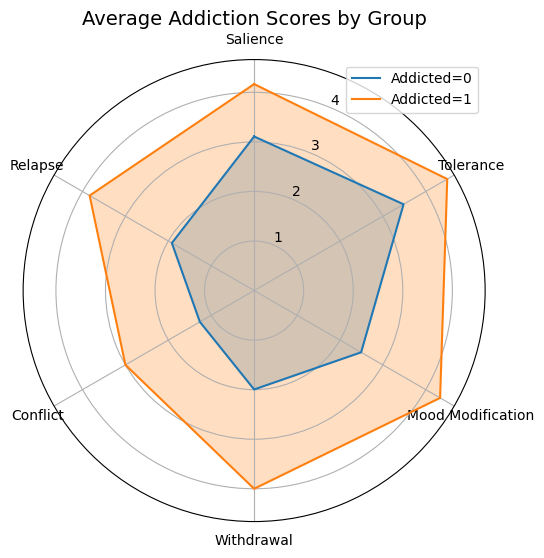

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load enhanced CSV
df = pd.read_csv("Sample1000user_addiction_scores_with_flags.csv")

# Define score columns
score_cols = ["salience", "tolerance", "mood_modification", "withdrawal", "conflict", "relapse"]

# Convert score columns to numeric
for col in score_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Add custom addiction rule: ≥ 4 items with score > 3
df["addicted"] = (df[score_cols].gt(3).sum(axis=1) >= 4).astype(int)

# Group-level mean scores
mean_scores = df.groupby("addicted")[score_cols].mean()

# Group-level addiction rates (%)
addiction_rates = df.groupby("addicted")["addicted"].mean() * 100

# Merge for printing
summary_df = mean_scores.copy()
summary_df["addiction_rate (%)"] = addiction_rates
summary_df = summary_df.round(2)

# Print summary table
print("Group-level Score Summary:")
print(summary_df)
print("\n(%) Addiction Rate = % of users flagged as addicted")

# === Radar plot ===
labels = ["Salience", "Tolerance", "Mood Modification", "Withdrawal", "Conflict", "Relapse"]
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]  # close the loop

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(polar=True))

# Add each group to the radar
for group, row in mean_scores.iterrows():
    values = row.tolist() + [row.tolist()[0]]
    ax.plot(angles, values, label=f"Addicted={group}")
    ax.fill(angles, values, alpha=0.25)

# Aesthetics
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_title("Average Addiction Scores by Group", fontsize=14)
ax.legend(loc="upper right")
plt.show()